In [1]:
import re
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import rdMolDescriptors, Descriptors, rdmolfiles, PandasTools, AllChem, Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D, MolDrawing, DrawingOptions
import mordred
from mordred import Calculator, descriptors
from itertools import combinations, permutations, pairwise,product,starmap
#from rdkit.Chem.Draw import IPythonConsole
import sklearn
import pickle
from scipy import stats
from pathlib import Path
from natsort import natsorted

## Load Copoly DF, Do mild cleanup

In [2]:
data_path = Path.cwd().parent/"data"
csv_path = Path.cwd().parent/"data/csvs"
json_path = Path.cwd().parent/"data/jsons"
pkl_path = Path.cwd().parent/"data/pkls/"

In [4]:


df = pd.read_csv(csv_path/"manual_copoly_combined_solv_df.csv", sep=';')
mono3_name = df.pop('mono3_name')
mono2_name_ind = list(df.columns).index('mono2_name')
mono3_name_ind = mono2_name_ind + 1
df.insert(loc=mono3_name_ind, column='mono3_name', value=mono3_name)
solvchar = df.pop('solvent_characteristic')
solvchar_ind = len(list(df.columns)) - 1
df.insert(loc=solvchar_ind, column='solvent_characteristic', value=solvchar)
df = df.drop(['references','polymer_comments','solv_comments'], axis=1)
df

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)       ['7', '3']        generic   
1                Poly(butadiene-co-styrene)      ['95', '5']        generic   
2                Poly(butadiene-co-styrene)       ['7', '3']        generic   
3                Poly(butadiene-co-styrene)      ['95', '5']        generic   
4                Poly(butadiene-co-styrene)       ['7', '3']        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)       ['1', '1']          block   
285    Polystyrene-b-poly(dimethylsiloxane)       ['1', '9']          block   
286    Polystyrene-b-poly(dimethylsiloxane)       ['3', '7']          block   
287       Polystyrene-b-poly(vinylpyridine)       ['1', '1']          block   
288  Polypropylene-b-poly(methacrylic acid)       ['2', '1']          block   

    mono1_name        mono2_name mono3_name    mono1_smiles      mono2_smiles  \
0    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
1    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
2    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
3    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
4    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
..         ...               ...        ...             ...               ...   
284    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
285    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
286    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
287    styrene     vinylpyridine        NaN  C=CC1=CC=CC=C1    C=CC1=NC=CC=C1   
288  propylene  methacrylic acid        NaN            CC=C      CC(C(O)=O)=C   

    mono3_smiles      solvent solvent_smiles  solvent_characteristic  
0            NaN      benzene    C1=CC=CC=C1                       1  
1            NaN      benzene    C1=CC=CC=C1                       1  
2            NaN  cyclohexane       C1CCCCC1                       1  
3            NaN  cyclohexane       C1CCCCC1                       1  
4            NaN      toluene   CC1=CC=CC=C1                       1  
..           ...          ...            ...                     ...  
284          NaN     methanol             CO                       0  
285          NaN        Water        [H]O[H]                       0  
286          NaN        Water        [H]O[H]                       0  
287          NaN       hexane         CCCCCC                       0  
288          NaN     methanol             CO                       0  

[289 rows x 12 columns]

### Create Mol Objects

In [5]:
mono1_smiles, mono2_smiles, mono3_smiles = (list(df.mono1_smiles),
										 list(df.mono2_smiles),
										 list(df.mono3_smiles))
unique_copolymer_smiles = list(set(mono1_smiles)|set(mono2_smiles)|set(mono3_smiles))
print(len(mono1_smiles),len(mono2_smiles),len(mono3_smiles), len(unique_copolymer_smiles))

smiles_superlist = [mono1_smiles, mono2_smiles, mono3_smiles]
mol_superlist = []
for lst in smiles_superlist:
	tmp_lst = []
	for entry in lst:
		if entry is not np.nan:
			m = Chem.MolFromSmiles(entry)
		else:
			m = np.nan
		tmp_lst.append(m)
	mol_superlist.append(tmp_lst)

mono1_mol, mono2_mol, mono3_mol = mol_superlist

289 289 289 121


In [7]:

def insert_new_col(df, pos, col_name, values):
	if col_name not in df.columns:
		df.insert(loc=pos, column=col_name, value=values)
	return df
df = insert_new_col(df, 9, 'mono1_mol', mono1_mol)
df = insert_new_col(df, 10, 'mono2_mol', mono2_mol)
df = insert_new_col(df, 11, 'mono3_mol', mono3_mol)
df

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)       ['7', '3']        generic   
1                Poly(butadiene-co-styrene)      ['95', '5']        generic   
2                Poly(butadiene-co-styrene)       ['7', '3']        generic   
3                Poly(butadiene-co-styrene)      ['95', '5']        generic   
4                Poly(butadiene-co-styrene)       ['7', '3']        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)       ['1', '1']          block   
285    Polystyrene-b-poly(dimethylsiloxane)       ['1', '9']          block   
286    Polystyrene-b-poly(dimethylsiloxane)       ['3', '7']          block   
287       Polystyrene-b-poly(vinylpyridine)       ['1', '1']          block   
288  Polypropylene-b-poly(methacrylic acid)       ['2', '1']          block   

    mono1_name        mono2_name mono3_name    mono1_smiles      mono2_smiles  \
0    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
1    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
2    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
3    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
4    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
..         ...               ...        ...             ...               ...   
284    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
285    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
286    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
287    styrene     vinylpyridine        NaN  C=CC1=CC=CC=C1    C=CC1=NC=CC=C1   
288  propylene  methacrylic acid        NaN            CC=C      CC(C(O)=O)=C   

    mono3_smiles                                          mono1_mol  \
0            NaN  <img data-content="rdkit/molecule" src="data:i...   
1            NaN  <img data-content="rdkit/molecule" src="data:i...   
2            NaN  <img data-content="rdkit/molecule" src="data:i...   
3            NaN  <img data-content="rdkit/molecule" src="data:i...   
4            NaN  <img data-content="rdkit/molecule" src="data:i...   
..           ...                                                ...   
284          NaN  <img data-content="rdkit/molecule" src="data:i...   
285          NaN  <img data-content="rdkit/molecule" src="data:i...   
286          NaN  <img data-content="rdkit/molecule" src="data:i...   
287          NaN  <img data-content="rdkit/molecule" src="data:i...   
288          NaN  <img data-content="rdkit/molecule" src="data:i...   

                                             mono2_mol mono3_mol      solvent  \
0    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
1    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
2    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
3    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
4    <img data-content="rdkit/molecule" src="data:i...       NaN      toluene   
..                                                 ...       ...          ...   
284  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   
285  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
286  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
287  <img data-content="rdkit/molecule" src="data:i...       NaN       hexane   
288  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   

    solvent_smiles  solvent_characteristic  
0      C1=CC=CC=C1                       1  
1      C1=CC=CC=C1                       1  
2         C1CCCCC1                       1  
3         C1CCCCC1                       1  
4     CC1=CC=CC=C1                       1  
..             ...

### Fix datapoints with radicals

In [8]:
import os
from pathlib import Path
from copy import copy,deepcopy

def clear_radical_electrons(mol_list: list, print_output: bool=False):
	new_mol_list = [deepcopy(x) for x in mol_list]
	for mol_pos,m in enumerate(new_mol_list):
		#m = Chem.AddHs(m)
		if type(m) == float:
			print(m,"Is float, appending np.nan")
			new_mol_list[mol_pos] = np.nan
		elif Chem.Descriptors.NumRadicalElectrons(m) > 0:
			if print_output:
				display("BEFORE ADDITION",m)
			rw_mol = Chem.RWMol(m)
			rad_atoms = [atom for atom in rw_mol.GetAtoms() if atom.GetNumRadicalElectrons() == 1]
			rad_pos = [atom.GetIdx() for atom in rad_atoms]
			double_rads = [atom for atom in rw_mol.GetAtoms() if atom.GetNumRadicalElectrons() == 2]
			if len(double_rads) > 0:
				if print_output:
					print("~~Warning - Double Radicals present, H not added for them~~")
			#* Set Num radicals to zero, add bond to H for each radical. Does not touch double radicals
			for i,rad_atom in enumerate(rad_atoms):
				if print_output:
					print(f"NUM ATOMS BEFORE H ADDITION {i}: {rw_mol.GetNumAtoms()}")
				rad_atom.SetNumRadicalElectrons(0)

				atom_indices = [x.GetIdx() for x in rw_mol.GetAtoms()]
				#print("INDICES BEFORE",atom_indices)

				Chem.RWMol.AddAtom(rw_mol, Chem.Atom('H'))
				if print_output:
					print(f"NUM ATOMS AFTER H ADDITION {i}: {rw_mol.GetNumAtoms()}")

				atom_indices = [x.GetIdx() for x in rw_mol.GetAtoms()]
				#print("INDICES AFTER",atom_indices)

				#display(rw_mol.GetMol())
				rw_mol.AddBond(rad_pos[i], atom_indices[-1], Chem.BondType.SINGLE)
				#display(rw_mol.GetMol())
			mol_out = Chem.RemoveHs(rw_mol.GetMol())
			if print_output:
				display("AFTER ADDITION",mol_out)
			new_mol_list[mol_pos] = mol_out
			
			print(f"~~RADICALS REPLACED WITH H FOR MOL {mol_pos}~~\n")
		else:
			new_mol_list[mol_pos] = Chem.RemoveHs(m)
	return new_mol_list


In [9]:
solv_smiles = list(df.solvent_smiles)
solv_mols = [Chem.MolFromSmiles(x) for x in solv_smiles]
df = insert_new_col(df, 14, 'solvent_mol', solv_mols)
df

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)       ['7', '3']        generic   
1                Poly(butadiene-co-styrene)      ['95', '5']        generic   
2                Poly(butadiene-co-styrene)       ['7', '3']        generic   
3                Poly(butadiene-co-styrene)      ['95', '5']        generic   
4                Poly(butadiene-co-styrene)       ['7', '3']        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)       ['1', '1']          block   
285    Polystyrene-b-poly(dimethylsiloxane)       ['1', '9']          block   
286    Polystyrene-b-poly(dimethylsiloxane)       ['3', '7']          block   
287       Polystyrene-b-poly(vinylpyridine)       ['1', '1']          block   
288  Polypropylene-b-poly(methacrylic acid)       ['2', '1']          block   

    mono1_name        mono2_name mono3_name    mono1_smiles      mono2_smiles  \
0    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
1    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
2    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
3    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
4    butadiene           styrene        NaN          C=CC=C    C=CC1=CC=CC=C1   
..         ...               ...        ...             ...               ...   
284    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
285    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
286    styrene  dimethylsiloxane        NaN  C=CC1=CC=CC=C1  [SiH3]O[SiH](C)C   
287    styrene     vinylpyridine        NaN  C=CC1=CC=CC=C1    C=CC1=NC=CC=C1   
288  propylene  methacrylic acid        NaN            CC=C      CC(C(O)=O)=C   

    mono3_smiles                                          mono1_mol  \
0            NaN  <img data-content="rdkit/molecule" src="data:i...   
1            NaN  <img data-content="rdkit/molecule" src="data:i...   
2            NaN  <img data-content="rdkit/molecule" src="data:i...   
3            NaN  <img data-content="rdkit/molecule" src="data:i...   
4            NaN  <img data-content="rdkit/molecule" src="data:i...   
..           ...                                                ...   
284          NaN  <img data-content="rdkit/molecule" src="data:i...   
285          NaN  <img data-content="rdkit/molecule" src="data:i...   
286          NaN  <img data-content="rdkit/molecule" src="data:i...   
287          NaN  <img data-content="rdkit/molecule" src="data:i...   
288          NaN  <img data-content="rdkit/molecule" src="data:i...   

                                             mono2_mol mono3_mol      solvent  \
0    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
1    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
2    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
3    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
4    <img data-content="rdkit/molecule" src="data:i...       NaN      toluene   
..                                                 ...       ...          ...   
284  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   
285  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
286  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
287  <img data-content="rdkit/molecule" src="data:i...       NaN       hexane   
288  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   

    solvent_smiles                                        solvent_mol  \
0      C1=CC=CC=C1  <img data-content="rdkit/molecule" src="data:i...   
1      C1=CC=CC=C1  <img data-content="rdkit/molecule" src="data:i...   
2         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...

ON LIST NO 0
~~RADICALS REPLACED WITH H FOR MOL 93~~

~~RADICALS REPLACED WITH H FOR MOL 94~~

~~RADICALS REPLACED WITH H FOR MOL 95~~

~~RADICALS REPLACED WITH H FOR MOL 96~~

~~RADICALS REPLACED WITH H FOR MOL 99~~

~~RADICALS REPLACED WITH H FOR MOL 100~~

~~RADICALS REPLACED WITH H FOR MOL 102~~

~~RADICALS REPLACED WITH H FOR MOL 103~~

~~RADICALS REPLACED WITH H FOR MOL 107~~

~~RADICALS REPLACED WITH H FOR MOL 108~~

~~RADICALS REPLACED WITH H FOR MOL 114~~

~~RADICALS REPLACED WITH H FOR MOL 146~~

~~RADICALS REPLACED WITH H FOR MOL 147~~

~~RADICALS REPLACED WITH H FOR MOL 148~~

~~RADICALS REPLACED WITH H FOR MOL 149~~

~~RADICALS REPLACED WITH H FOR MOL 162~~

~~RADICALS REPLACED WITH H FOR MOL 163~~

~~RADICALS REPLACED WITH H FOR MOL 164~~

~~RADICALS REPLACED WITH H FOR MOL 165~~

~~RADICALS REPLACED WITH H FOR MOL 166~~

~~RADICALS REPLACED WITH H FOR MOL 186~~

~~RADICALS REPLACED WITH H FOR MOL 187~~

~~RADICALS REPLACED WITH H FOR MOL 188~~

~~RADICALS REPLACED WITH H
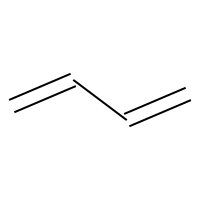
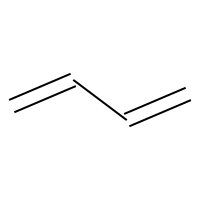
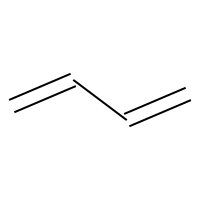
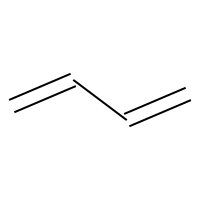
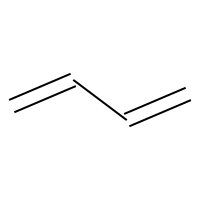
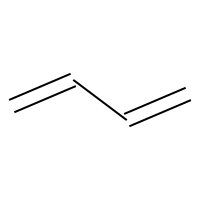
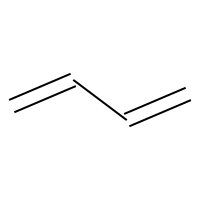
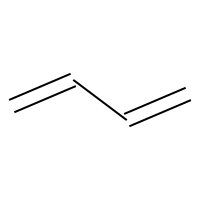
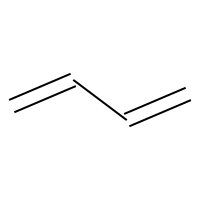
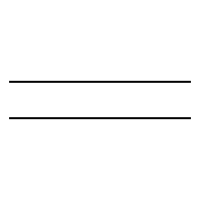
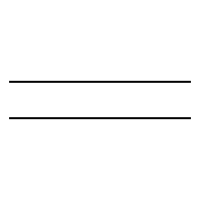
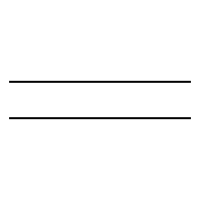
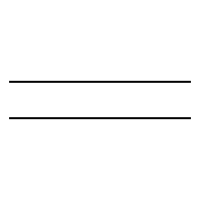
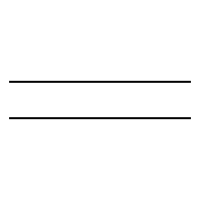
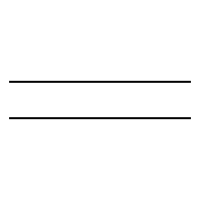
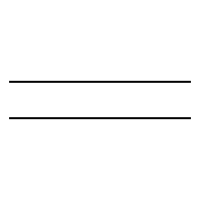
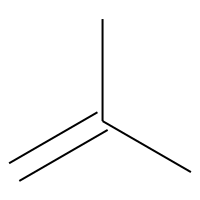
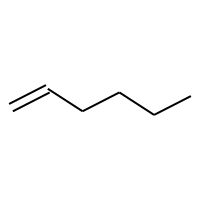
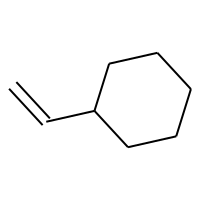
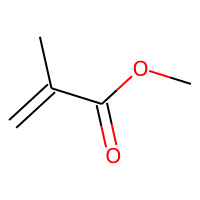
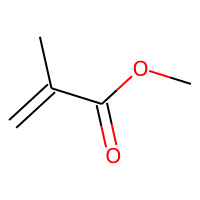
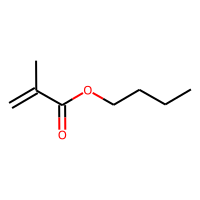
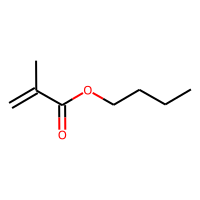
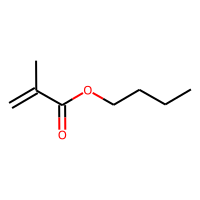
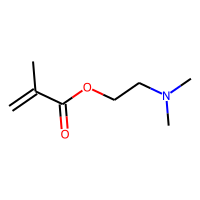
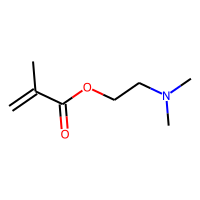
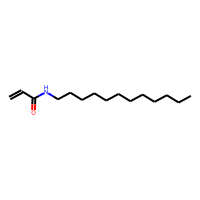
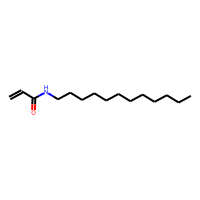
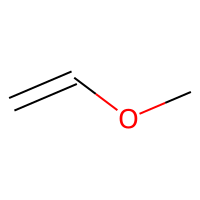
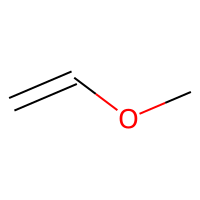
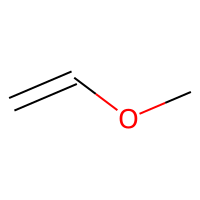
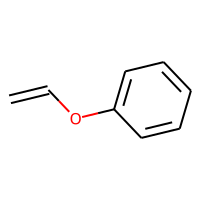
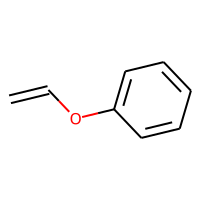
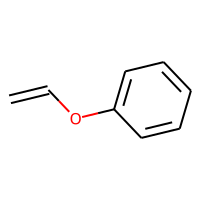
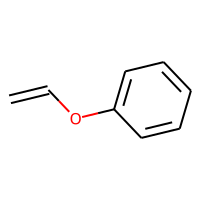
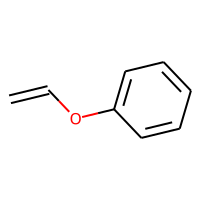
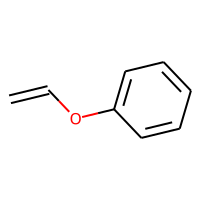
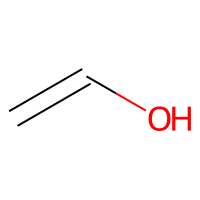
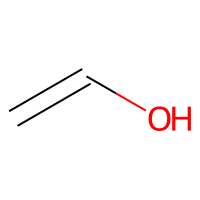
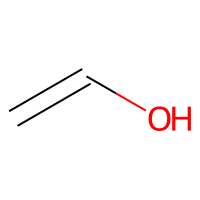
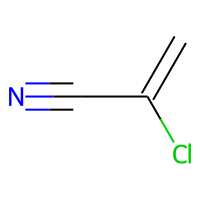
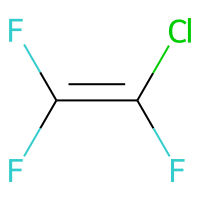
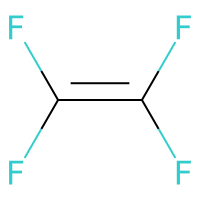
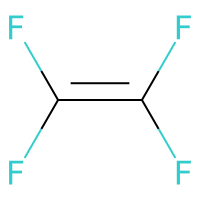
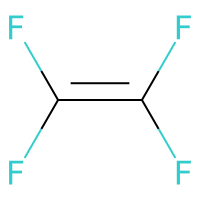
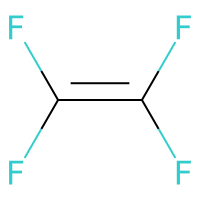
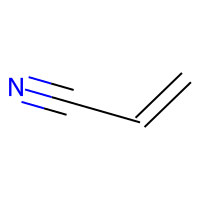
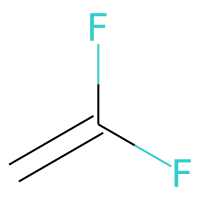
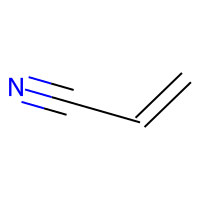
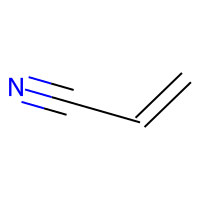
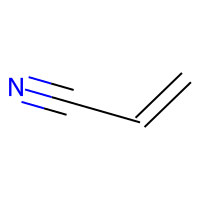
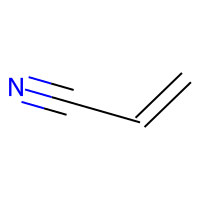
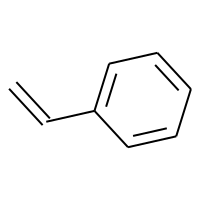
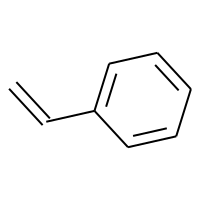
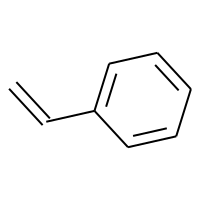
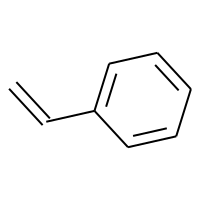
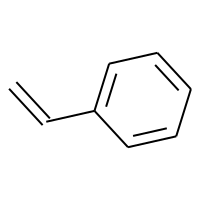
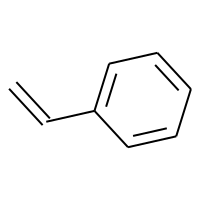
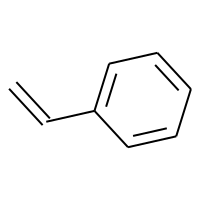
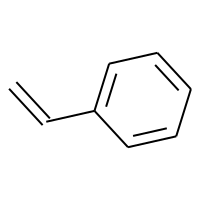
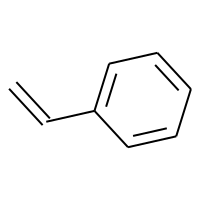
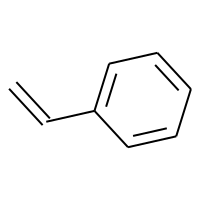
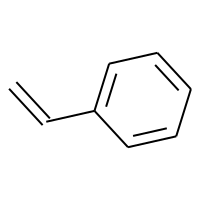
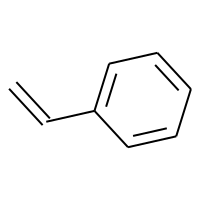
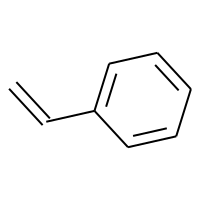
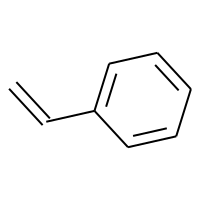
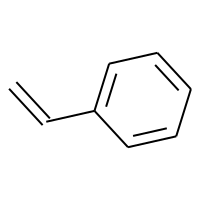
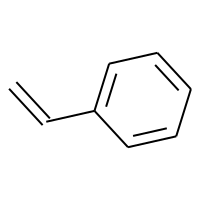
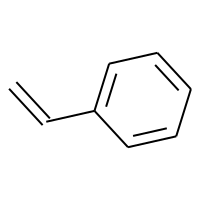
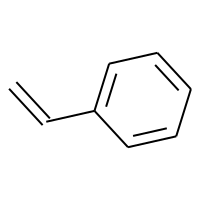
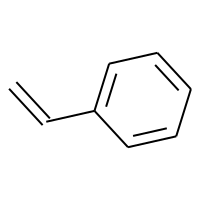
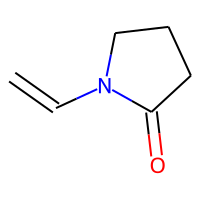
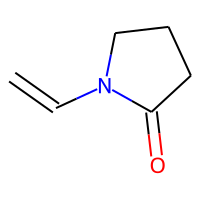
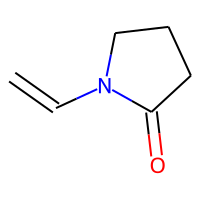
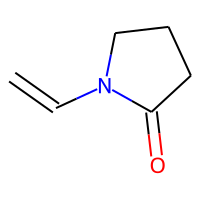
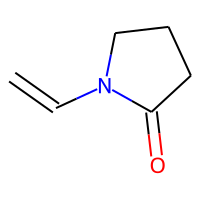
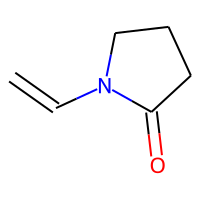
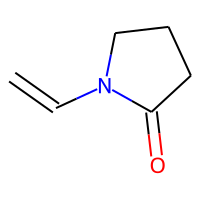
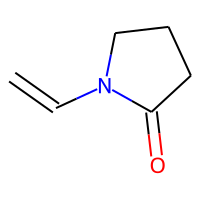
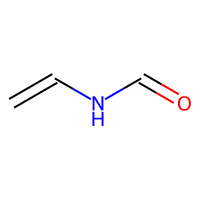
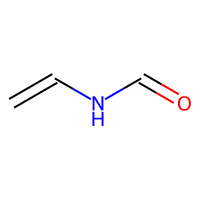
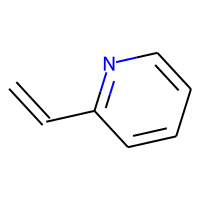
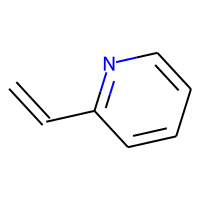
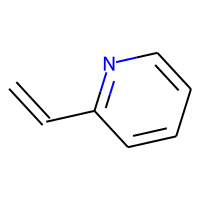
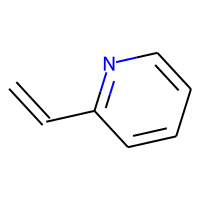
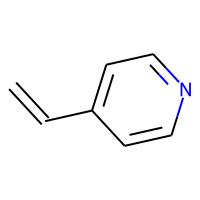
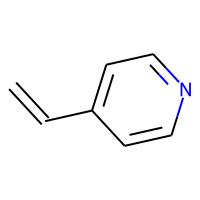
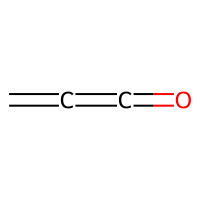
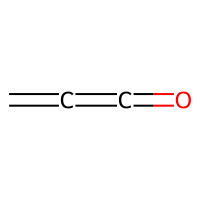
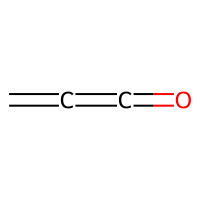
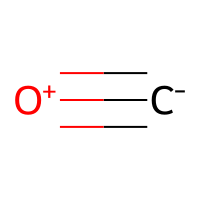
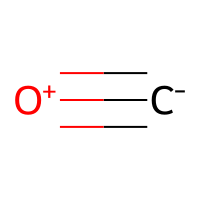
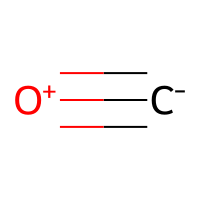
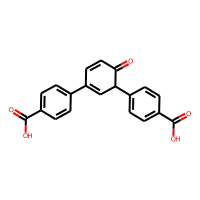
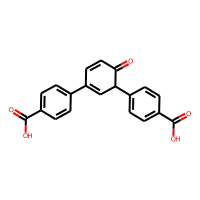
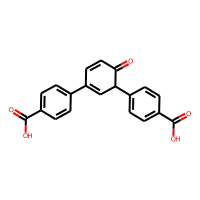
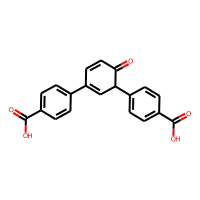
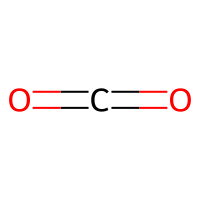
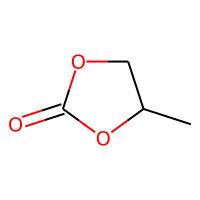
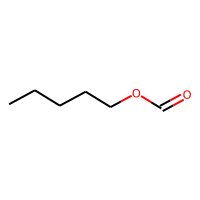
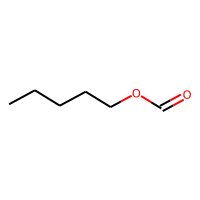
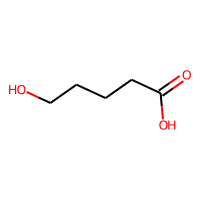
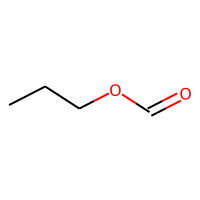
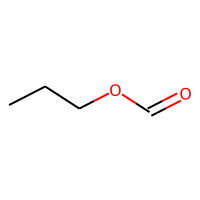
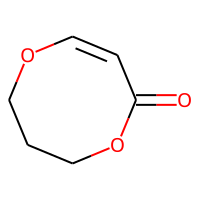
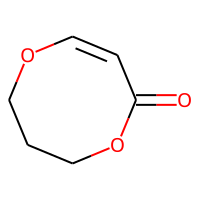
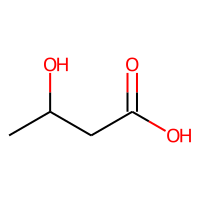
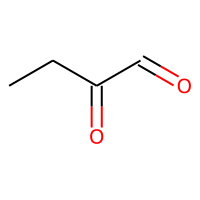
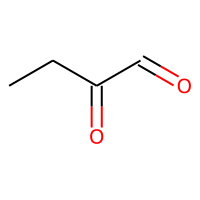
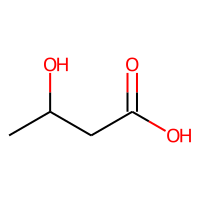
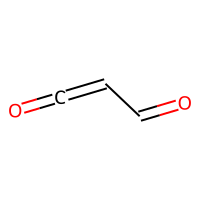
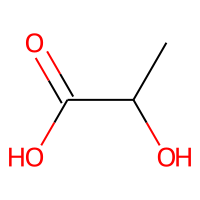
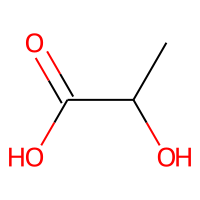
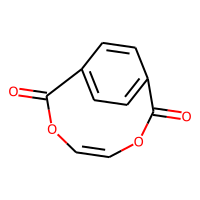
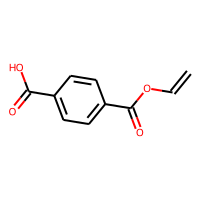
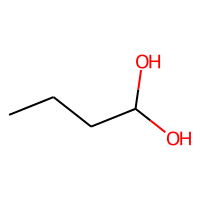
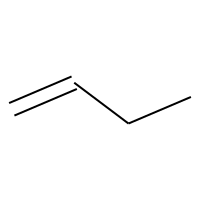
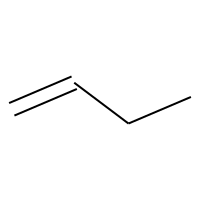
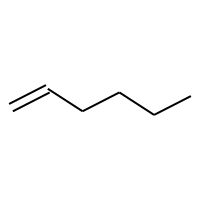
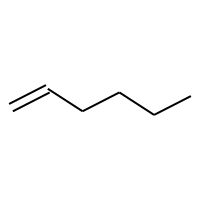
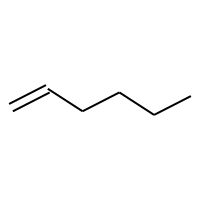
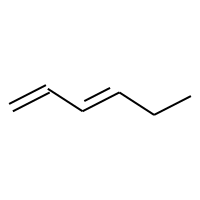
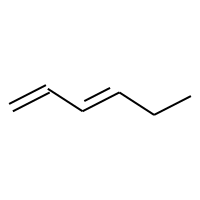
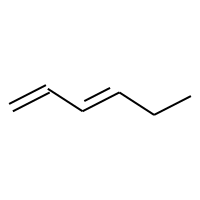
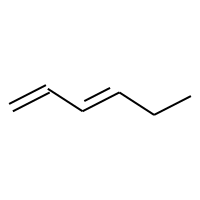
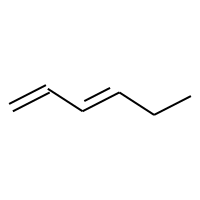
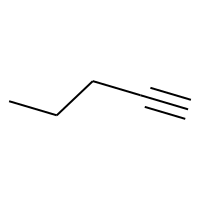
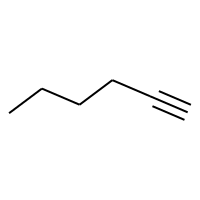
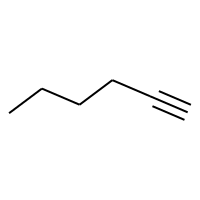
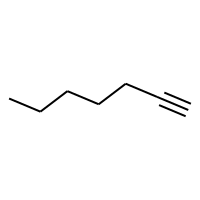
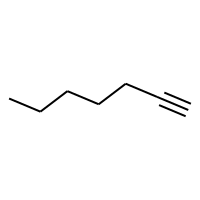
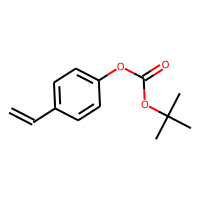
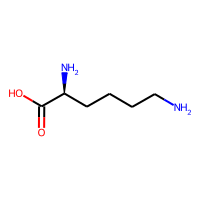
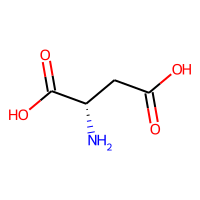
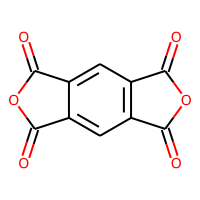
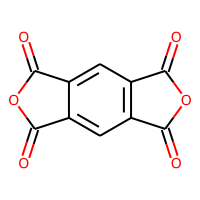
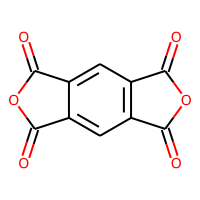
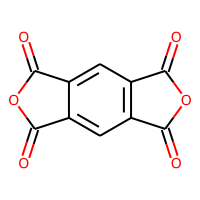
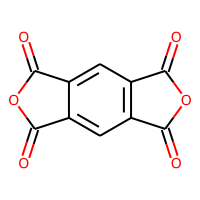
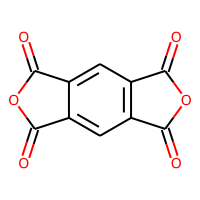
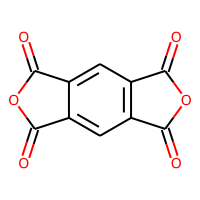
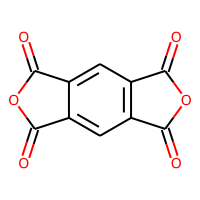
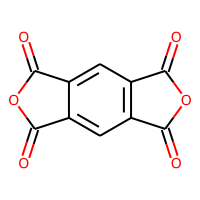
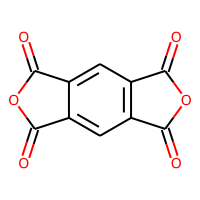
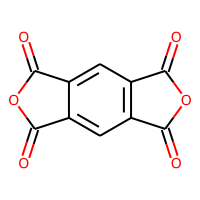
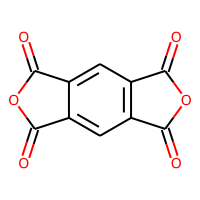
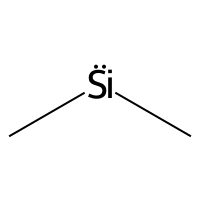
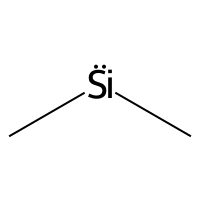
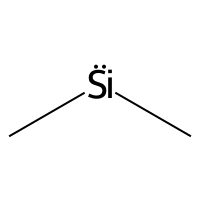
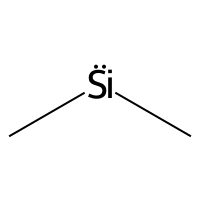
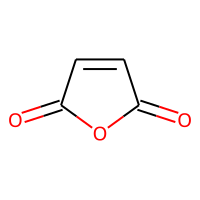
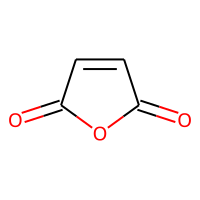
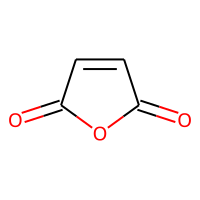
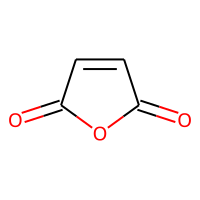
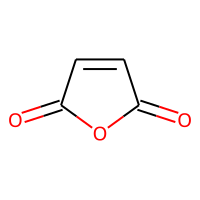
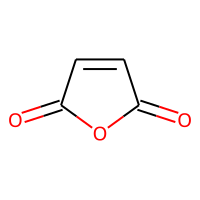
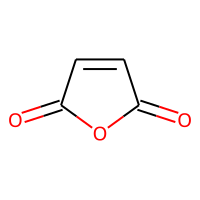
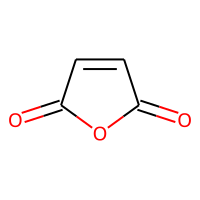
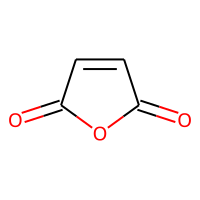
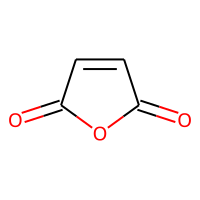
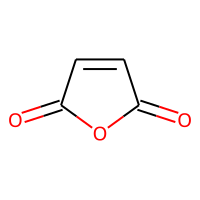
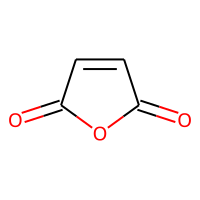
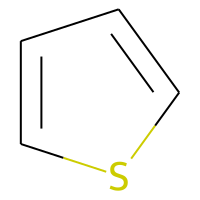
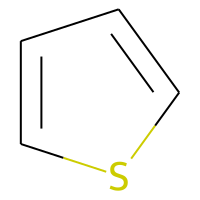
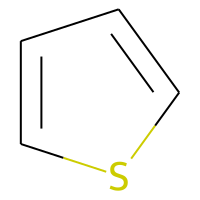
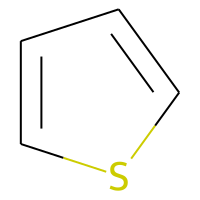
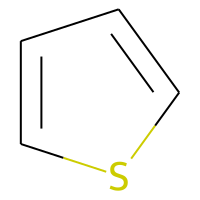
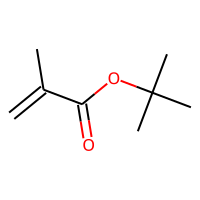
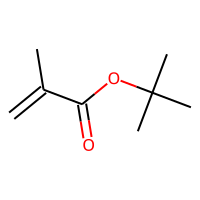
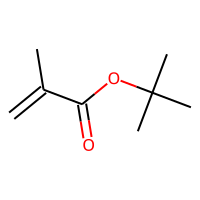
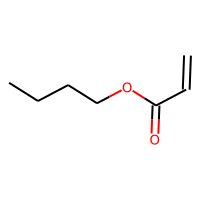
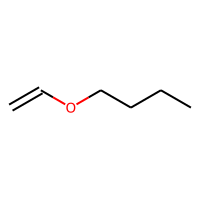
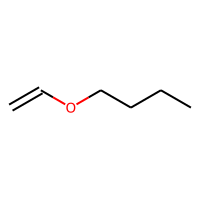
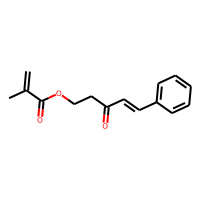
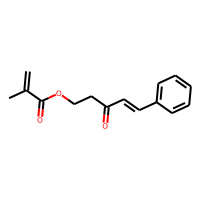
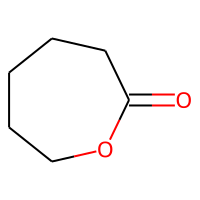
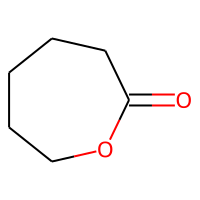
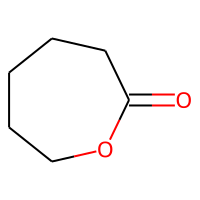
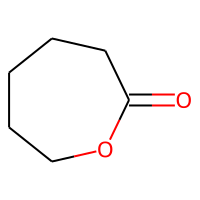
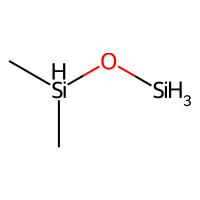
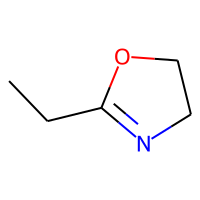
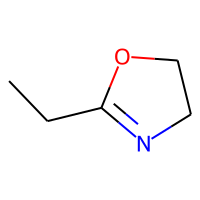
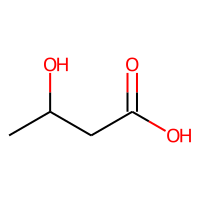
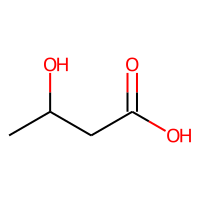
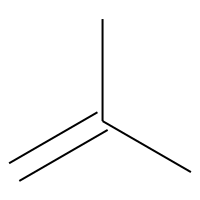
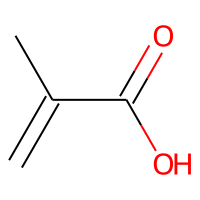
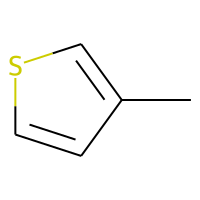
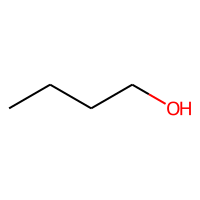
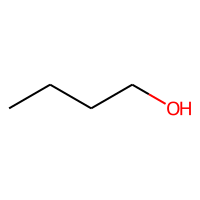
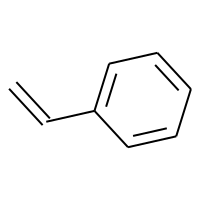
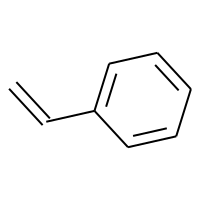
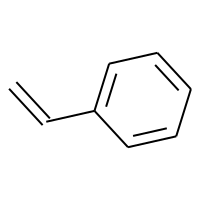
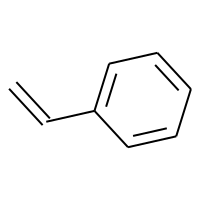
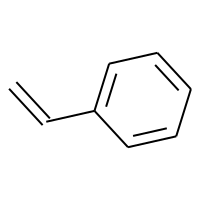
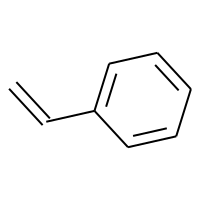
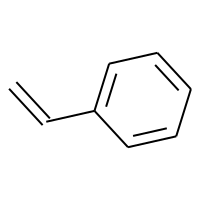
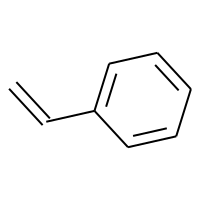
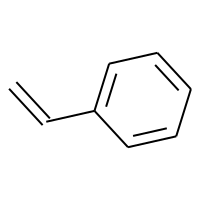
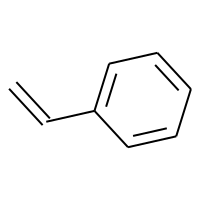
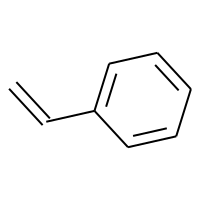
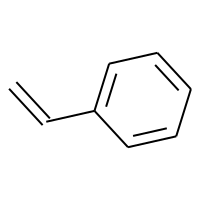
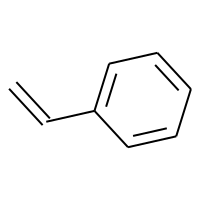
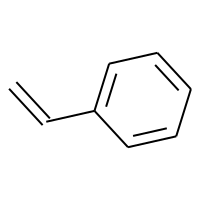
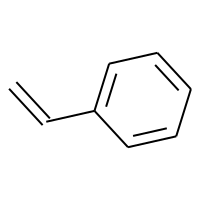
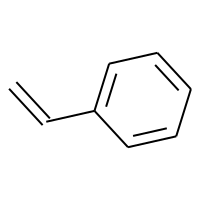
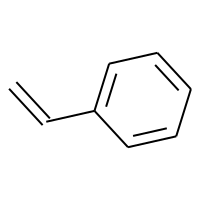
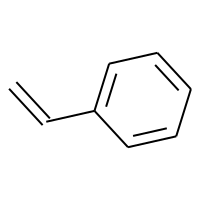
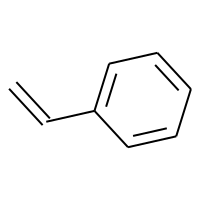
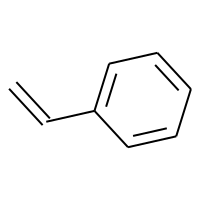
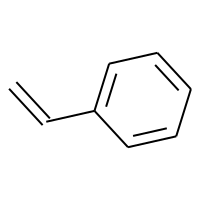
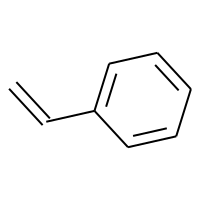
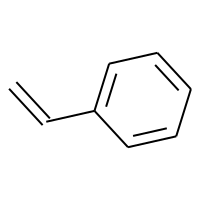
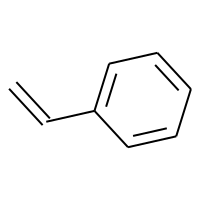
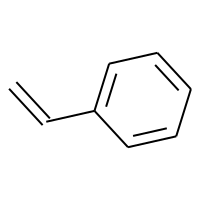
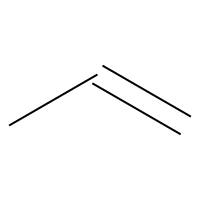
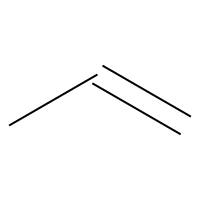
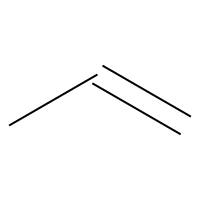
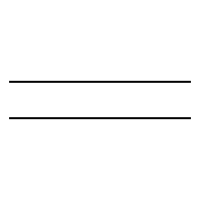
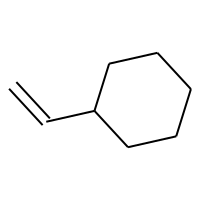
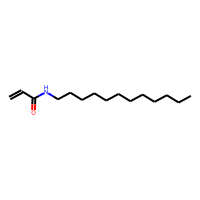
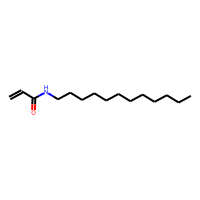
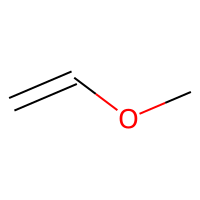
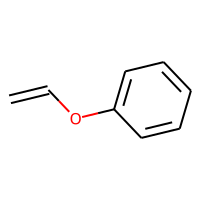
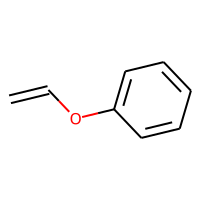
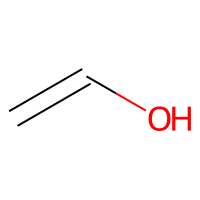
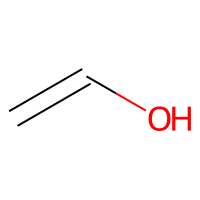
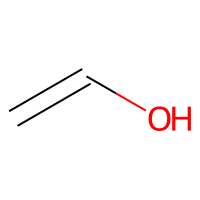
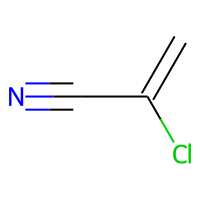
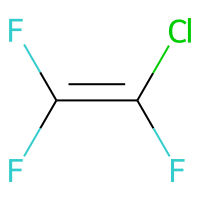
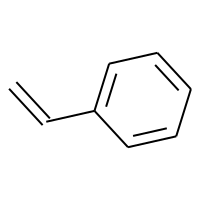
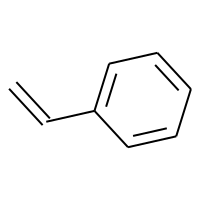
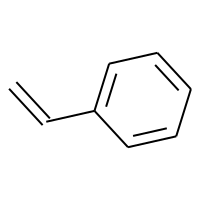
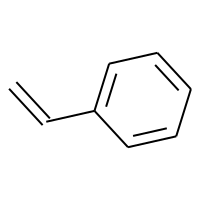
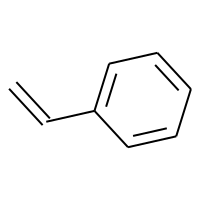
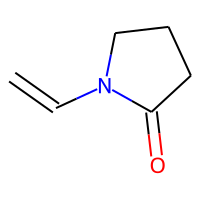
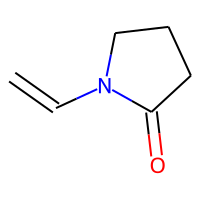
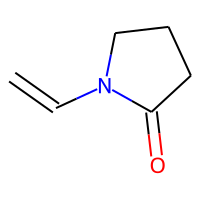
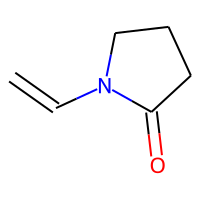
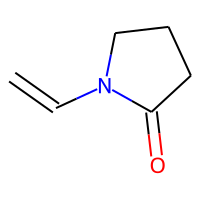
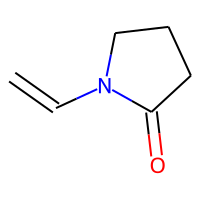
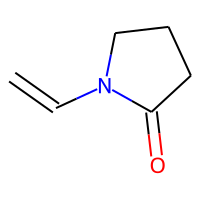
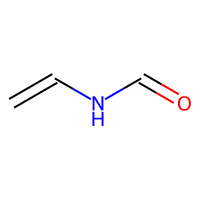
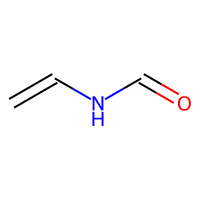
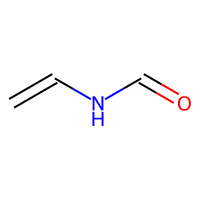
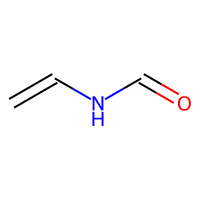
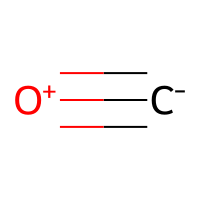
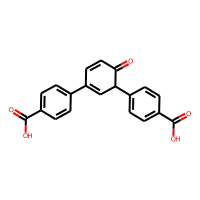
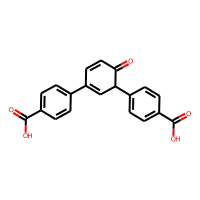
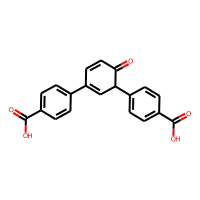
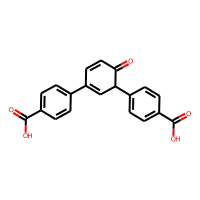
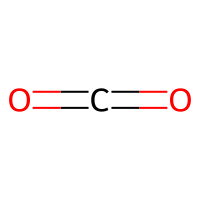
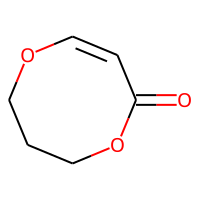
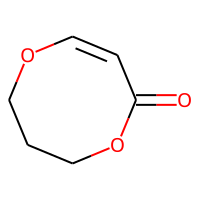
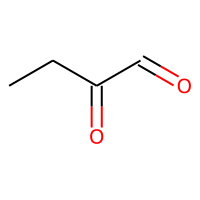
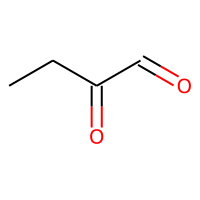
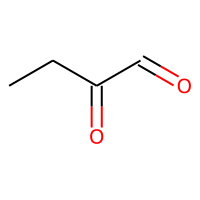
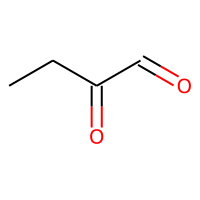
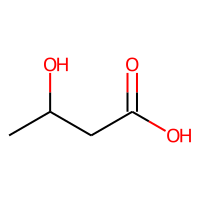
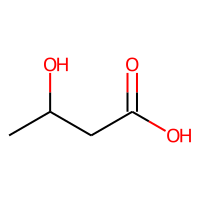
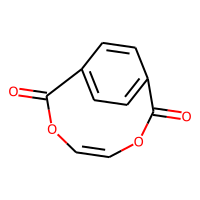
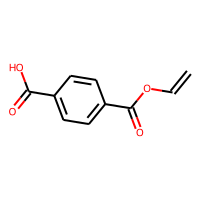
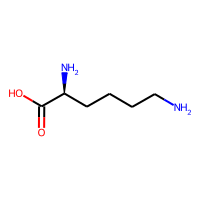
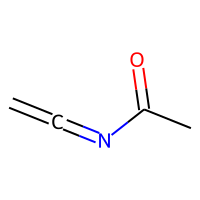
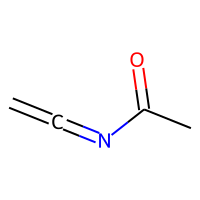
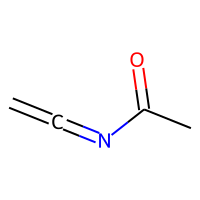
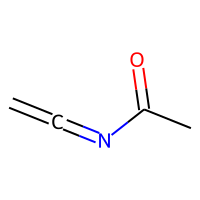
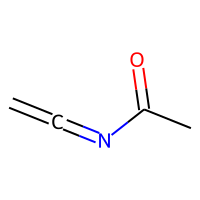
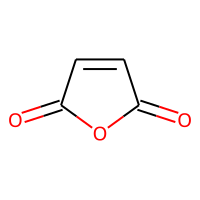
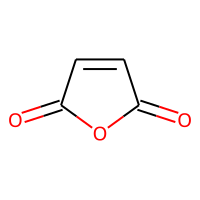
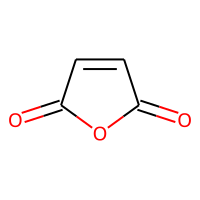
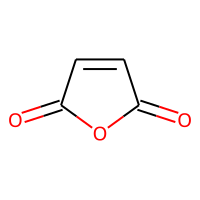
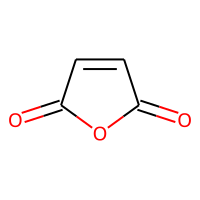
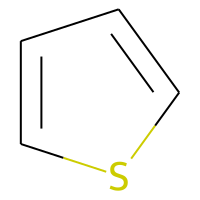
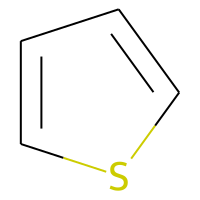
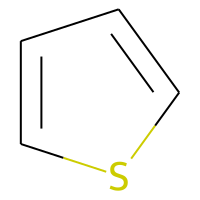
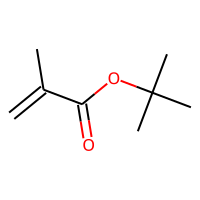
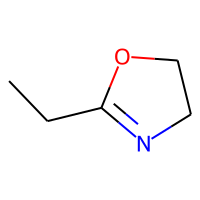
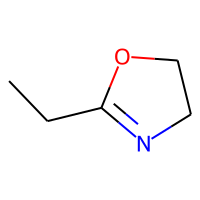
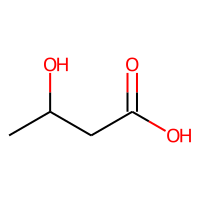
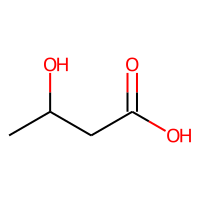
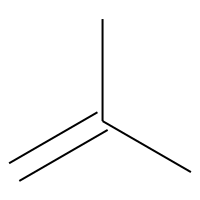
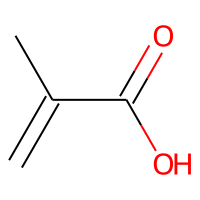
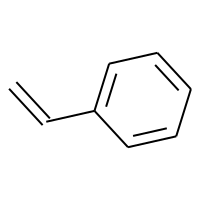
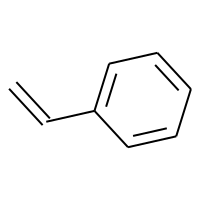
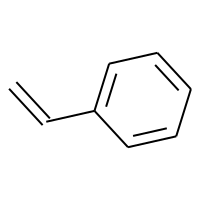
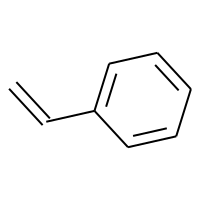
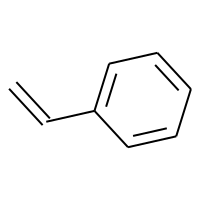
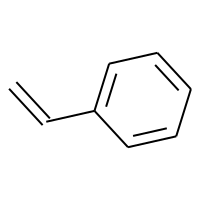
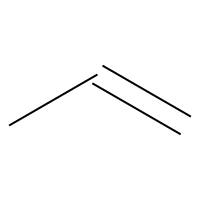
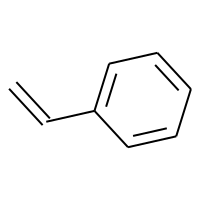
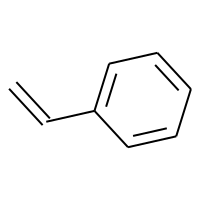
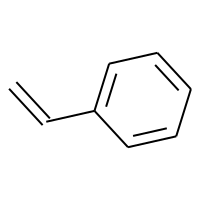
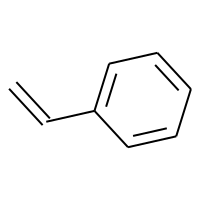
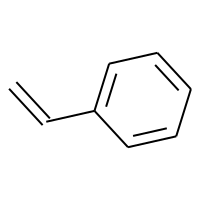
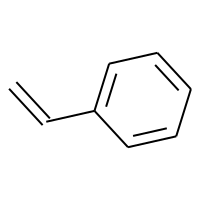
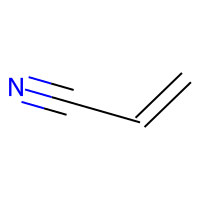
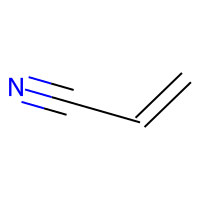
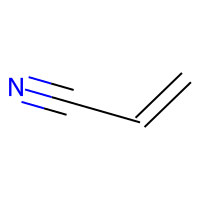
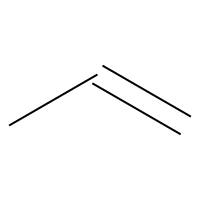
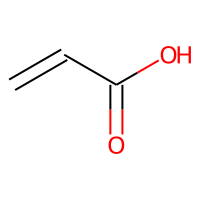
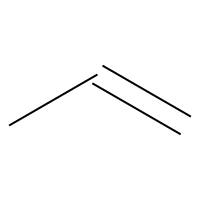
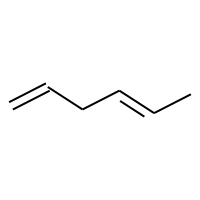
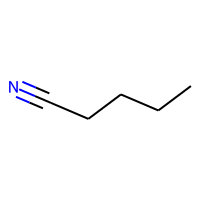
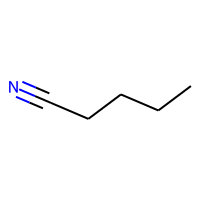
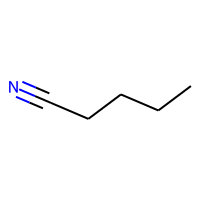
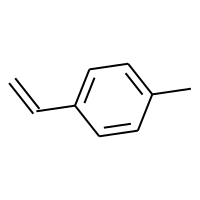
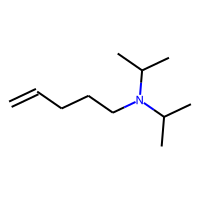
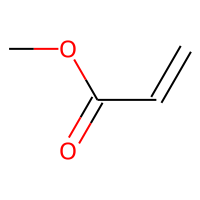
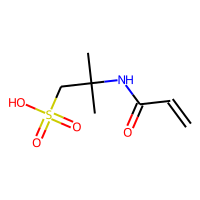
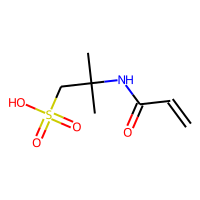
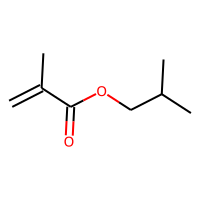
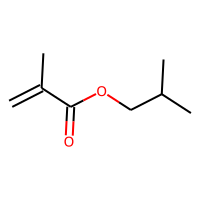
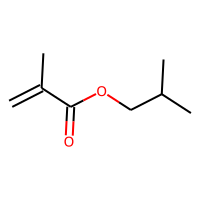
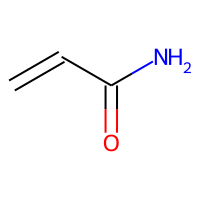
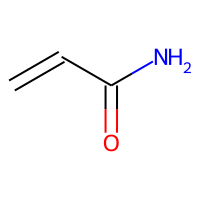
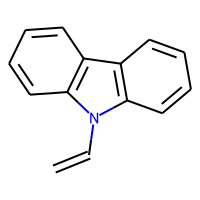
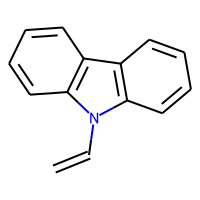
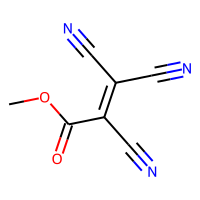
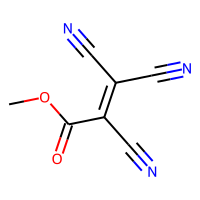
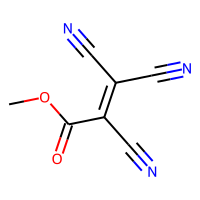
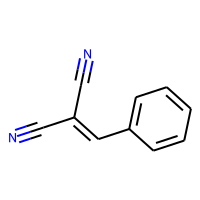
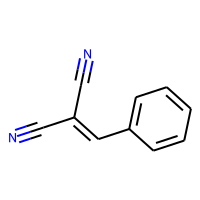
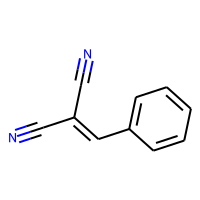
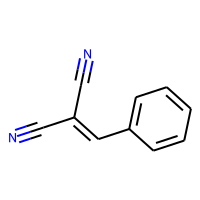
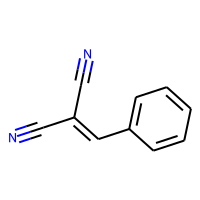
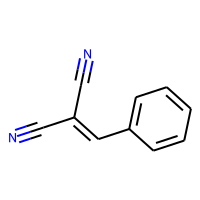
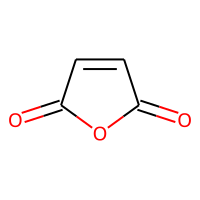
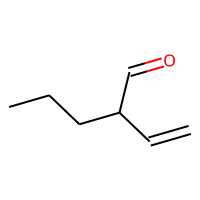
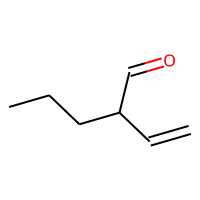
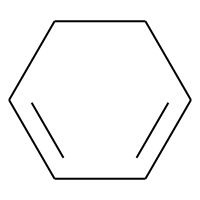
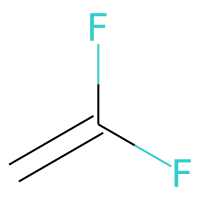
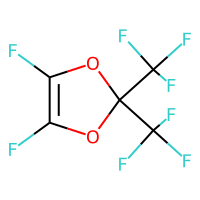
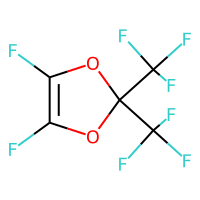
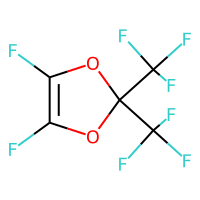
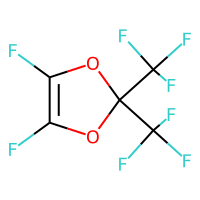
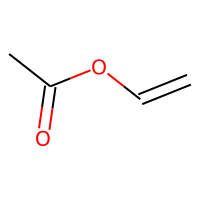
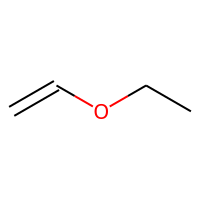
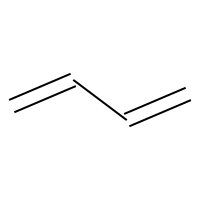
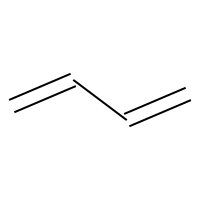
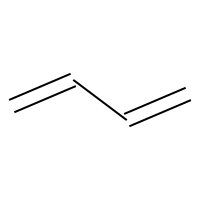
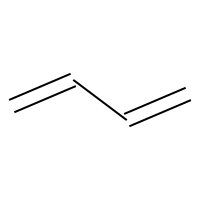
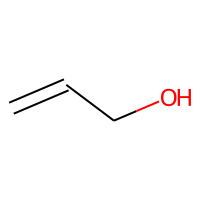
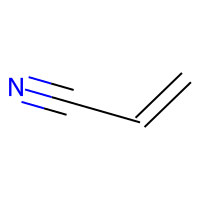
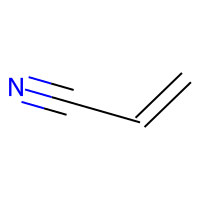
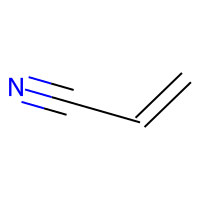
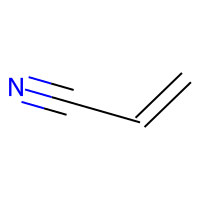
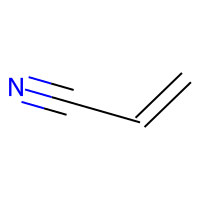
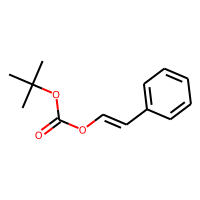
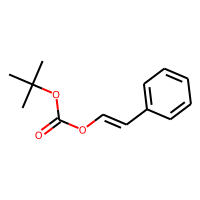
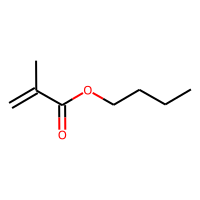
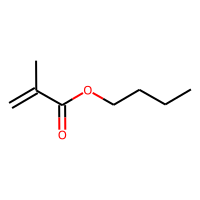
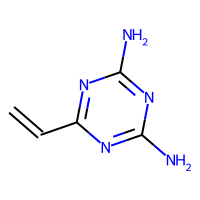
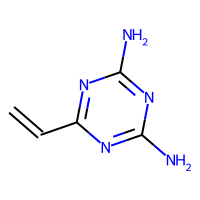
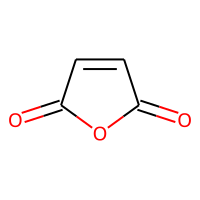
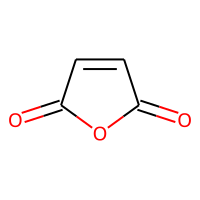
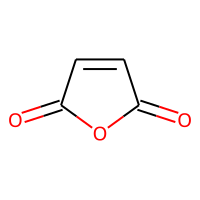
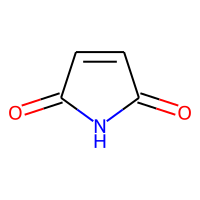
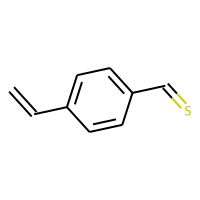
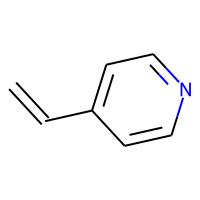
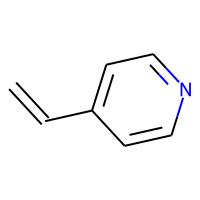
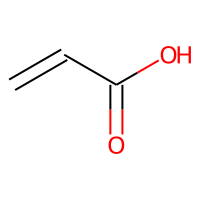
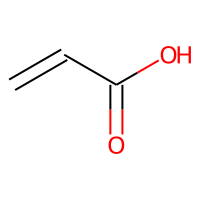
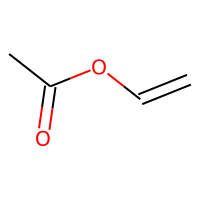
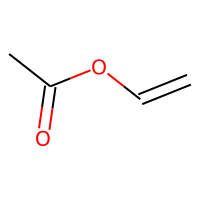
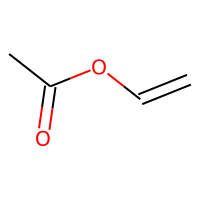
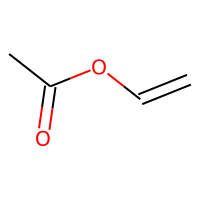
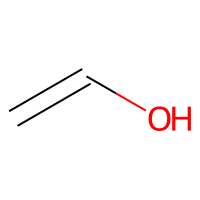
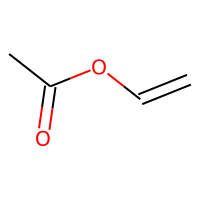
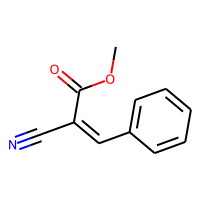
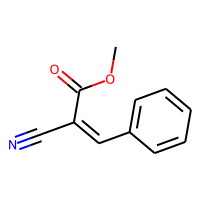
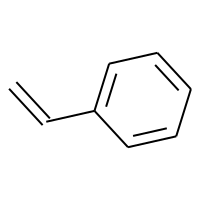
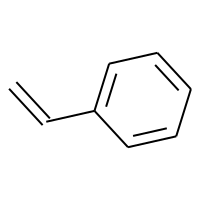
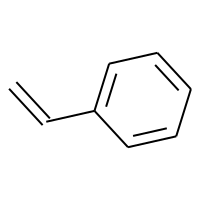
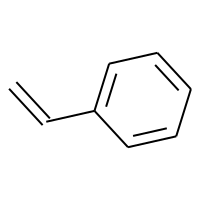
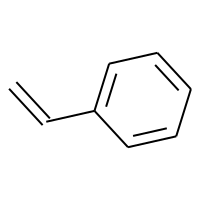
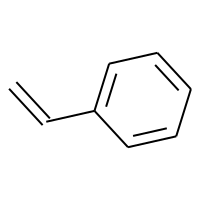
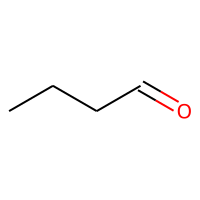
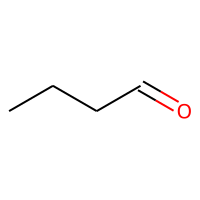
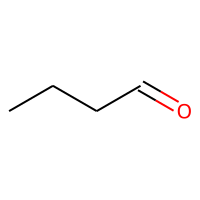
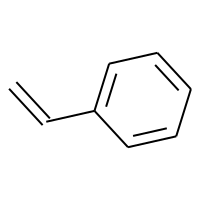
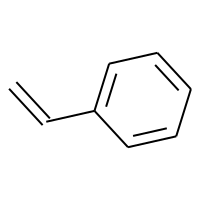
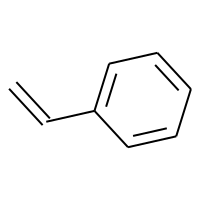
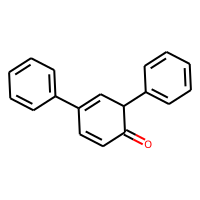
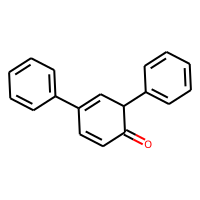
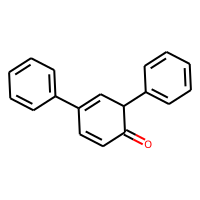
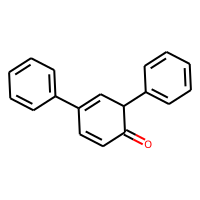
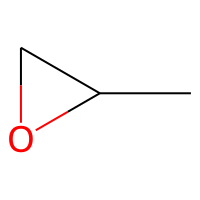
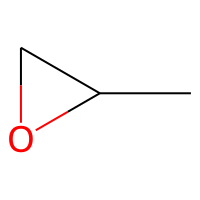
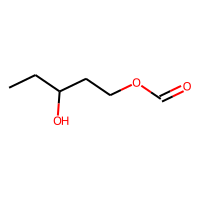
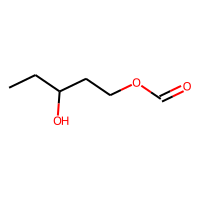
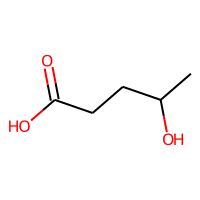
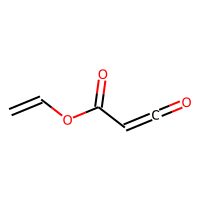
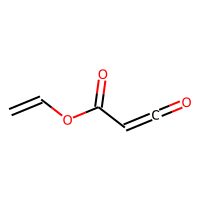
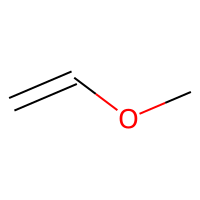
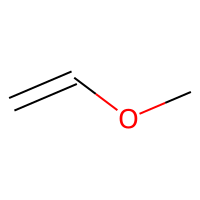
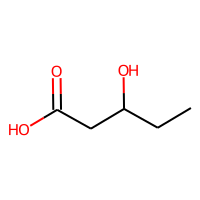
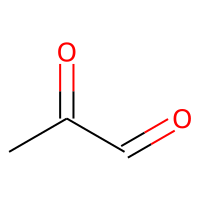
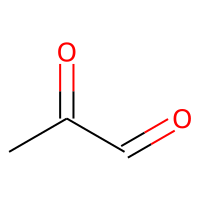
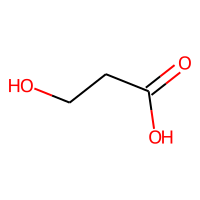
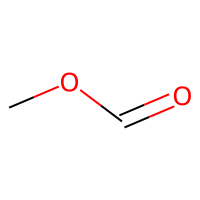
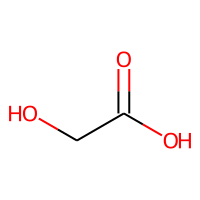
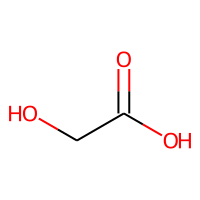
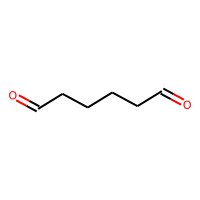
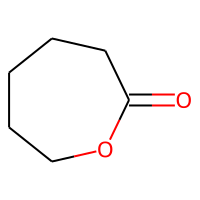
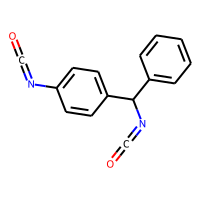
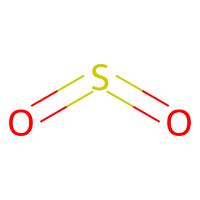
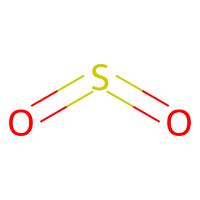
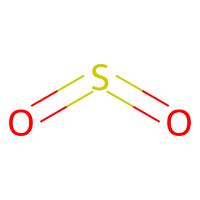
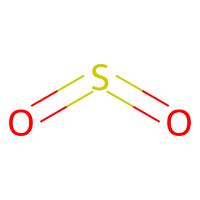
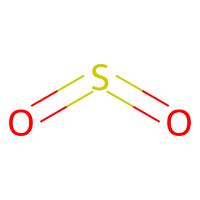
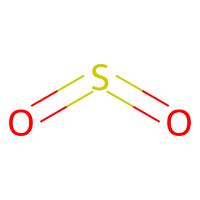
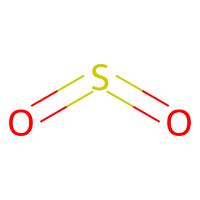
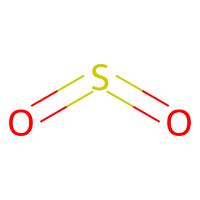
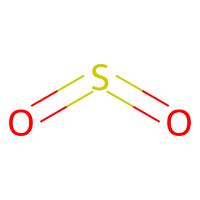
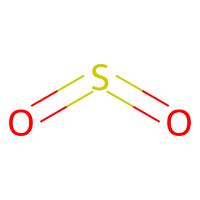
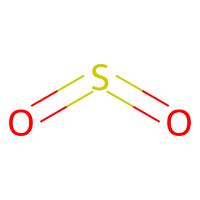
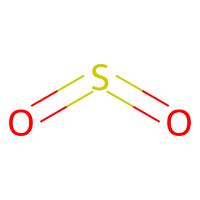
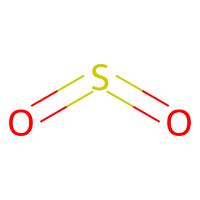
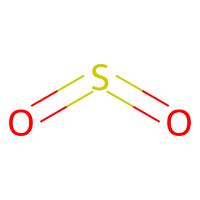
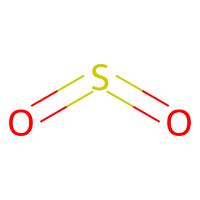
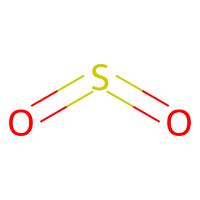
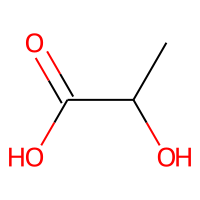
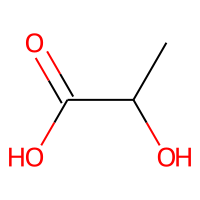
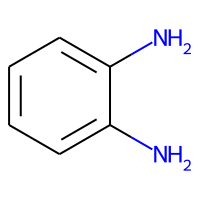
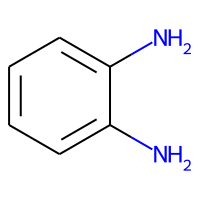
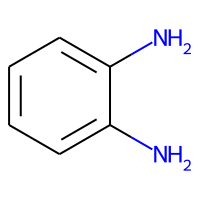
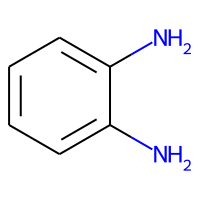
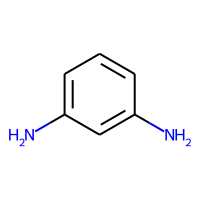
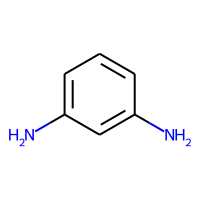
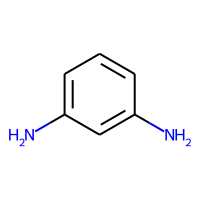
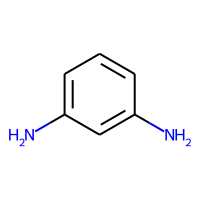
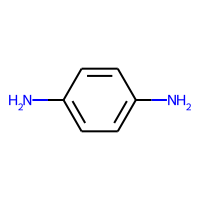
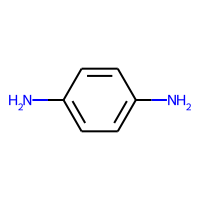
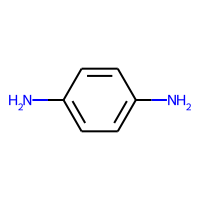
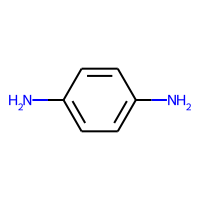
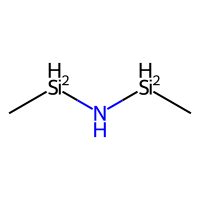
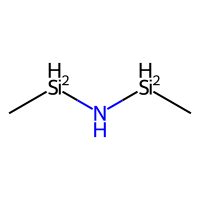
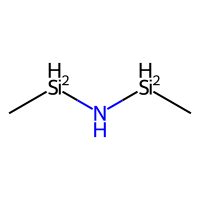
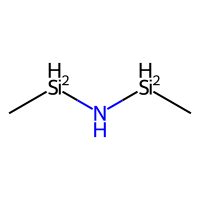
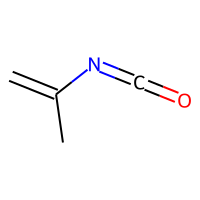
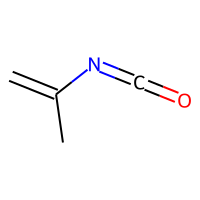
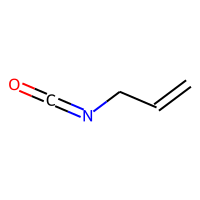
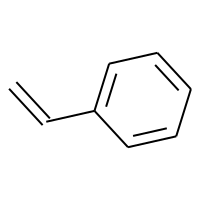
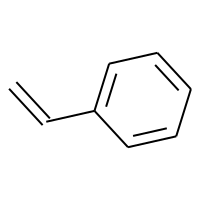
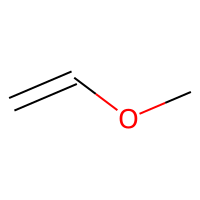
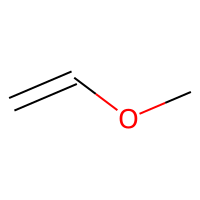
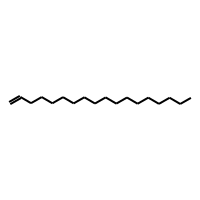
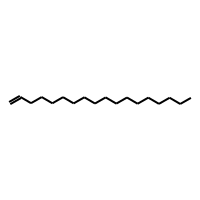
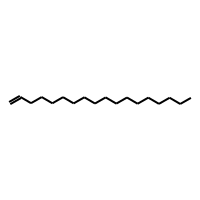
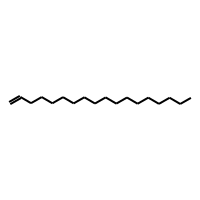
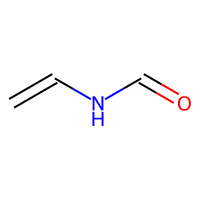
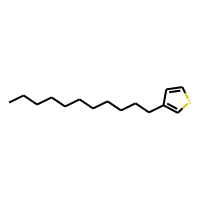
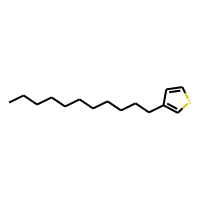
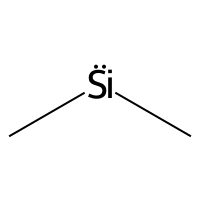
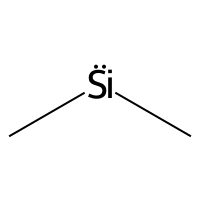
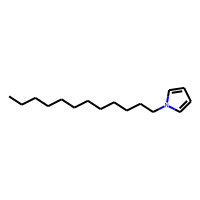
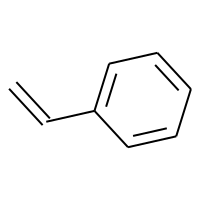
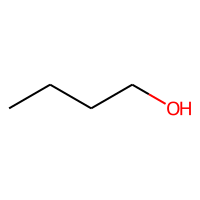
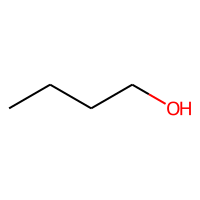
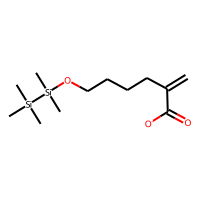
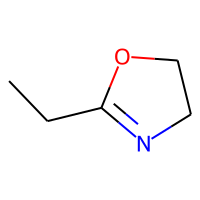
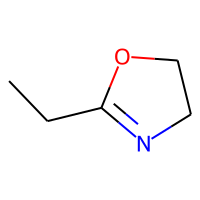
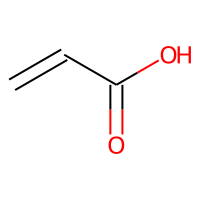
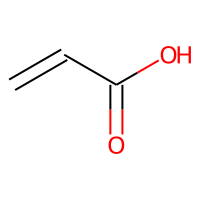
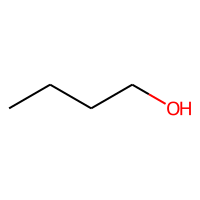
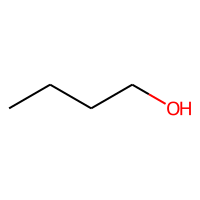
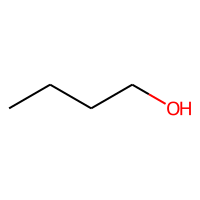
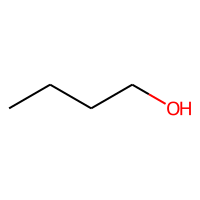
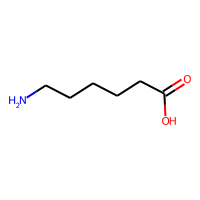
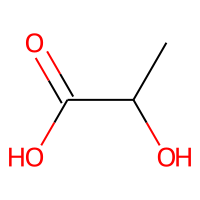
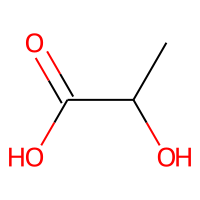
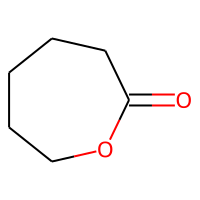
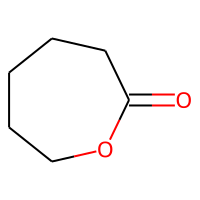
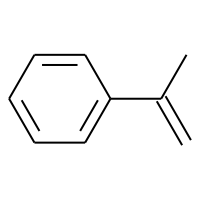
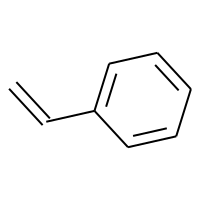
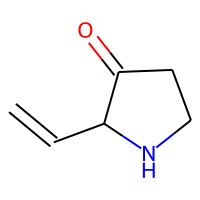
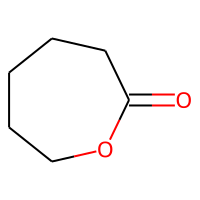
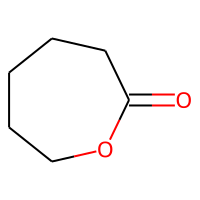
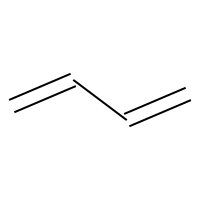
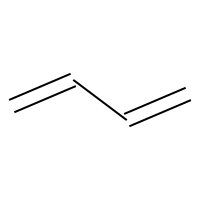
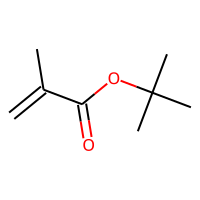
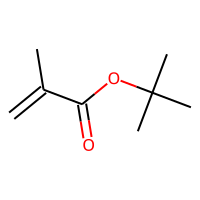
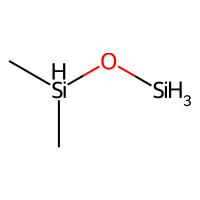
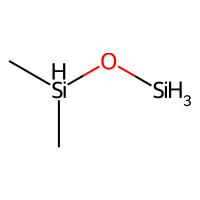
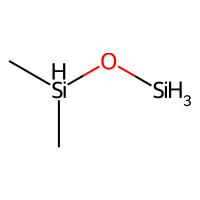
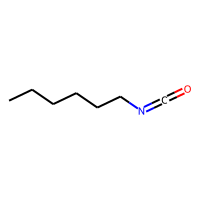
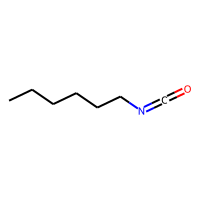
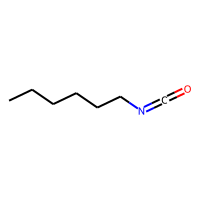
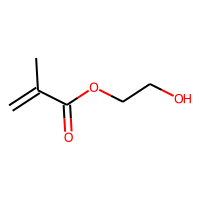
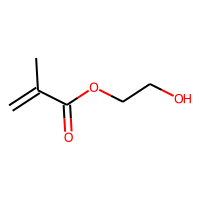
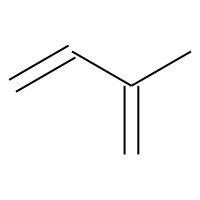
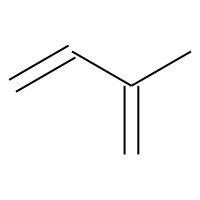
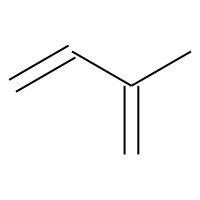
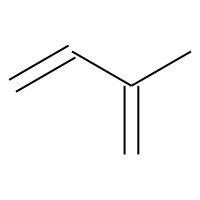
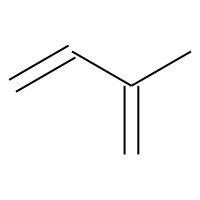
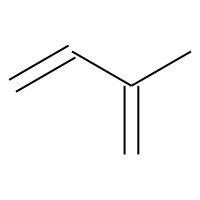
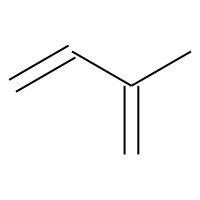
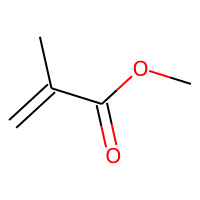
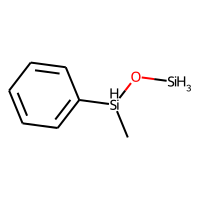
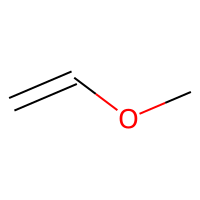
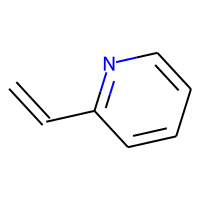
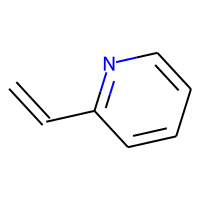
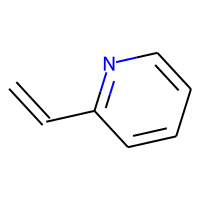
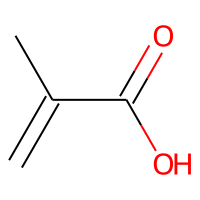
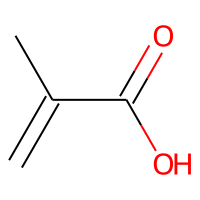
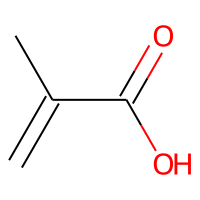
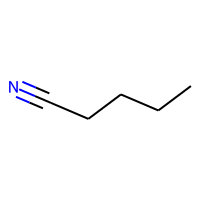
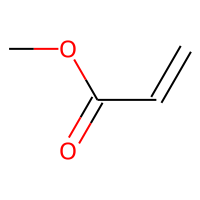
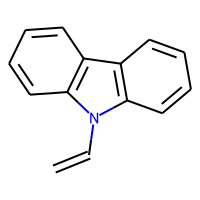
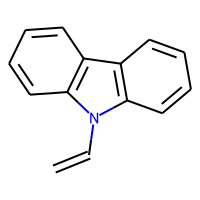
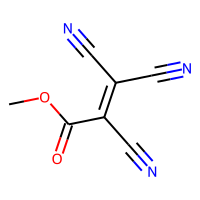
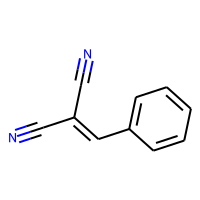
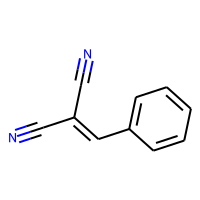
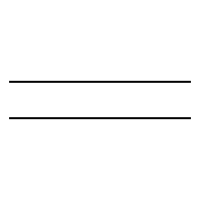
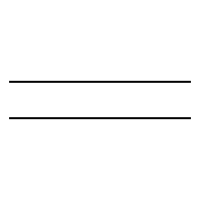
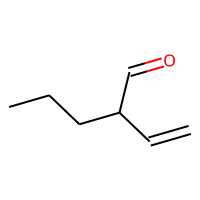
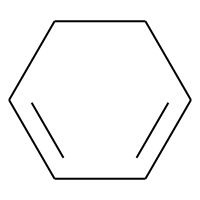
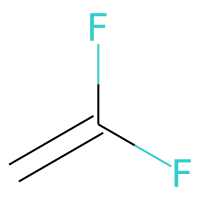
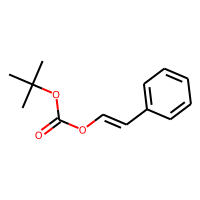
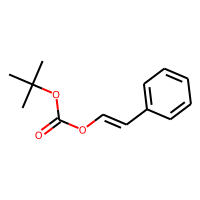
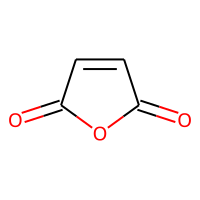
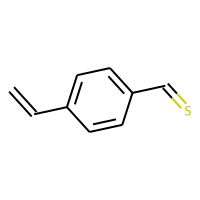
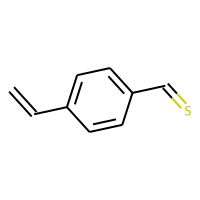
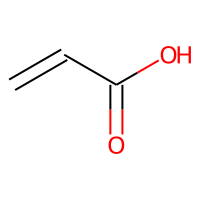
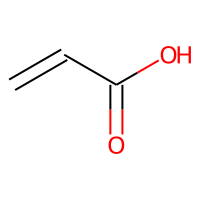
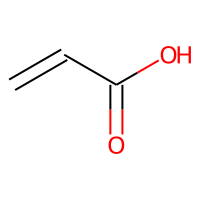
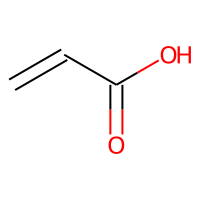
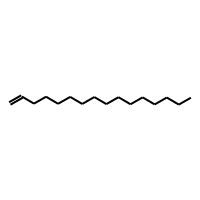
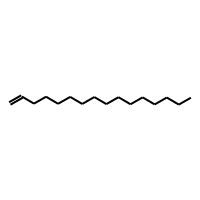
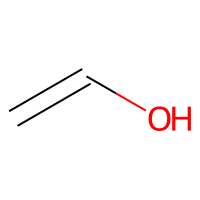
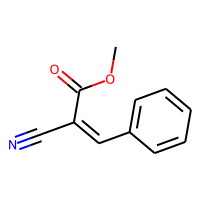
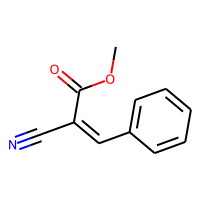
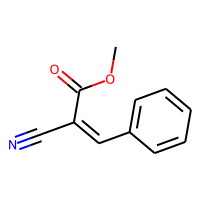
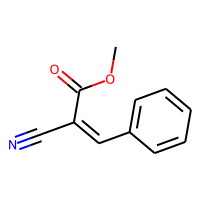
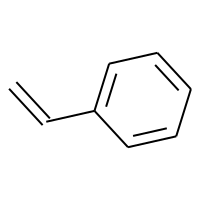
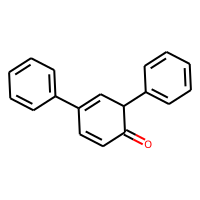
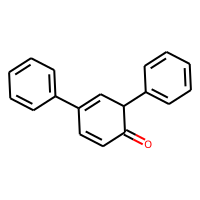
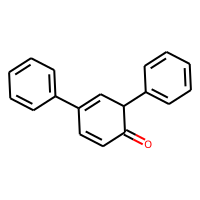
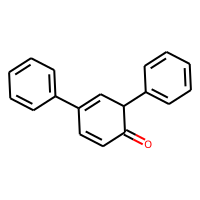
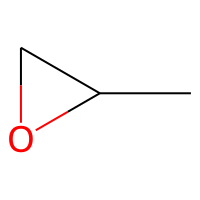
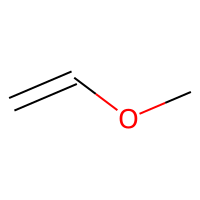
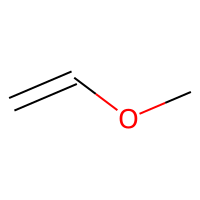
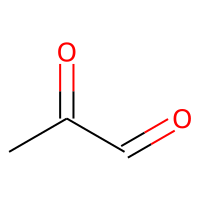
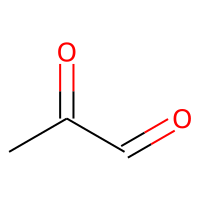
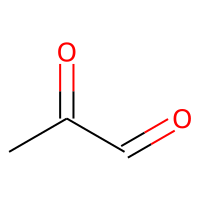
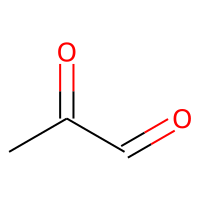
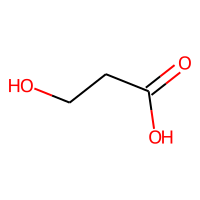
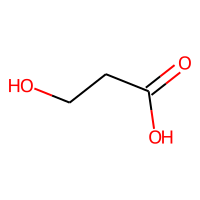
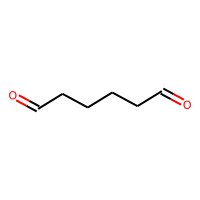
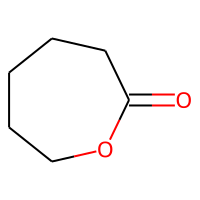
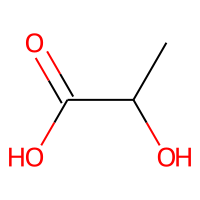
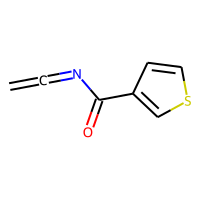
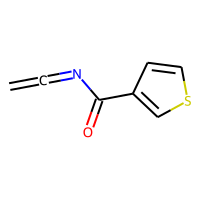
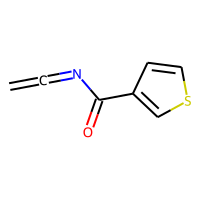
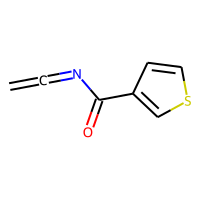
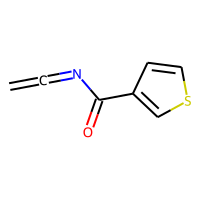
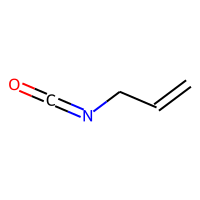
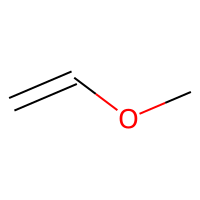
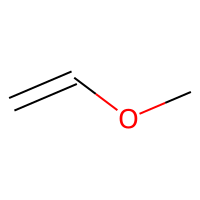
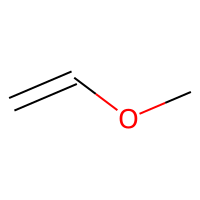
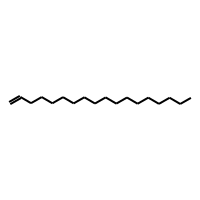
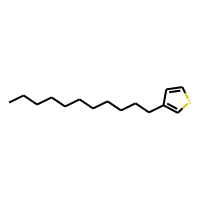
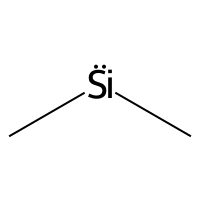
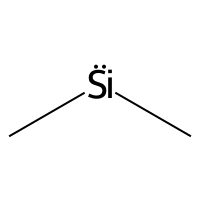
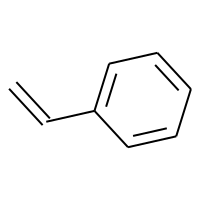
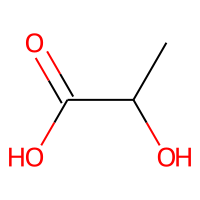
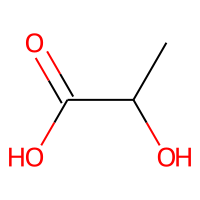
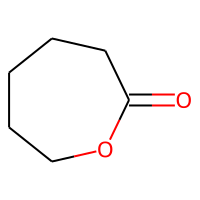
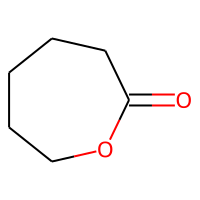
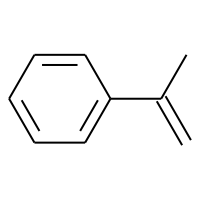
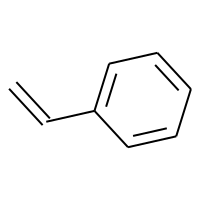
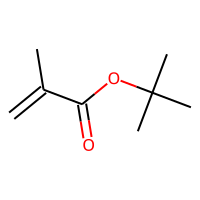
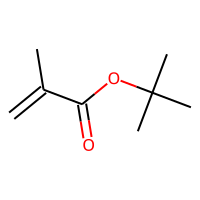
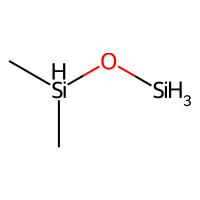
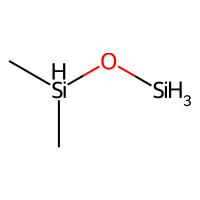
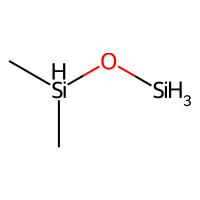
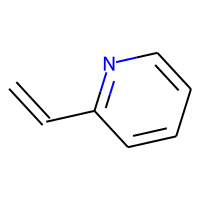
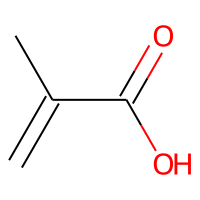
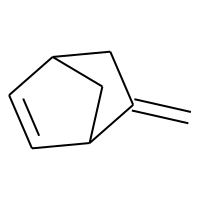
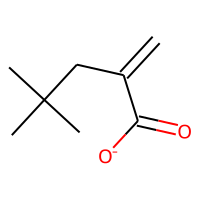
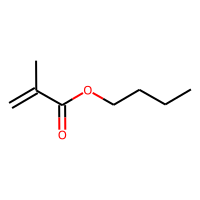
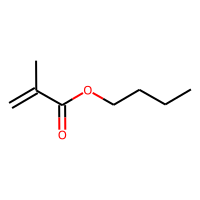
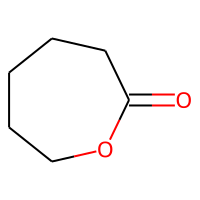
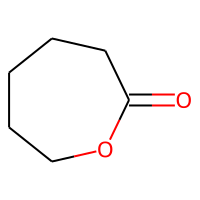
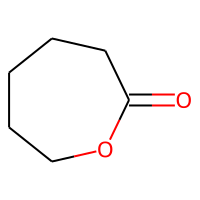
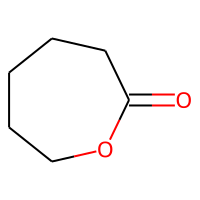
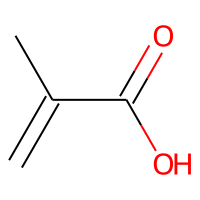
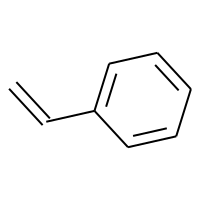
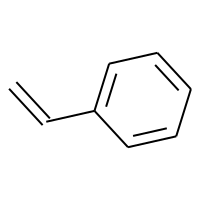
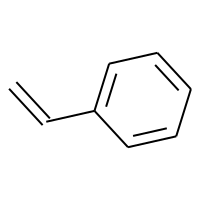
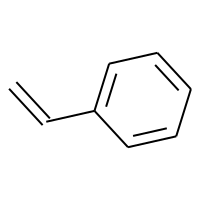
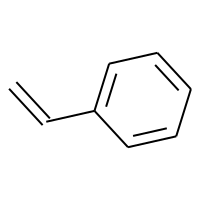
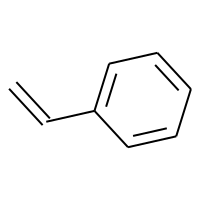
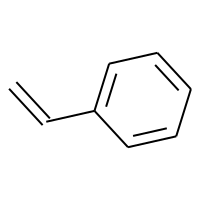
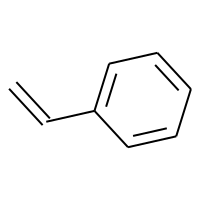
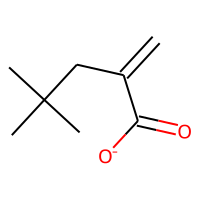
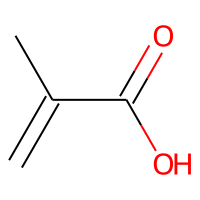
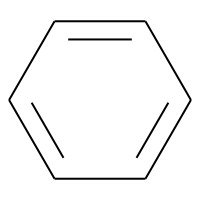
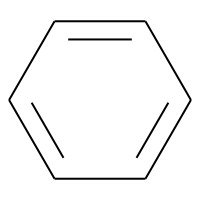
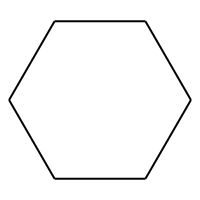
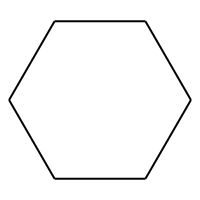
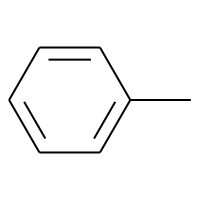
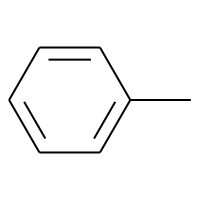
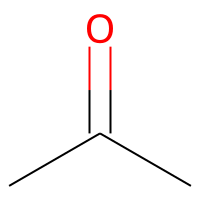
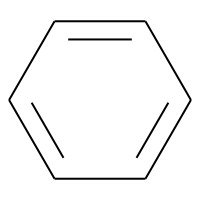
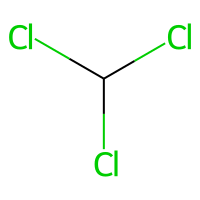
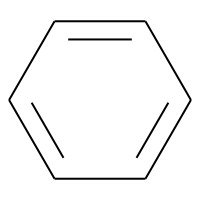
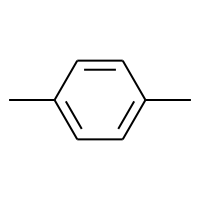
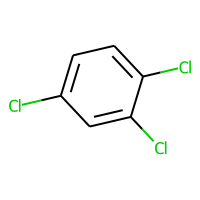
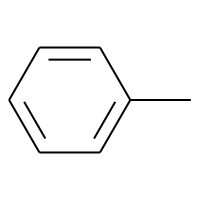
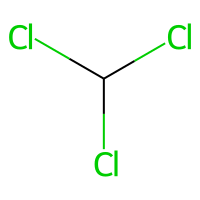
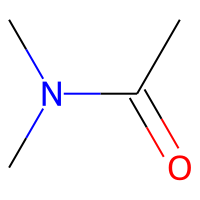
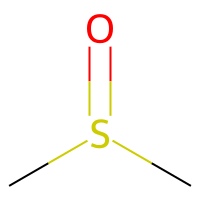
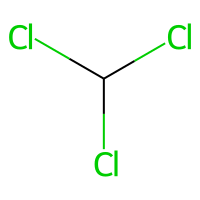
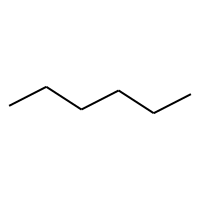
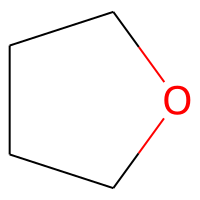
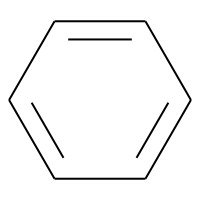
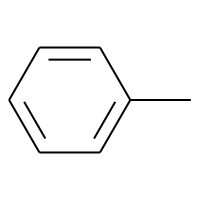
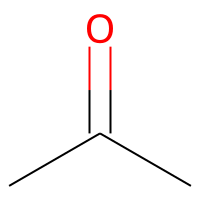
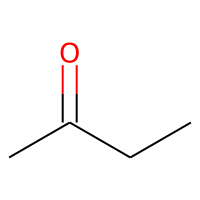
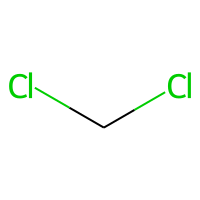
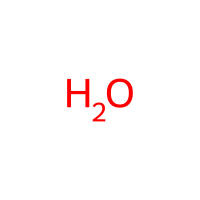
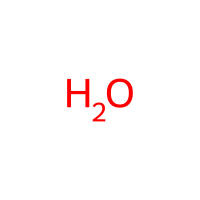
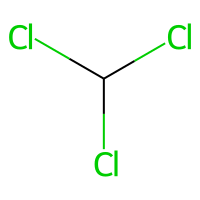
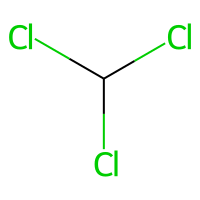
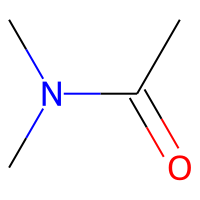
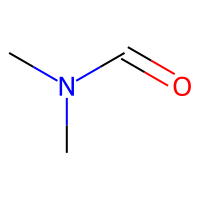
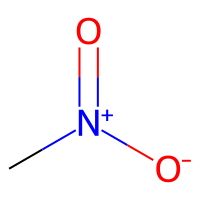
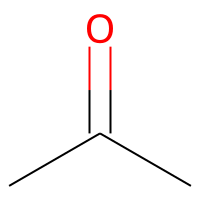
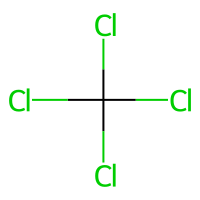
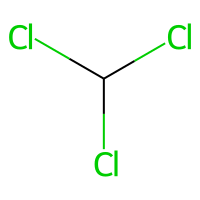
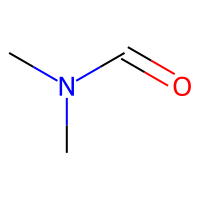
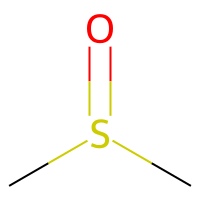
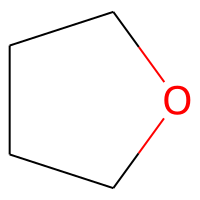
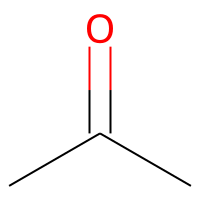
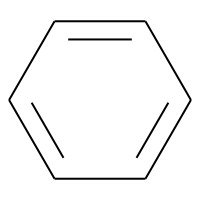
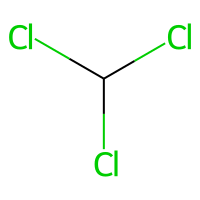
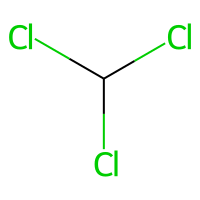
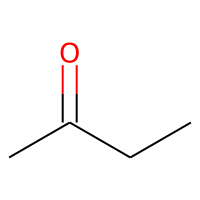
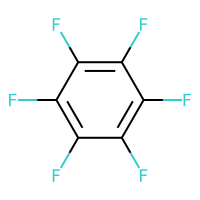
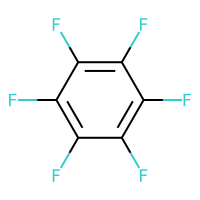
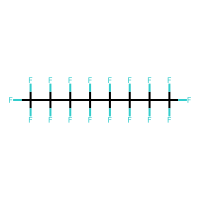
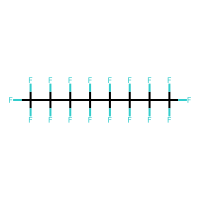
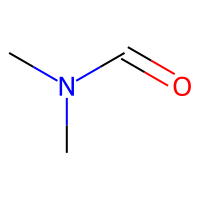
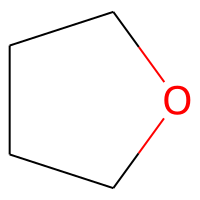
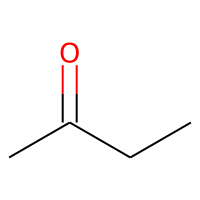
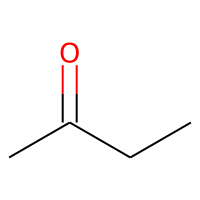
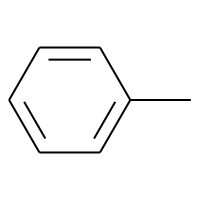
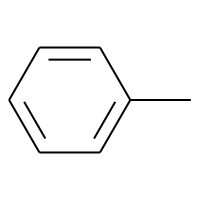
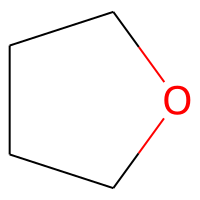
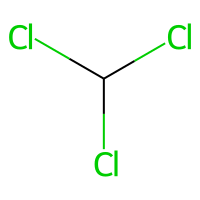
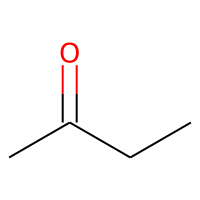
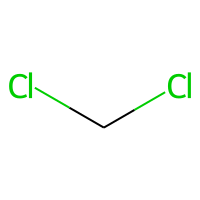
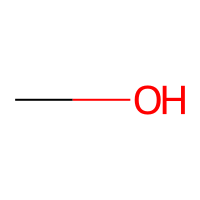
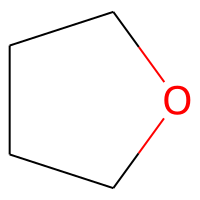
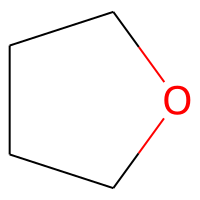
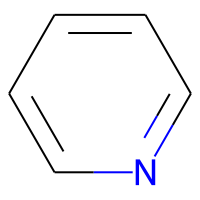
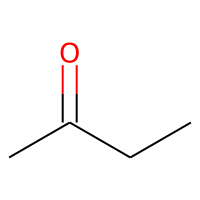
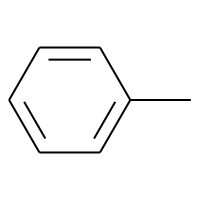
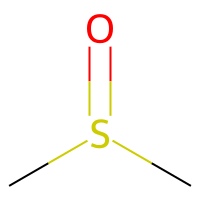
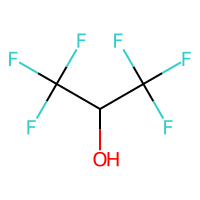
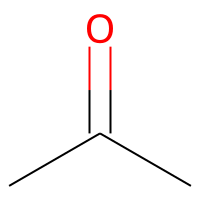
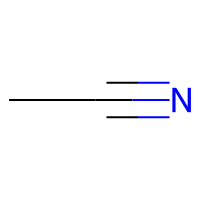
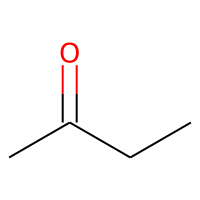
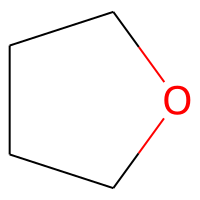
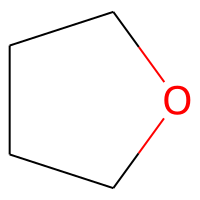
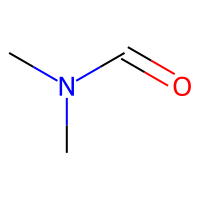
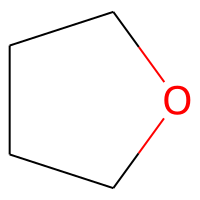
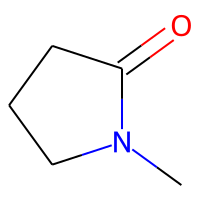
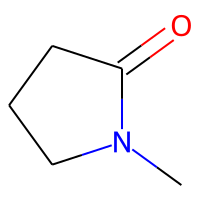
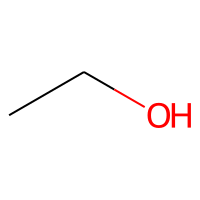
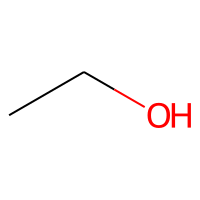
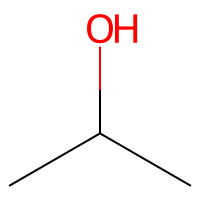
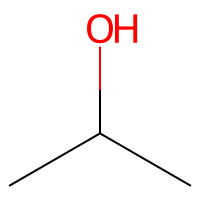
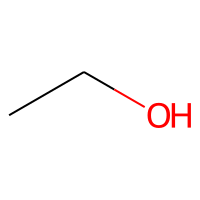
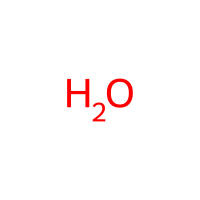
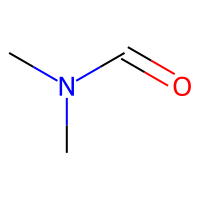
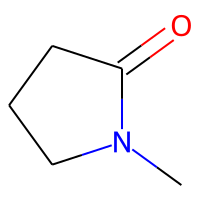
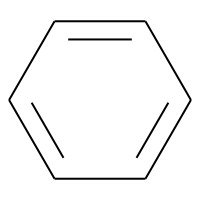
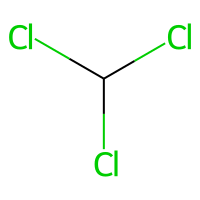
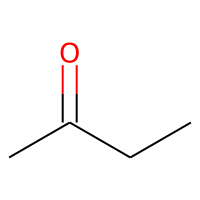
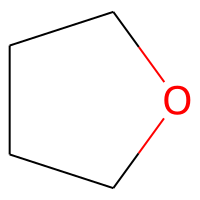
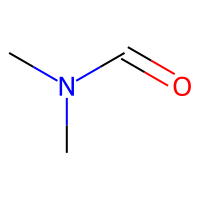
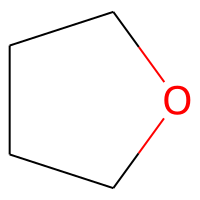
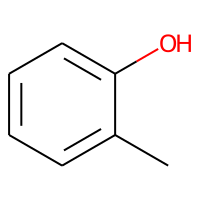
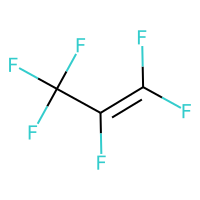
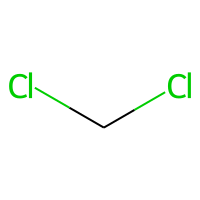
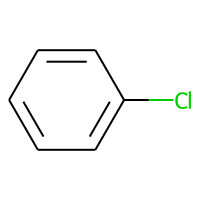
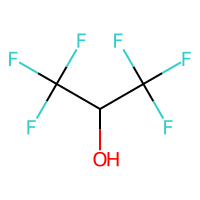
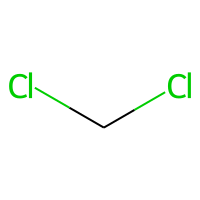
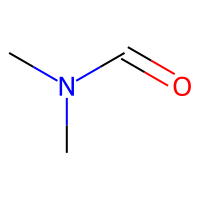
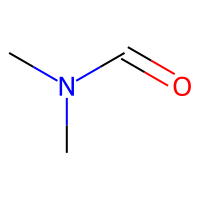
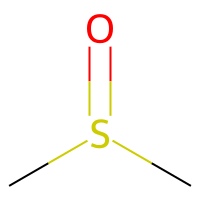
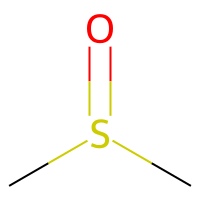
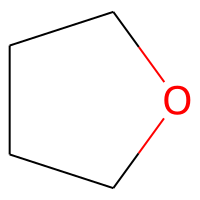
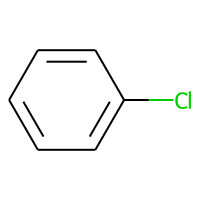
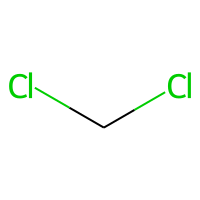
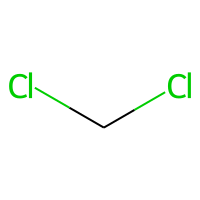
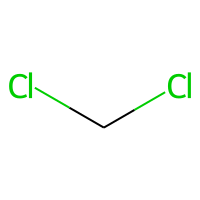
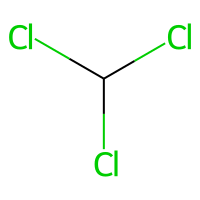
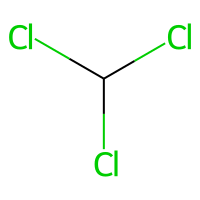
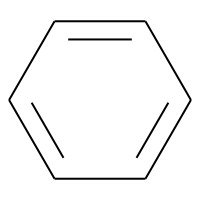
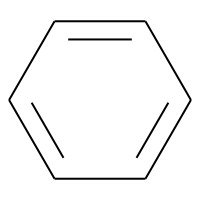
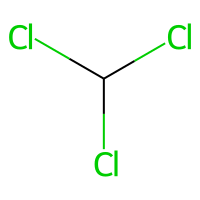
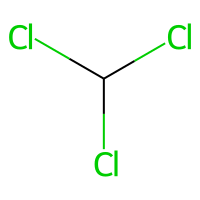
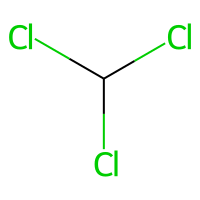
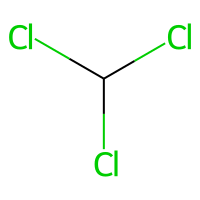
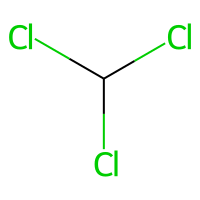
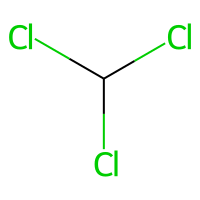
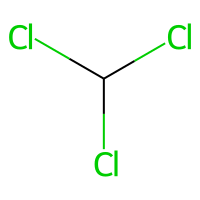
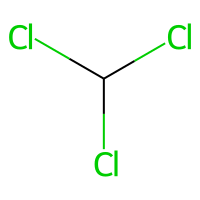
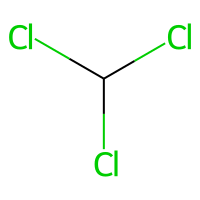
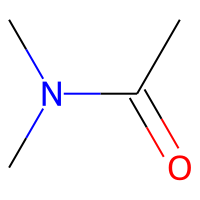
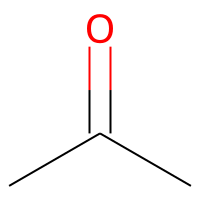
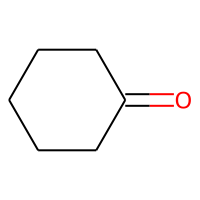
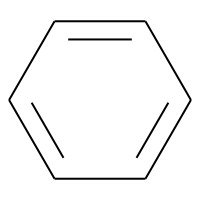
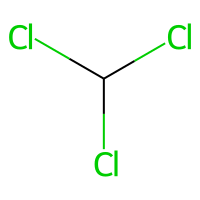
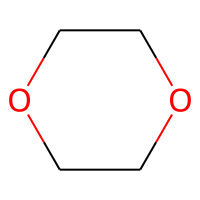
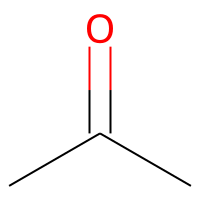
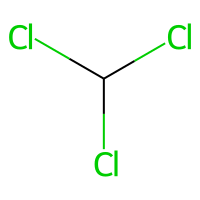
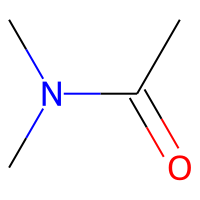
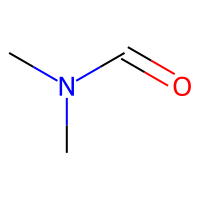
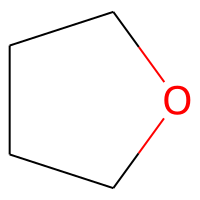
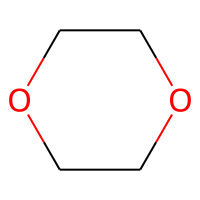
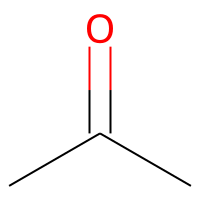
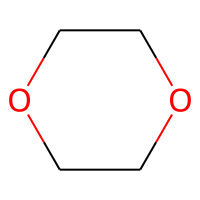
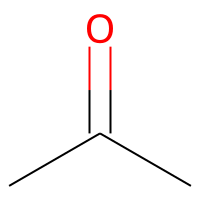
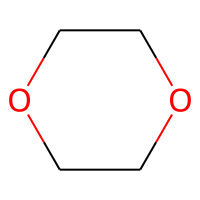
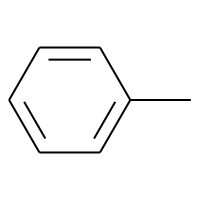
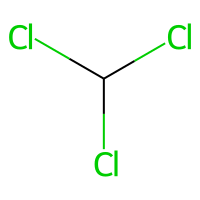
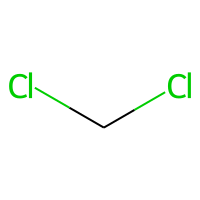
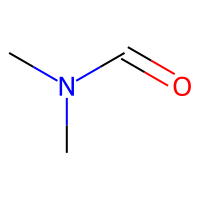
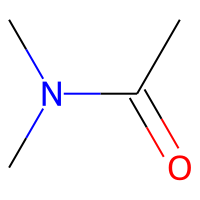
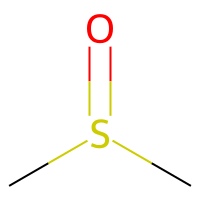
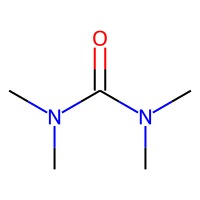
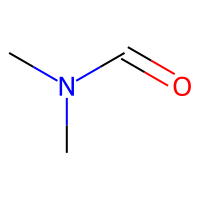
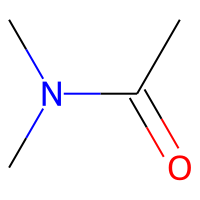
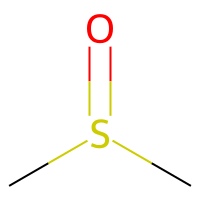
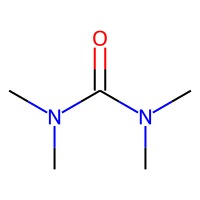
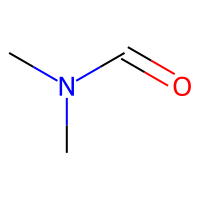
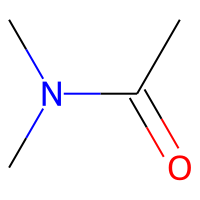
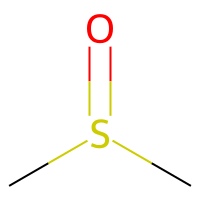
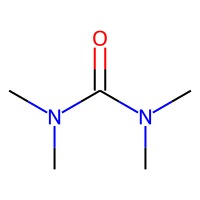
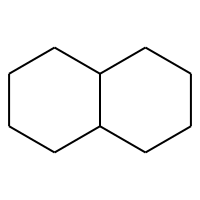
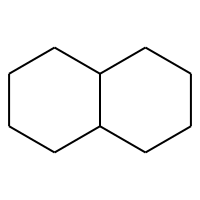
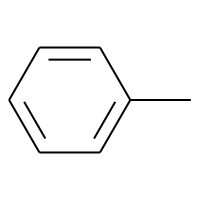
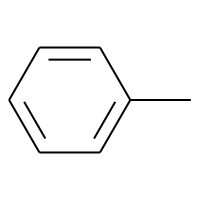
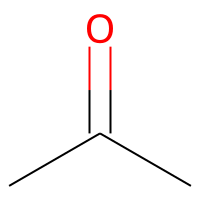
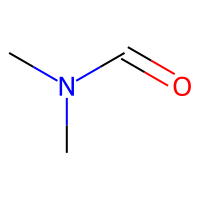
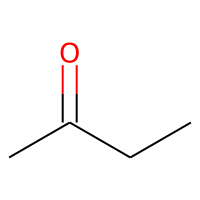
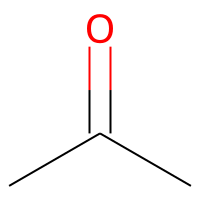
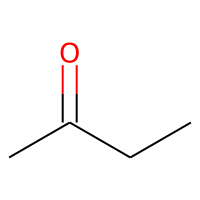
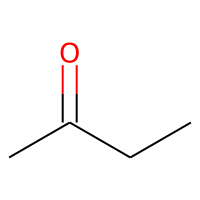
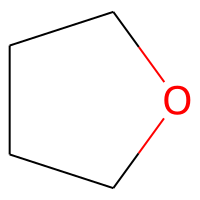
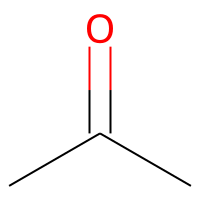
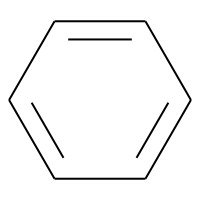
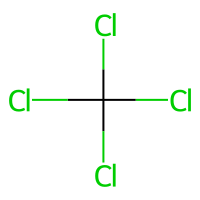
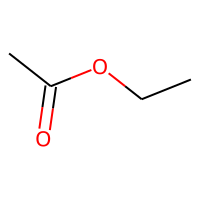
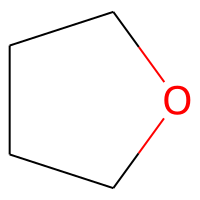
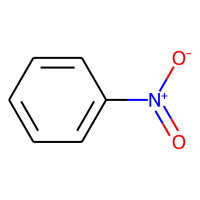
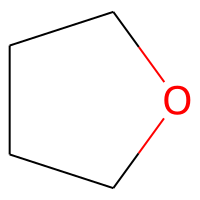
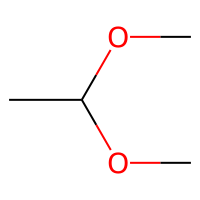
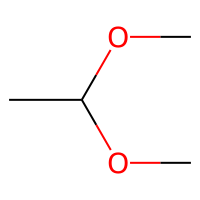
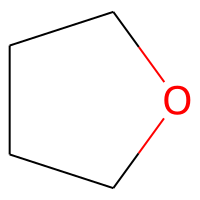
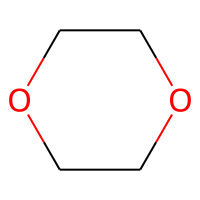
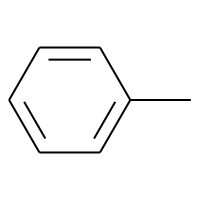
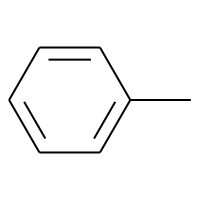
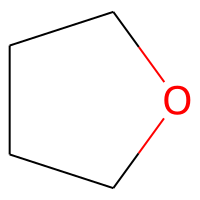
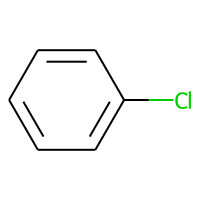
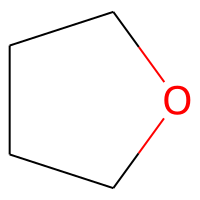
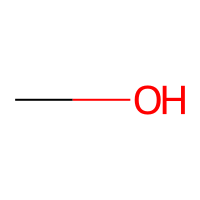
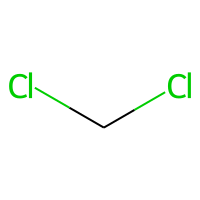
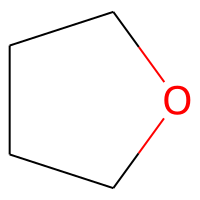
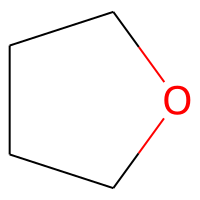
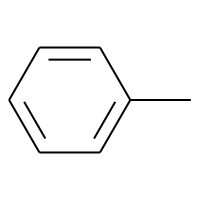
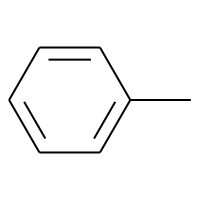
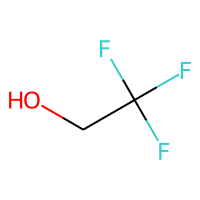
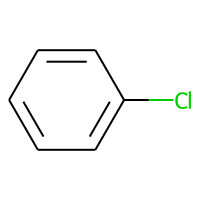
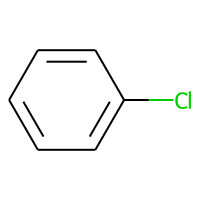
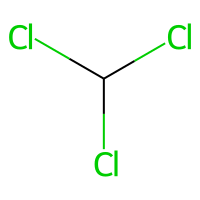
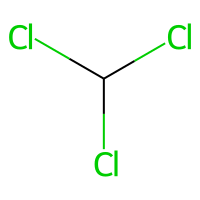
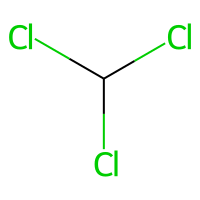
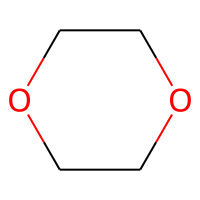
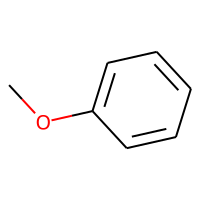
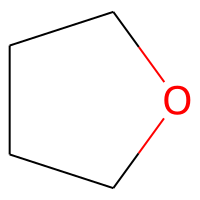
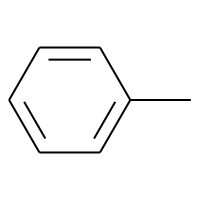
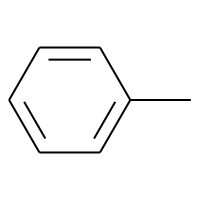
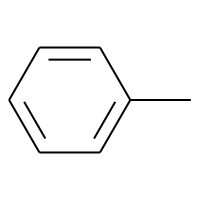
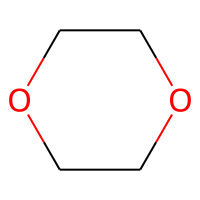
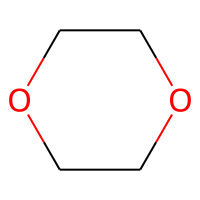
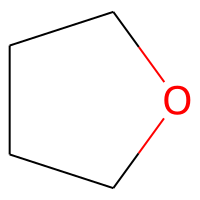
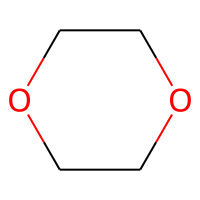
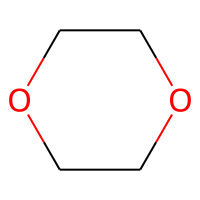
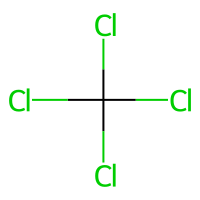
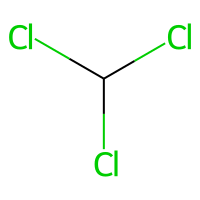
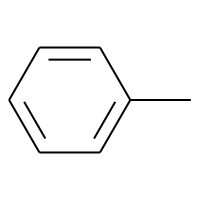
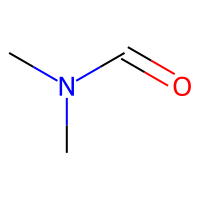
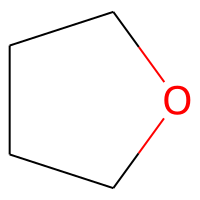
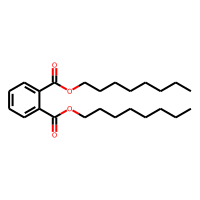
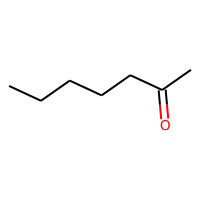
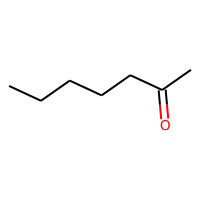
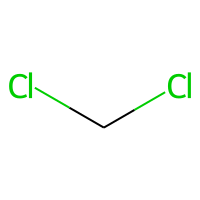
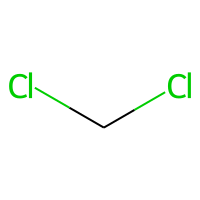
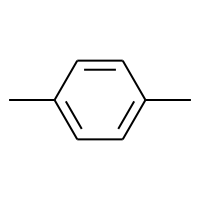
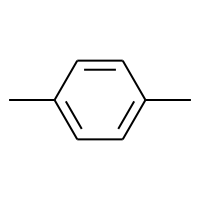
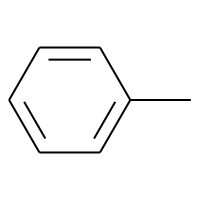
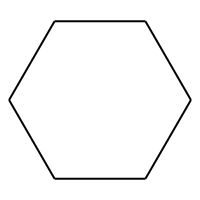
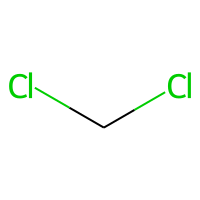
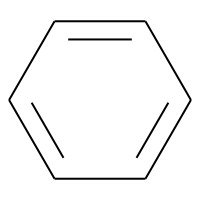
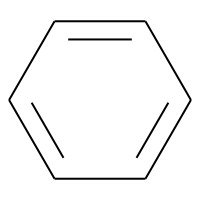
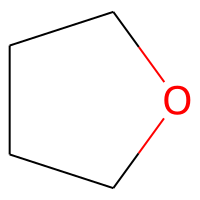
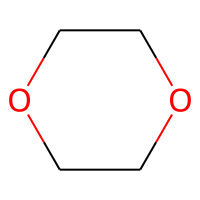
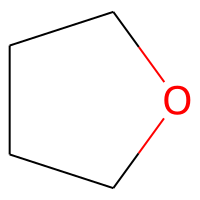
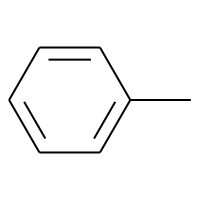
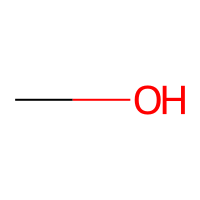
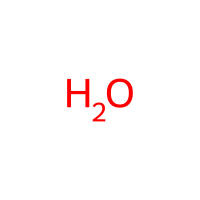
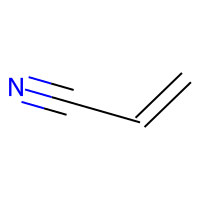
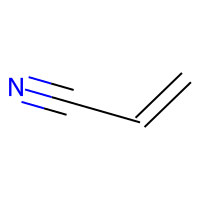
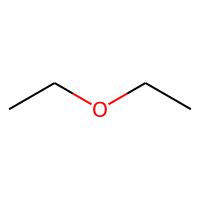
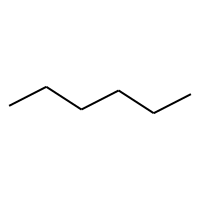
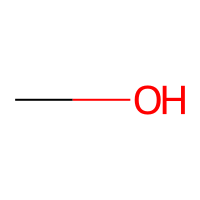
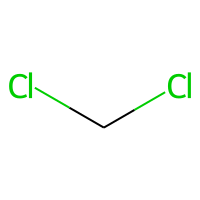
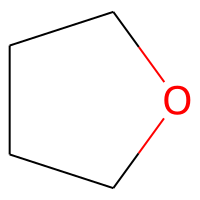
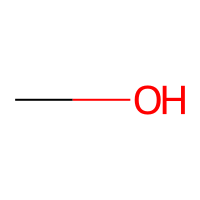
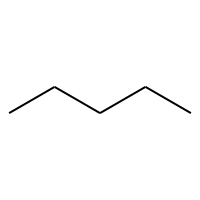
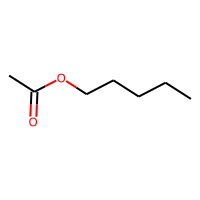
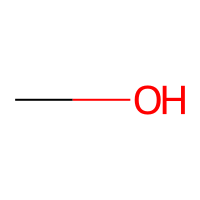
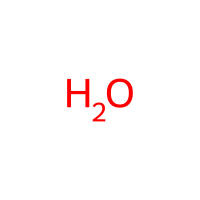
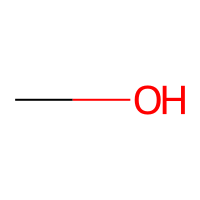
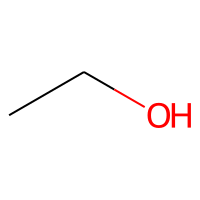
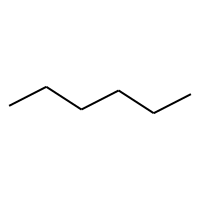
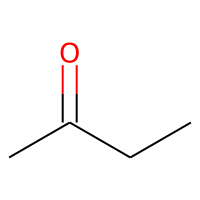
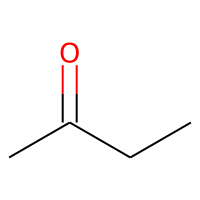
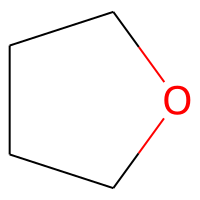
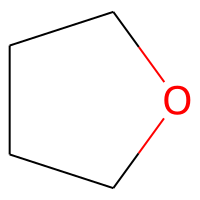
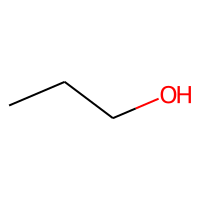
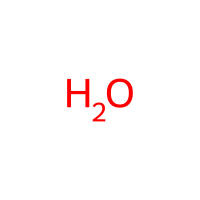
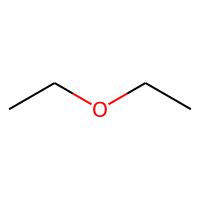
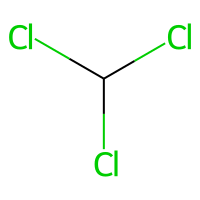
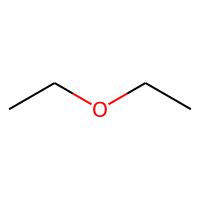
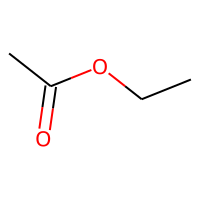
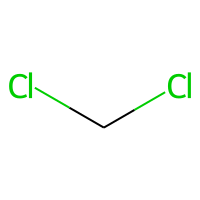
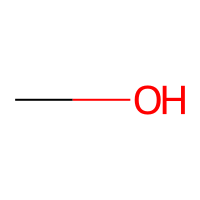
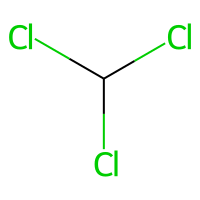
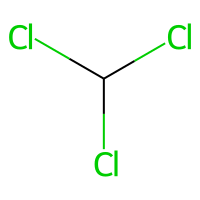
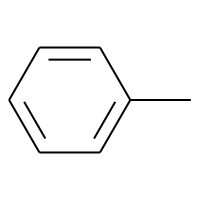
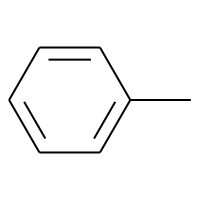
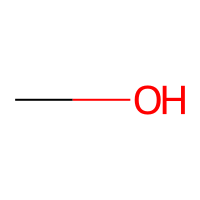
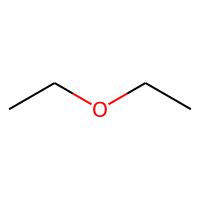
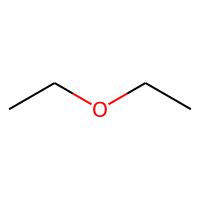
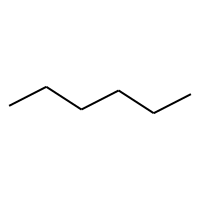
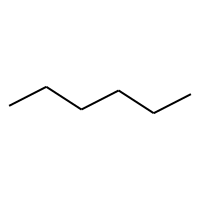
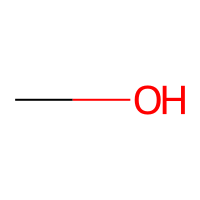
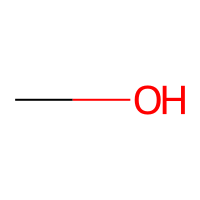
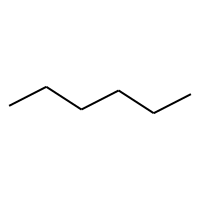
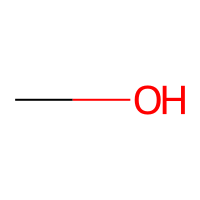
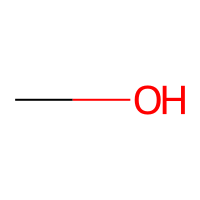
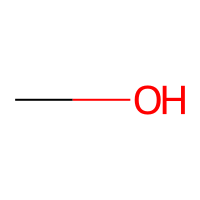
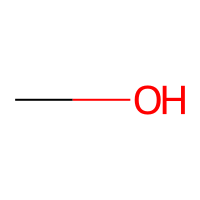
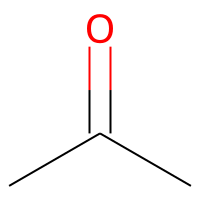
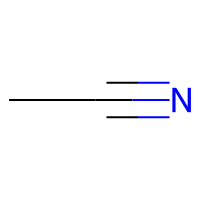
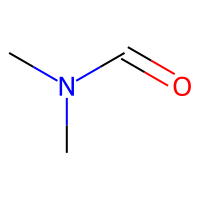
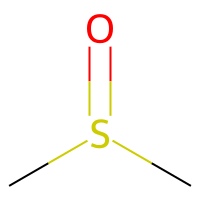
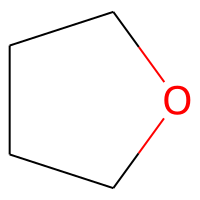
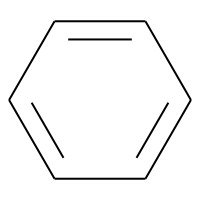
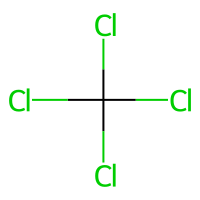
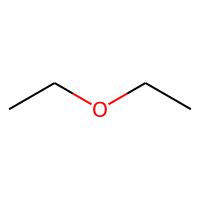
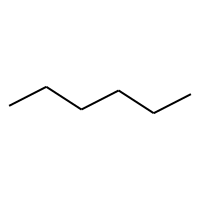
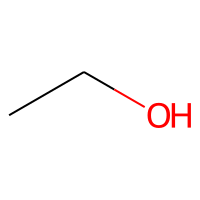
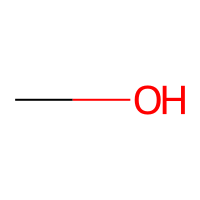
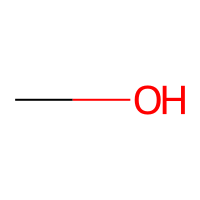
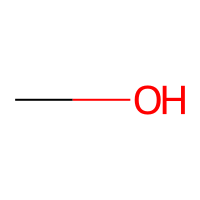
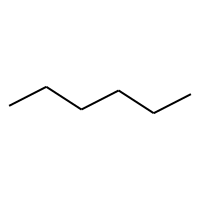
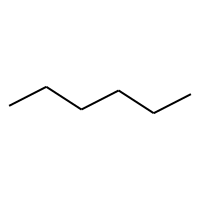
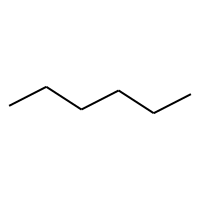
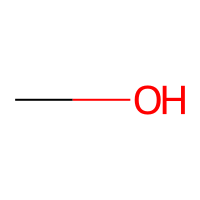
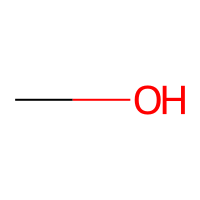
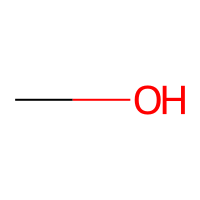
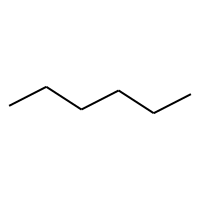
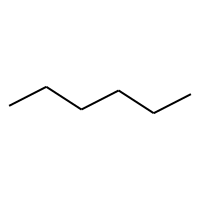
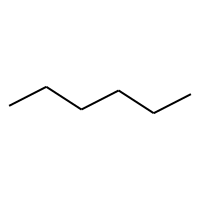
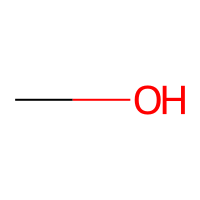
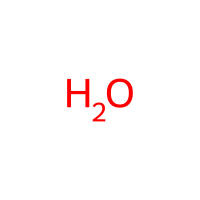
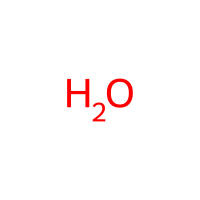
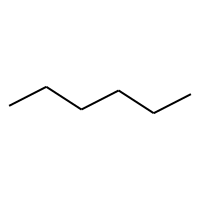
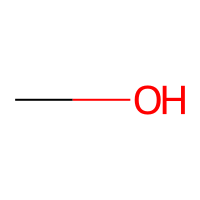

In [10]:
def get_norad_smiles(mol_lst: list, do_print: bool=False):
	
	mol_norad = clear_radical_electrons(mol_lst, print_output=do_print)
	smiles_norad = []
	for m in mol_norad:
		print(m)
		if m is np.nan:
			smiles_norad.append(np.nan)
		else:
			smiles_norad.append(Chem.MolToSmiles(m))
	return mol_norad, smiles_norad



mol_superlist_norad = []
smiles_superlist_norad = []
for i,lst in enumerate([mono1_mol, mono2_mol, mono3_mol, solv_mols]):
	print("ON LIST NO",i)
	mol_norad,smiles_norad = get_norad_smiles(lst)
	mol_superlist_norad.append(mol_norad)
	smiles_superlist_norad.append(smiles_norad)

In [11]:
mono1_mol_norad,mono2_mol_norad,mono3_mol_norad,solv_mol_norad = mol_superlist_norad
mono1_smiles_norad,mono2_smiles_norad,mono3_smiles_norad,solv_smiles_norad= smiles_superlist_norad
print(*zip(list(df.mono1_name),mono1_smiles,mono1_smiles_norad),sep='\n')

('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('butadiene', 'C=CC=C', 'C=CC=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('ethylene', 'C=C', 'C=C')
('isobutylene', 'C=C(C)C', 'C=C(C)C')
('hexene', 'C=CCCCC', 'C=CCCCC')
('vinylcyclohexane', 'C=CC1CCCCC1', 'C=CC1CCCCC1')
('methyl methacrylate', 'CC(C(OC)=O)=C', 'C=C(C)C(=O)OC')
('methyl methacrylate', 'CC(C(OC)=O)=C', 'C=C(C)C(=O)OC')
('butyl methacrylate', 'CC(C(OCCCC)=O)=C', 'C=C(C)C(=O)OCCCC')
('butyl methacrylate', 'CC(C(OCCCC)=O)=C', 'C=C(C)C(=O)OCCCC')
('butyl methacrylate', 'CC(C(OCCCC)=O)=C', 'C=C(C)C(=O)OCCCC')
('2-dimethylaminoethyl methacrylate', 'CC(C(OCCN(C)C)=O)=C', 'C=C(C)C(=O)OCCN(

In [12]:
dfnr = df.copy(deep=True)
mol_colnames = ['mono1_mol', 'mono2_mol', 'mono3_mol', 'solvent_mol'] # CAUSED AN ERROR
smiles_colnames = ['mono1_smiles', 'mono2_smiles', 'mono3_smiles', 'solvent_smiles'] # CAUSED AN ERROR
for i,colname in enumerate(mol_colnames):
	dfnr[colname] = mol_superlist_norad[i]
for i,colname in enumerate(smiles_colnames):
	dfnr[colname] = smiles_superlist_norad[i]
dfnr

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)       ['7', '3']        generic   
1                Poly(butadiene-co-styrene)      ['95', '5']        generic   
2                Poly(butadiene-co-styrene)       ['7', '3']        generic   
3                Poly(butadiene-co-styrene)      ['95', '5']        generic   
4                Poly(butadiene-co-styrene)       ['7', '3']        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)       ['1', '1']          block   
285    Polystyrene-b-poly(dimethylsiloxane)       ['1', '9']          block   
286    Polystyrene-b-poly(dimethylsiloxane)       ['3', '7']          block   
287       Polystyrene-b-poly(vinylpyridine)       ['1', '1']          block   
288  Polypropylene-b-poly(methacrylic acid)       ['2', '1']          block   

    mono1_name        mono2_name mono3_name mono1_smiles      mono2_smiles  \
0    butadiene           styrene        NaN       C=CC=C       C=Cc1ccccc1   
1    butadiene           styrene        NaN       C=CC=C       C=Cc1ccccc1   
2    butadiene           styrene        NaN       C=CC=C       C=Cc1ccccc1   
3    butadiene           styrene        NaN       C=CC=C       C=Cc1ccccc1   
4    butadiene           styrene        NaN       C=CC=C       C=Cc1ccccc1   
..         ...               ...        ...          ...               ...   
284    styrene  dimethylsiloxane        NaN  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
285    styrene  dimethylsiloxane        NaN  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
286    styrene  dimethylsiloxane        NaN  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
287    styrene     vinylpyridine        NaN  C=Cc1ccccc1       C=Cc1ccccn1   
288  propylene  methacrylic acid        NaN         C=CC      C=C(C)C(=O)O   

    mono3_smiles                                          mono1_mol  \
0            NaN  <img data-content="rdkit/molecule" src="data:i...   
1            NaN  <img data-content="rdkit/molecule" src="data:i...   
2            NaN  <img data-content="rdkit/molecule" src="data:i...   
3            NaN  <img data-content="rdkit/molecule" src="data:i...   
4            NaN  <img data-content="rdkit/molecule" src="data:i...   
..           ...                                                ...   
284          NaN  <img data-content="rdkit/molecule" src="data:i...   
285          NaN  <img data-content="rdkit/molecule" src="data:i...   
286          NaN  <img data-content="rdkit/molecule" src="data:i...   
287          NaN  <img data-content="rdkit/molecule" src="data:i...   
288          NaN  <img data-content="rdkit/molecule" src="data:i...   

                                             mono2_mol mono3_mol      solvent  \
0    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
1    <img data-content="rdkit/molecule" src="data:i...       NaN      benzene   
2    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
3    <img data-content="rdkit/molecule" src="data:i...       NaN  cyclohexane   
4    <img data-content="rdkit/molecule" src="data:i...       NaN      toluene   
..                                                 ...       ...          ...   
284  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   
285  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
286  <img data-content="rdkit/molecule" src="data:i...       NaN        Water   
287  <img data-content="rdkit/molecule" src="data:i...       NaN       hexane   
288  <img data-content="rdkit/molecule" src="data:i...       NaN     methanol   

    solvent_smiles                                        solvent_mol  \
0         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
1         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
2         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...   
3         C1CCCCC1  <img data-co

In [13]:
df_tricopolys = dfnr.loc[dfnr['mono3_name'].notna(),:]
df_dicopoly = dfnr.loc[dfnr['mono3_name'].isna(),:]
df_dicopoly = df_dicopoly.drop(['mono3_name','mono3_smiles','mono3_mol'], axis=1)

mono1_smi_norad_dicopoly = list(df_dicopoly.mono1_smiles)
mono1_mol_norad_dicopoly = list(df_dicopoly.mono1_mol)
mono2_smi_norad_dicopoly = list(df_dicopoly.mono2_smiles)
mono2_mol_norad_dicopoly = list(df_dicopoly.mono2_mol)

smiles_superlist_nr_dicopoly = [list(df_dicopoly.mono1_smiles),list(df_dicopoly.mono2_smiles),list(df_dicopoly.solvent_smiles)]
mol_superlist_nr_dicopoly = [list(df_dicopoly.mono1_mol),list(df_dicopoly.mono2_mol),list(df_dicopoly.solvent_mol)]

dfdc = df_dicopoly
dfdc = dfdc.dropna(subset=('mono1_smiles'))
dfdc = dfdc.dropna(subset=('mono2_smiles'))


In [15]:
print([x for x in list(dfdc.comonomer_ratios)])
display(dfdc)

def convert_str_int_list(lst):
	"""Converts a string list of numbers to a proper int list."""
	out_lst = []
	for i,string_val in enumerate(lst):
		tmp = string_val.strip('][')
		tmp = tmp.replace("'","")
		tmp = tmp.split(',')
		print(tmp)
		for i,val in enumerate(tmp):
			try:
				tmp[i] = int(val)
			except:
				if val.count('<') > 0:
					print("WARNING: Less than ratio found. Replacing with upper bound",val)
					tmp[i] = int(val.replace('<',''))
				elif val.count('>') > 0:
					print("WARNING: Greater than ratio found.")
				else:
					print("WARNING: Could not interpet as int",val)
		print("New Temp:",tmp)
		out_lst.append(tmp)
	return out_lst
if type(dfdc.at[0, 'comonomer_ratios']) == str:
	dfdc.comonomer_ratios = convert_str_int_list(list(dfdc.comonomer_ratios))

print([x for x in list(dfdc.comonomer_ratios)])
display(dfdc)



[[7, 3], [95, 5], [7, 3], [95, 5], [7, 3], [95, 5], [1, 1], [1, 1], [1, 1], [3, 2], [6, 1], [97, 3], [1, 2], [1, 2], [1, 2], [95, 5], [2, 3], [9, 1], [95, 5], [95, 5], [1, 1], [1, 1], [1, 1], [4, 1], [3, 2], [15, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [3, 1], [13, 87], [35, 65], [13, 87], [35, 65], [98, 2], [1, 1], [2, 3], [4, 1], [2, 3], [4, 1], [94, 6], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [4, 5], [4, 5], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [95, 5], [1, 1], [1, 1], [3, 1], [3, 1], [1, 4], [2, 3], [1, 4], [2, 3], [13, 1], [1, 1], [1, 1], [1, 1], [7, 3], [7, 3], [7, 3], [7, 3], [3, 2], [3, 2], [7, 3], [7, 3], [7, 3], [1, 1], [1, 1], [1, 1], [13, 87], [38, 62], [13, 87], [38, 62], [1, 1], [9, 1], [9, 1], [9, 1], [1, 1], [9, 1], [9, 1], [1, 2], [1, 4], [1, 1], [1, 0], [1, 3], [1, 1], [1, 1], [1, 1], [3, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 3], [1,

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)           [7, 3]        generic   
1                Poly(butadiene-co-styrene)          [95, 5]        generic   
2                Poly(butadiene-co-styrene)           [7, 3]        generic   
3                Poly(butadiene-co-styrene)          [95, 5]        generic   
4                Poly(butadiene-co-styrene)           [7, 3]        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)           [1, 1]          block   
285    Polystyrene-b-poly(dimethylsiloxane)           [1, 9]          block   
286    Polystyrene-b-poly(dimethylsiloxane)           [3, 7]          block   
287       Polystyrene-b-poly(vinylpyridine)           [1, 1]          block   
288  Polypropylene-b-poly(methacrylic acid)           [2, 1]          block   

    mono1_name        mono2_name mono1_smiles      mono2_smiles  \
0    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
1    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
2    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
3    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
4    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
..         ...               ...          ...               ...   
284    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
285    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
286    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
287    styrene     vinylpyridine  C=Cc1ccccc1       C=Cc1ccccn1   
288  propylene  methacrylic acid         C=CC      C=C(C)C(=O)O   

                                             mono1_mol  \
0    <img data-content="rdkit/molecule" src="data:i...   
1    <img data-content="rdkit/molecule" src="data:i...   
2    <img data-content="rdkit/molecule" src="data:i...   
3    <img data-content="rdkit/molecule" src="data:i...   
4    <img data-content="rdkit/molecule" src="data:i...   
..                                                 ...   
284  <img data-content="rdkit/molecule" src="data:i...   
285  <img data-content="rdkit/molecule" src="data:i...   
286  <img data-content="rdkit/molecule" src="data:i...   
287  <img data-content="rdkit/molecule" src="data:i...   
288  <img data-content="rdkit/molecule" src="data:i...   

                                             mono2_mol      solvent  \
0    <img data-content="rdkit/molecule" src="data:i...      benzene   
1    <img data-content="rdkit/molecule" src="data:i...      benzene   
2    <img data-content="rdkit/molecule" src="data:i...  cyclohexane   
3    <img data-content="rdkit/molecule" src="data:i...  cyclohexane   
4    <img data-content="rdkit/molecule" src="data:i...      toluene   
..                                                 ...          ...   
284  <img data-content="rdkit/molecule" src="data:i...     methanol   
285  <img data-content="rdkit/molecule" src="data:i...        Water   
286  <img data-content="rdkit/molecule" src="data:i...        Water   
287  <img data-content="rdkit/molecule" src="data:i...       hexane   
288  <img data-content="rdkit/molecule" src="data:i...     methanol   

    solvent_smiles                                        solvent_mol  \
0         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
1         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
2         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...   
3         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...   
4        Cc1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
..             ...                                                ...   
284             CO  <img data-content="rdkit/molecule" src="data:i...   
285              O  <img data-content="rdkit/molecule" src="data:i...   
286              O  <img data-content="rdkit/molecule" src="data:i...   
28

[[7, 3], [95, 5], [7, 3], [95, 5], [7, 3], [95, 5], [1, 1], [1, 1], [1, 1], [3, 2], [6, 1], [97, 3], [1, 2], [1, 2], [1, 2], [95, 5], [2, 3], [9, 1], [95, 5], [95, 5], [1, 1], [1, 1], [1, 1], [4, 1], [3, 2], [15, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [3, 1], [13, 87], [35, 65], [13, 87], [35, 65], [98, 2], [1, 1], [2, 3], [4, 1], [2, 3], [4, 1], [94, 6], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [4, 5], [4, 5], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [95, 5], [1, 1], [1, 1], [3, 1], [3, 1], [1, 4], [2, 3], [1, 4], [2, 3], [13, 1], [1, 1], [1, 1], [1, 1], [7, 3], [7, 3], [7, 3], [7, 3], [3, 2], [3, 2], [7, 3], [7, 3], [7, 3], [1, 1], [1, 1], [1, 1], [13, 87], [38, 62], [13, 87], [38, 62], [1, 1], [9, 1], [9, 1], [9, 1], [1, 1], [9, 1], [9, 1], [1, 2], [1, 4], [1, 1], [1, 0], [1, 3], [1, 1], [1, 1], [1, 1], [3, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 3], [1,

polymer comonomer_ratios copolymer_type  \
0                Poly(butadiene-co-styrene)           [7, 3]        generic   
1                Poly(butadiene-co-styrene)          [95, 5]        generic   
2                Poly(butadiene-co-styrene)           [7, 3]        generic   
3                Poly(butadiene-co-styrene)          [95, 5]        generic   
4                Poly(butadiene-co-styrene)           [7, 3]        generic   
..                                      ...              ...            ...   
284    Polystyrene-b-poly(dimethylsiloxane)           [1, 1]          block   
285    Polystyrene-b-poly(dimethylsiloxane)           [1, 9]          block   
286    Polystyrene-b-poly(dimethylsiloxane)           [3, 7]          block   
287       Polystyrene-b-poly(vinylpyridine)           [1, 1]          block   
288  Polypropylene-b-poly(methacrylic acid)           [2, 1]          block   

    mono1_name        mono2_name mono1_smiles      mono2_smiles  \
0    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
1    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
2    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
3    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
4    butadiene           styrene       C=CC=C       C=Cc1ccccc1   
..         ...               ...          ...               ...   
284    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
285    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
286    styrene  dimethylsiloxane  C=Cc1ccccc1  C[SiH](C)O[SiH3]   
287    styrene     vinylpyridine  C=Cc1ccccc1       C=Cc1ccccn1   
288  propylene  methacrylic acid         C=CC      C=C(C)C(=O)O   

                                             mono1_mol  \
0    <img data-content="rdkit/molecule" src="data:i...   
1    <img data-content="rdkit/molecule" src="data:i...   
2    <img data-content="rdkit/molecule" src="data:i...   
3    <img data-content="rdkit/molecule" src="data:i...   
4    <img data-content="rdkit/molecule" src="data:i...   
..                                                 ...   
284  <img data-content="rdkit/molecule" src="data:i...   
285  <img data-content="rdkit/molecule" src="data:i...   
286  <img data-content="rdkit/molecule" src="data:i...   
287  <img data-content="rdkit/molecule" src="data:i...   
288  <img data-content="rdkit/molecule" src="data:i...   

                                             mono2_mol      solvent  \
0    <img data-content="rdkit/molecule" src="data:i...      benzene   
1    <img data-content="rdkit/molecule" src="data:i...      benzene   
2    <img data-content="rdkit/molecule" src="data:i...  cyclohexane   
3    <img data-content="rdkit/molecule" src="data:i...  cyclohexane   
4    <img data-content="rdkit/molecule" src="data:i...      toluene   
..                                                 ...          ...   
284  <img data-content="rdkit/molecule" src="data:i...     methanol   
285  <img data-content="rdkit/molecule" src="data:i...        Water   
286  <img data-content="rdkit/molecule" src="data:i...        Water   
287  <img data-content="rdkit/molecule" src="data:i...       hexane   
288  <img data-content="rdkit/molecule" src="data:i...     methanol   

    solvent_smiles                                        solvent_mol  \
0         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
1         c1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
2         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...   
3         C1CCCCC1  <img data-content="rdkit/molecule" src="data:i...   
4        Cc1ccccc1  <img data-content="rdkit/molecule" src="data:i...   
..             ...                                                ...   
284             CO  <img data-content="rdkit/molecule" src="data:i...   
285              O  <img data-content="rdkit/molecule" src="data:i...   
286              O  <img data-content="rdkit/molecule" src="data:i...   
28

Write dfdc to file

In [16]:
dfdc.to_pickle(pkl_path/r"df_dicopoly_norad.pkl")
dfdc.drop(columns=["mono1_mol", "mono2_mol", "solvent_mol"]).to_csv(csv_path/r"df_dicopoly_norad.csv")

In [18]:
copoly_to_num = {
    'generic':0,
    'block':1,
    'alternating':2}
copoly_types_num = [copoly_to_num[x] for x in dfdc.copolymer_type]
mono1_ratios = [x[0] for x in dfdc.comonomer_ratios]
mono2_ratios = [x[1] for x in dfdc.comonomer_ratios]
print("Type mono1_ratios[0]",type(mono1_ratios[0]),mono1_ratios[0])
df_ratios_type = pd.DataFrame([mono1_ratios,mono2_ratios,copoly_types_num]).T
df_ratios_type.columns = ['mono1_ratio','mono2_ratio','copolymer_type']
df_ratios_type

Type mono1_ratios[0] <class 'int'> 7


mono1_ratio  mono2_ratio  copolymer_type
0              7            3               0
1             95            5               0
2              7            3               0
3             95            5               0
4              7            3               0
..           ...          ...             ...
265            1            1               1
266            1            9               1
267            3            7               1
268            1            1               1
269            2            1               1

[270 rows x 3 columns]

### Generate Descriptors

#### Descriptor Cleanup

In [19]:
#* Check if column is all zero, Get Column Statistics
def get_col_non_zero_percent(df, print_extra: bool=False, percent_cutoff: float=1.0):
	print("BEFORE NON ZERO DROPS",df.shape)
	non_zero_lst = []
	for col_name in df.columns:
		if (type(df[col_name][0])) == np.ndarray:
			print(col_name,"is array")
		elif (df[col_name] == 0).all():
			print("ALL ZERO",col_name)
		val_counts = df[col_name].value_counts()

		zero_counts = val_counts.index.isin([0.0])
		non_zero_counts = val_counts[~zero_counts]
		sum_val_counts = val_counts.sum()
		sum_nonzero_counts = non_zero_counts.sum()
		num_zero_counts = sum_val_counts - sum_nonzero_counts
		percent_non_zero = (sum_nonzero_counts/sum_val_counts)*100
		#! Added: Remove col if < cutoff
		if percent_non_zero < percent_cutoff:
			print(f"Dropped {col_name} as it was less than cutoff of {percent_cutoff}: {percent_non_zero}")
			df.drop(columns=col_name, axis=1, inplace=True)
			continue

		non_zero_lst.append((col_name,percent_non_zero))
		if print_extra == True:
			print(col_name)
			display(val_counts)
			display(zero_counts)
			display(non_zero_counts)
			print("TOTAL SUM",sum_val_counts)
			print("NON-ZERO COUNTS",sum_nonzero_counts)
			print("ZERO COUNTS",num_zero_counts)
			print("\n{} is {:2.2f} % non-zero \n\n".format(col_name,percent_non_zero))
	print("AFTER NON ZERO DROPS",df.shape)
	return non_zero_lst

#### Gen MorganFP

In [20]:
gen_fingerprints = True
write_fps_to_file = True
n_fp_bits = 32768

In [21]:
def gen_morgan_fp(smiles_list, fp_radius: int=3, num_bits: int=2048, display_smi_num: int=None, num_bits_display: int=None):
	mol_list = []
	for smi in smiles_list:
		if smi is np.nan:
			mol_list.append(np.nan)
		elif type(smi) == float:
			print("Warning: Float detected in Smiles",smi)
		else:
			mol_list.append(Chem.MolFromSmiles(smi))
		
	mfp_list = []
	for mol in mol_list:
		bit_dict = {}
		if mol is np.nan:
			mfp = np.nan
		elif mol is not None:
			mfp = AllChem.GetMorganFingerprintAsBitVect(mol, nBits=num_bits, radius=fp_radius, bitInfo=bit_dict, useFeatures=True) #added features
		else:
			mfp = np.nan
		if mol_list.index(mol) == display_smi_num:
			bit_tuples_list = []
			for bit_num,values in bit_dict.items():
				bit_tuples_list.append((mol,bit_num,bit_dict))
			multi_bits_img = Draw.DrawMorganBits(bit_tuples_list, useSVG=True)
			display(mol)
			display(multi_bits_img)
		mfp_list.append(mfp)

	return mfp_list

Generate MFP for dicopoly

In [22]:

n_fp_bits = 32768
gen_fingerprints = True
if gen_fingerprints == True:
	mfp_superlist = []
	for smi_lst in smiles_superlist_nr_dicopoly:
		tmp = gen_morgan_fp(smi_lst, 3, n_fp_bits) 

		tmp = [np.array(x, dtype=np.intc) for x in tmp]
		mfp_superlist.append(tmp)

	if not {'mono1_morgan_fp', 'mono2_morgan_fp', 'solvent_morgan_fp'}.issubset(dfdc.columns):
		dfdc.insert(loc=len(dfdc.columns), column='mono1_morgan_fp', value=mfp_superlist[0])
		dfdc.insert(loc=len(dfdc.columns), column='mono2_morgan_fp', value=mfp_superlist[1])
		dfdc.insert(loc=len(dfdc.columns), column='solvent_morgan_fp', value=mfp_superlist[2])
	else:
		print("Columns already exist")
		
	display(dfdc.shape)
	dfdc.dropna(subset='mono1_morgan_fp')
	display(dfdc.shape)
	dfdc.dropna(subset='mono2_morgan_fp')
	display(dfdc.shape)
	dfdc.dropna(subset='solvent_morgan_fp')
	display(dfdc.shape)
	#* Check if any entries are np.nan. this was wrong before!
	for df_col in ['mono1_morgan_fp', 'mono2_morgan_fp',  'solvent_morgan_fp']:
		if dfdc[df_col].isna().any():
			print("WARNING: NaN found for",df_col)



(270, 16)

(270, 16)

(270, 16)

(270, 16)

In [23]:
if gen_fingerprints == True:
	morgan_fp_mono1_arr = np.array(mfp_superlist[0])
	morgan_fp_mono2_arr = np.array(mfp_superlist[1])
	morgan_fp_solv_arr = np.array(mfp_superlist[2])
	
	morgan_fp_mono1_packed = [np.packbits(x) for x in morgan_fp_mono1_arr]
	morgan_fp_mono2_packed = [np.packbits(x) for x in morgan_fp_mono2_arr]
	morgan_fp_solv_packed = [np.packbits(x) for x in morgan_fp_solv_arr]
	print(morgan_fp_mono1_arr.shape,*morgan_fp_mono1_arr,sep='\n')
	print(morgan_fp_mono2_arr.shape,*morgan_fp_mono2_arr,sep='\n')
	mfp_length = len(morgan_fp_mono1_arr)
	print(mfp_length)
	
	for mfp in morgan_fp_mono1_arr: #* could also be mono2
		ua,uind=np.unique(mfp,return_inverse=True)
		count=np.bincount(uind)
		print("Count",count)
	
	morgan_fp_mono1_stacked = np.stack([x for x in morgan_fp_mono1_arr],axis=0)
	morgan_fp_mono2_stacked = np.stack([x for x in morgan_fp_mono2_arr],axis=0)
	morgan_fp_solv_stacked = np.stack([x for x in morgan_fp_solv_arr],axis=0)
	print('packed mono1 length', len(morgan_fp_mono1_packed), \
		 'packed mono2 length', len(morgan_fp_mono2_packed), \
			'packed solv length', len(morgan_fp_solv_packed))
	print('packed mono1 first elmt', len(morgan_fp_mono1_packed[0]),morgan_fp_mono1_packed[0], \
		'packed mono2 first elmt', len(morgan_fp_mono2_packed[0]),morgan_fp_mono2_packed[0], \
		 'packed solv', morgan_fp_solv_packed[0])
	print('stacked mono1',morgan_fp_mono1_stacked.shape, \
		'stacked mono2',morgan_fp_mono2_stacked.shape, \
		'stacked solv', morgan_fp_solv_stacked.shape)

(270, 32768)
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 

In [25]:
if gen_fingerprints == True:
	morgan_col_labels_mono1 = [f'morgan_mono1_{x}' for x in range(0,morgan_fp_mono1_stacked.shape[1])]
	morgan_col_labels_mono2 = [f'morgan_mono2_{x}' for x in range(0,morgan_fp_mono2_stacked.shape[1])]
	morgan_col_labels_solv = [f'morgan_solvent_{x}' for x in range(0,morgan_fp_solv_stacked.shape[1])]
	print(len(morgan_col_labels_mono1),morgan_fp_mono1_stacked.shape[1])
	print(len(morgan_col_labels_mono2),morgan_fp_mono2_stacked.shape[1])
	print(len(morgan_col_labels_solv),morgan_fp_solv_stacked.shape[1])
	mono1_morgan_df = pd.DataFrame(morgan_fp_mono1_stacked, columns=morgan_col_labels_mono1)
	mono2_morgan_df = pd.DataFrame(morgan_fp_mono2_stacked, columns=morgan_col_labels_mono2)
	solv_morgan_df = pd.DataFrame(morgan_fp_solv_stacked, columns=morgan_col_labels_solv)
	morgan_fp_df = mono1_morgan_df.join(mono2_morgan_df, how='left')
	morgan_fp_df = morgan_fp_df.join(solv_morgan_df, how='left')
	display(morgan_fp_df)

	print("NUMBER OF MONO1 BITS IN USE",np.logical_or.reduce(morgan_fp_mono1_arr).sum()) 
	print("NUMBER OF MONO2 BITS IN USE",np.logical_or.reduce(morgan_fp_mono2_arr).sum()) 
	print("NUMBER OF SOLVENT BITS IN USE",np.logical_or.reduce(morgan_fp_solv_arr).sum()) 	

	if write_fps_to_file == True:
		morgan_fp_df.to_csv(csv_path/f"copoly_di_morgan_fp_{n_fp_bits}_norad.csv", index=False)


32768 32768
32768 32768
32768 32768


morgan_mono1_0  morgan_mono1_1  morgan_mono1_2  morgan_mono1_3  \
0                 1               0               0               0   
1                 1               0               0               0   
2                 1               0               0               0   
3                 1               0               0               0   
4                 1               0               0               0   
..              ...             ...             ...             ...   
265               1               0               0               0   
266               1               0               0               0   
267               1               0               0               0   
268               1               0               0               0   
269               1               0               0               0   

     morgan_mono1_4  morgan_mono1_5  morgan_mono1_6  morgan_mono1_7  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
265               1               0               0               0   
266               1               0               0               0   
267               1               0               0               0   
268               1               0               0               0   
269               0               0               0               0   

     morgan_mono1_8  morgan_mono1_9  ...  morgan_solvent_32758  \
0                 0               0  ...                     0   
1                 0               0  ...                     0   
2                 0               0  ...                     0   
3                 0               0  ...                     0   
4                 0               0  ...                     0   
..              ...             ...  ...                   ...   
265               0               0  ...                     0   
266               0               0  ...                     0   
267               0               0  ...                     0   
268               0               0  ...                     0   
269               0               0  ...                     0   

     morgan_solvent_32759  morgan_solvent_32760  morgan_solvent_32761  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
..                    ...                   ...                   ...   
265                     0                     0                     0   
266                     0                     0                     0   
267                     0                     0                     0   
268                     0                     0                     0   
269                     0                     0                     0   

     morgan_solvent_32762  morgan_solvent_32763  morgan_solvent_32764  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
..                    ...                   ...                   ...   
265                     0                     0                     0   
266                     0                    

NUMBER OF MONO1 BITS IN USE 311
NUMBER OF MONO2 BITS IN USE 425
NUMBER OF SOLVENT BITS IN USE 141


#### Gen RDKit FP

In [26]:
def gen_rdkit_fp(smiles_list: list, min_path: int=1, max_path: int=7,
				        num_bits: int=2048, n_BitsPerHash: int=2, use_Hs: bool=True,
				        tgt_Density: float=0.0, min_size: int=128):
    rdkit_fp_list = []
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    for m in mol_list:
        rd_fp = Chem.RDKFingerprint(m, min_path,  max_path,  num_bits,
                                     n_BitsPerHash, use_Hs,  tgt_Density,  min_size,  True,
        		                         True,  0,  0,  None, None)
        rd_fp_arr = np.array(rd_fp)
        rdkit_fp_list.append(rd_fp_arr)
    return rdkit_fp_list

In [27]:
gen_fingerprints = True
if gen_fingerprints == True:
	mono1_rdkit_fps_arr = gen_rdkit_fp(list(dfdc['mono1_smiles']), min_path=1, max_path=7,
					        			num_bits=n_fp_bits, n_BitsPerHash=2, use_Hs=True,
					        			tgt_Density=0.0, min_size=128)
	mono2_rdkit_fps_arr = gen_rdkit_fp(list(dfdc['mono2_smiles']), min_path=1, max_path=7,
					        			num_bits=n_fp_bits, n_BitsPerHash=2, use_Hs=True,
					        			tgt_Density=0.0, min_size=128)

	solv_rdkit_fps_arr = gen_rdkit_fp(list(dfdc['solvent_smiles']),  min_path=1, max_path=7,
					        			num_bits=n_fp_bits, n_BitsPerHash=2, use_Hs=True,
					        			tgt_Density=0.0, min_size=128)



In [28]:

if gen_fingerprints == True:
	rdkit_fp_mono1_stacked = np.stack([x for x in mono1_rdkit_fps_arr],axis=0)
	rdkit_fp_mono2_stacked = np.stack([x for x in mono2_rdkit_fps_arr],axis=0)
	rdkit_fp_solv_stacked = np.stack([x for x in solv_rdkit_fps_arr],axis=0)


	rdkit_col_labels_mono1 = [f'rdkit_mono1_{x}' for x in range(0,rdkit_fp_mono1_stacked.shape[1])]
	rdkit_col_labels_mono2 = [f'rdkit_mono2_{x}' for x in range(0,rdkit_fp_mono2_stacked.shape[1])]
	rdkit_col_labels_solv = [f'rdkit_solvent_{x}' for x in range(0,rdkit_fp_solv_stacked.shape[1])]
	print(len(rdkit_col_labels_mono1),rdkit_fp_mono1_stacked.shape[1])
	print(len(rdkit_col_labels_mono2),rdkit_fp_mono2_stacked.shape[1])
	print(len(rdkit_col_labels_solv),rdkit_fp_solv_stacked.shape[1])
	mono1_rdkit_df = pd.DataFrame(rdkit_fp_mono1_stacked, columns=rdkit_col_labels_mono1)
	mono2_rdkit_df = pd.DataFrame(rdkit_fp_mono2_stacked, columns=rdkit_col_labels_mono2)
	solv_rdkit_df = pd.DataFrame(rdkit_fp_solv_stacked, columns=rdkit_col_labels_solv)
	rdkit_fp_df = mono1_rdkit_df.join(mono2_rdkit_df, how='left')
	rdkit_fp_df = rdkit_fp_df.join(solv_rdkit_df, how='left')
	sparse_rdkit_fp_df = rdkit_fp_df.astype(pd.SparseDtype("float", 0))

32768 32768
32768 32768
32768 32768


In [29]:
if gen_fingerprints == True:
	display(sparse_rdkit_fp_df.dtypes)
	if write_fps_to_file == True:
		rdkit_fp_df.to_csv(csv_path/f"copoly_di_rdkit_fp_{n_fp_bits}_norad.csv", index=False)

rdkit_mono1_0          Sparse[float64, 0]
rdkit_mono1_1          Sparse[float64, 0]
rdkit_mono1_2          Sparse[float64, 0]
rdkit_mono1_3          Sparse[float64, 0]
rdkit_mono1_4          Sparse[float64, 0]
                              ...        
rdkit_solvent_32763    Sparse[float64, 0]
rdkit_solvent_32764    Sparse[float64, 0]
rdkit_solvent_32765    Sparse[float64, 0]
rdkit_solvent_32766    Sparse[float64, 0]
rdkit_solvent_32767    Sparse[float64, 0]
Length: 98304, dtype: object

#### Gen Mordred Descriptors

In [30]:
calc = Calculator(descriptors, ignore_3D=True)
calc3D = Calculator(descriptors, ignore_3D=False)
desc_list_norad = []
df_mordred_2d_norad_mono1 = calc.pandas(dfdc['mono1_mol'])
df_mordred_2d_norad_mono2 = calc.pandas(dfdc['mono2_mol'])

df_mordred_2d_norad_solv = calc.pandas(dfdc['solvent_mol'])
print(df_mordred_2d_norad_mono1.shape, df_mordred_2d_norad_mono2.shape, df_mordred_2d_norad_solv.shape)

100%|██████████| 270/270 [00:09<00:00, 28.86it/s]


(270, 1613) (270, 1613) (270, 1613)


In [31]:
df_mordred_2d_norad = df_mordred_2d_norad_mono1.join(df_mordred_2d_norad_mono2, how='left', lsuffix='_mono1', rsuffix='_mono2')
if list(df_mordred_2d_norad_solv.columns)[0].count('_solvent') == 0:
	df_mordred_2d_norad_solv.columns = [x + "_solvent" for x in list(df_mordred_2d_norad_solv.columns)]
df_mordred_2d_norad = df_mordred_2d_norad.join(df_mordred_2d_norad_solv, how='left')
display(df_mordred_2d_norad.dropna().shape, df_mordred_2d_norad.shape, df_mordred_2d_norad)

(270, 4839)

(270, 4839)

ABC_mono1  ABCGG_mono1  nAcid_mono1  nBase_mono1  SpAbs_A_mono1  \
0     2.121320     2.340100            0            0       4.472136   
1     2.121320     2.340100            0            0       4.472136   
2     2.121320     2.340100            0            0       4.472136   
3     2.121320     2.340100            0            0       4.472136   
4     2.121320     2.340100            0            0       4.472136   
..         ...          ...          ...          ...            ...   
284   5.656854     5.427660            0            0      10.424292   
285   5.656854     5.427660            0            0      10.424292   
286   5.656854     5.427660            0            0      10.424292   
287   5.656854     5.427660            0            0      10.424292   
288   1.414214     1.414214            0            0       2.828427   

     SpMax_A_mono1  SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  \
0         1.618034        3.236068      4.472136       1.118034   
1         1.618034        3.236068      4.472136       1.118034   
2         1.618034        3.236068      4.472136       1.118034   
3         1.618034        3.236068      4.472136       1.118034   
4         1.618034        3.236068      4.472136       1.118034   
..             ...             ...           ...            ...   
284       2.135779        4.271558     10.424292       1.303037   
285       2.135779        4.271558     10.424292       1.303037   
286       2.135779        4.271558     10.424292       1.303037   
287       2.135779        4.271558     10.424292       1.303037   
288       1.414214        2.828427      2.828427       0.942809   

     LogEE_A_mono1  ...  SRW10_solvent  TSRW10_solvent  MW_solvent  \
0         2.155909  ...       7.627057       30.941317   78.046950   
1         2.155909  ...       7.627057       30.941317   78.046950   
2         2.155909  ...       7.627057       30.941317   84.093900   
3         2.155909  ...       7.627057       30.941317   84.093900   
4         2.155909  ...       8.124151       33.544698   92.062600   
..             ...  ...            ...             ...         ...   
284       2.969338  ...       1.098612        7.493061   32.026215   
285       2.969338  ...       0.000000        1.000000   18.010565   
286       2.969338  ...       0.000000        1.000000   18.010565   
287       2.969338  ...       6.608001       28.105124   86.109550   
288       1.849457  ...       1.098612        7.493061   32.026215   

     AMW_solvent  WPath_solvent  WPol_solvent  Zagreb1_solvent  \
0       6.503913             27             3             24.0   
1       6.503913             27             3             24.0   
2       4.671883             27             3             24.0   
3       4.671883             27             3             24.0   
4       6.137507             42             5             30.0   
..           ...            ...           ...              ...   
284     5.337702              1             0              2.0   
285     6.003522              0             0              0.0   
286     6.003522              0             0              0.0   
287     4.305478             35             3             18.0   
288     5.337702              1             0              2.0   

     Zagreb2_solvent                                mZagreb1_solvent  \
0               24.0                                             1.5   
1               24.0                                             1.5   
2               24.0                                             1.5   
3               24.0                                             1.5   
4               31.0                                        2.361111   
..               ...                                             ...   
284              1.0                                             2.0   
285              0.0  divide by zero encountered in power (mZagreb1)   
286              0.0  divide by zero encountered in p

In [32]:

def return_nan_on_str(x):
	if type(x) == 'str':
		print("STRING REPLACED",x)
		return np.nan
	else:
		return x


for i,col in enumerate(df_mordred_2d_norad.columns):
	curr_series = df_mordred_2d_norad[col]
	dt = curr_series.dtype
	if dt == object:
		print("DATATYPE IS OBJECT, DROPPING COL",col)
		df_mordred_2d_norad.drop(columns=col, inplace=True)
		continue

	print("ALL EQUALS ZERO:",(curr_series == 0).all())
	is_all_zero = (curr_series == 0).all()
	if is_all_zero == True:
		df_mordred_2d_norad.drop(columns=col, inplace=True)
	booltest = False
df_mordred_2d_norad = df_mordred_2d_norad.apply(return_nan_on_str)
display(df_mordred_2d_norad.dropna().shape, df_mordred_2d_norad)


ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: True
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: True
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: True
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: True
ALL EQUALS ZERO: True
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO: False
ALL EQUALS ZERO:

(270, 2555)

ABC_mono1  ABCGG_mono1  nAcid_mono1  nBase_mono1  SpAbs_A_mono1  \
0     2.121320     2.340100            0            0       4.472136   
1     2.121320     2.340100            0            0       4.472136   
2     2.121320     2.340100            0            0       4.472136   
3     2.121320     2.340100            0            0       4.472136   
4     2.121320     2.340100            0            0       4.472136   
..         ...          ...          ...          ...            ...   
284   5.656854     5.427660            0            0      10.424292   
285   5.656854     5.427660            0            0      10.424292   
286   5.656854     5.427660            0            0      10.424292   
287   5.656854     5.427660            0            0      10.424292   
288   1.414214     1.414214            0            0       2.828427   

     SpMax_A_mono1  SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  \
0         1.618034        3.236068      4.472136       1.118034   
1         1.618034        3.236068      4.472136       1.118034   
2         1.618034        3.236068      4.472136       1.118034   
3         1.618034        3.236068      4.472136       1.118034   
4         1.618034        3.236068      4.472136       1.118034   
..             ...             ...           ...            ...   
284       2.135779        4.271558     10.424292       1.303037   
285       2.135779        4.271558     10.424292       1.303037   
286       2.135779        4.271558     10.424292       1.303037   
287       2.135779        4.271558     10.424292       1.303037   
288       1.414214        2.828427      2.828427       0.942809   

     LogEE_A_mono1  ...  SRW09_solvent  SRW10_solvent  TSRW10_solvent  \
0         2.155909  ...            0.0       7.627057       30.941317   
1         2.155909  ...            0.0       7.627057       30.941317   
2         2.155909  ...            0.0       7.627057       30.941317   
3         2.155909  ...            0.0       7.627057       30.941317   
4         2.155909  ...            0.0       8.124151       33.544698   
..             ...  ...            ...            ...             ...   
284       2.969338  ...            0.0       1.098612        7.493061   
285       2.969338  ...            0.0       0.000000        1.000000   
286       2.969338  ...            0.0       0.000000        1.000000   
287       2.969338  ...            0.0       6.608001       28.105124   
288       1.849457  ...            0.0       1.098612        7.493061   

     MW_solvent  AMW_solvent  WPath_solvent  WPol_solvent  Zagreb1_solvent  \
0     78.046950     6.503913             27             3             24.0   
1     78.046950     6.503913             27             3             24.0   
2     84.093900     4.671883             27             3             24.0   
3     84.093900     4.671883             27             3             24.0   
4     92.062600     6.137507             42             5             30.0   
..          ...          ...            ...           ...              ...   
284   32.026215     5.337702              1             0              2.0   
285   18.010565     6.003522              0             0              0.0   
286   18.010565     6.003522              0             0              0.0   
287   86.109550     4.305478             35             3             18.0   
288   32.026215     5.337702              1             0              2.0   

     Zagreb2_solvent  mZagreb2_solvent  
0               24.0          1.500000  
1               24.0          1.500000  
2               24.0          1.500000  
3               24.0          1.500000  
4               31.0          1.666667  
..               ...               ...  
284              1.0          1.000000  
285              0.0          0.000000  
286              0.0          0.000000  
287             16.0          1.750000  
288              1.0          1.000000  

[270 rows x 2555 columns]

In [33]:
non_zero_percents_mordred_2d = get_col_non_zero_percent(df_mordred_2d_norad, False, 2.0)
print(*sorted(non_zero_percents_mordred_2d,key= lambda x: x[1]),sep='\n')
print(*zip(df_mordred_2d_norad.columns,[type(x) for x in df_mordred_2d_norad.columns]),sep='\n')
display(df_mordred_2d_norad.corr().head())

BEFORE NON ZERO DROPS (270, 2555)
Dropped nBase_mono1 as it was less than cutoff of 2.0: 1.8518518518518516
Dropped nBridgehead_mono1 as it was less than cutoff of 2.0: 0.7407407407407408
Dropped nCl_mono1 as it was less than cutoff of 2.0: 1.4814814814814816
Dropped Xc-4d_mono1 as it was less than cutoff of 2.0: 0.3703703703703704
Dropped Xc-4dv_mono1 as it was less than cutoff of 2.0: 0.3703703703703704
Dropped NtCH_mono1 as it was less than cutoff of 2.0: 1.8518518518518516
Dropped NssssC_mono1 as it was less than cutoff of 2.0: 0.3703703703703704
Dropped NsNH2_mono1 as it was less than cutoff of 2.0: 1.1111111111111112
Dropped NsSiH3_mono1 as it was less than cutoff of 2.0: 0.3703703703703704
Dropped NsssSiH_mono1 as it was less than cutoff of 2.0: 0.3703703703703704
Dropped NsCl_mono1 as it was less than cutoff of 2.0: 1.4814814814814816
Dropped StCH_mono1 as it was less than cutoff of 2.0: 1.8518518518518516
Dropped SssssC_mono1 as it was less than cutoff of 2.0: 0.37037037037037

ABC_mono1  ABCGG_mono1  nAcid_mono1  SpAbs_A_mono1  \
ABC_mono1       1.000000     0.988649     0.550904       0.993736   
ABCGG_mono1     0.988649     1.000000     0.500640       0.976860   
nAcid_mono1     0.550904     0.500640     1.000000       0.529938   
SpAbs_A_mono1   0.993736     0.976860     0.529938       1.000000   
SpMax_A_mono1   0.756498     0.824987     0.229556       0.728964   

               SpMax_A_mono1  SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  \
ABC_mono1           0.756498        0.777058      0.993736       0.537370   
ABCGG_mono1         0.824987        0.841595      0.976860       0.567807   
nAcid_mono1         0.229556        0.264833      0.529938      -0.038088   
SpAbs_A_mono1       0.728964        0.754353      1.000000       0.583422   
SpMax_A_mono1       1.000000        0.987746      0.728964       0.716803   

               LogEE_A_mono1  VE1_A_mono1  ...  SRW09_solvent  SRW10_solvent  \
ABC_mono1           0.922830     0.976987  ...      -0.063648      -0.032100   
ABCGG_mono1         0.959927     0.989702  ...      -0.054337      -0.043059   
nAcid_mono1         0.388077     0.463478  ...      -0.105485      -0.083820   
SpAbs_A_mono1       0.913558     0.971806  ...      -0.056889      -0.034260   
SpMax_A_mono1       0.925124     0.850586  ...       0.039470      -0.042417   

               TSRW10_solvent  MW_solvent  AMW_solvent  WPath_solvent  \
ABC_mono1           -0.069482   -0.033988     0.023645      -0.024911   
ABCGG_mono1         -0.075010   -0.038376     0.017931      -0.021488   
nAcid_mono1         -0.122238    0.016454     0.196598      -0.041259   
SpAbs_A_mono1       -0.071186   -0.046953     0.018629      -0.031127   
SpMax_A_mono1       -0.030045   -0.038299    -0.043864       0.016858   

               WPol_solvent  Zagreb1_solvent  Zagreb2_solvent  \
ABC_mono1         -0.061011        -0.084358        -0.089869   
ABCGG_mono1       -0.060627        -0.090198        -0.094575   
nAcid_mono1       -0.073698        -0.100832        -0.101910   
SpAbs_A_mono1     -0.077267        -0.094926        -0.101433   
SpMax_A_mono1     -0.036645        -0.062392        -0.064056   

               mZagreb2_solvent  
ABC_mono1             -0.078387  
ABCGG_mono1           -0.085002  
nAcid_mono1           -0.088004  
SpAbs_A_mono1         -0.086197  
SpMax_A_mono1         -0.051993  

[5 rows x 2429 columns]

In [34]:
display(df_mordred_2d_norad.shape, df_mordred_2d_norad.dropna(how='any').shape, df_mordred_2d_norad)

(270, 2429)

(270, 2429)

ABC_mono1  ABCGG_mono1  nAcid_mono1  SpAbs_A_mono1  SpMax_A_mono1  \
0     2.121320     2.340100            0       4.472136       1.618034   
1     2.121320     2.340100            0       4.472136       1.618034   
2     2.121320     2.340100            0       4.472136       1.618034   
3     2.121320     2.340100            0       4.472136       1.618034   
4     2.121320     2.340100            0       4.472136       1.618034   
..         ...          ...          ...            ...            ...   
284   5.656854     5.427660            0      10.424292       2.135779   
285   5.656854     5.427660            0      10.424292       2.135779   
286   5.656854     5.427660            0      10.424292       2.135779   
287   5.656854     5.427660            0      10.424292       2.135779   
288   1.414214     1.414214            0       2.828427       1.414214   

     SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  LogEE_A_mono1  VE1_A_mono1  \
0          3.236068      4.472136       1.118034       2.155909     1.946498   
1          3.236068      4.472136       1.118034       2.155909     1.946498   
2          3.236068      4.472136       1.118034       2.155909     1.946498   
3          3.236068      4.472136       1.118034       2.155909     1.946498   
4          3.236068      4.472136       1.118034       2.155909     1.946498   
..              ...           ...            ...            ...          ...   
284        4.271558     10.424292       1.303037       2.969338     2.718002   
285        4.271558     10.424292       1.303037       2.969338     2.718002   
286        4.271558     10.424292       1.303037       2.969338     2.718002   
287        4.271558     10.424292       1.303037       2.969338     2.718002   
288        2.828427      2.828427       0.942809       1.849457     1.707107   

     ...  SRW09_solvent  SRW10_solvent  TSRW10_solvent  MW_solvent  \
0    ...            0.0       7.627057       30.941317   78.046950   
1    ...            0.0       7.627057       30.941317   78.046950   
2    ...            0.0       7.627057       30.941317   84.093900   
3    ...            0.0       7.627057       30.941317   84.093900   
4    ...            0.0       8.124151       33.544698   92.062600   
..   ...            ...            ...             ...         ...   
284  ...            0.0       1.098612        7.493061   32.026215   
285  ...            0.0       0.000000        1.000000   18.010565   
286  ...            0.0       0.000000        1.000000   18.010565   
287  ...            0.0       6.608001       28.105124   86.109550   
288  ...            0.0       1.098612        7.493061   32.026215   

     AMW_solvent  WPath_solvent  WPol_solvent  Zagreb1_solvent  \
0       6.503913             27             3             24.0   
1       6.503913             27             3             24.0   
2       4.671883             27             3             24.0   
3       4.671883             27             3             24.0   
4       6.137507             42             5             30.0   
..           ...            ...           ...              ...   
284     5.337702              1             0              2.0   
285     6.003522              0             0              0.0   
286     6.003522              0             0              0.0   
287     4.305478             35             3             18.0   
288     5.337702              1             0              2.0   

     Zagreb2_solvent  mZagreb2_solvent  
0               24.0          1.500000  
1               24.0          1.500000  
2               24.0          1.500000  
3               24.0          1.500000  
4               31.0          1.666667  
..               ...               ...  
284              1.0          1.000000  
285              0.0          0.000000  
286              0.0          0.000000  
287             16.0          1.750000  
288              1.0          1.000000  

[270 rows x 2429 columns]

In [35]:
display(df_mordred_2d_norad.dropna().shape, df_mordred_2d_norad)
df_mordred_2d_norad.to_csv(csv_path/"copoly_di_mordred_descriptors_norad_noempty.csv", index=False)

(270, 2429)

ABC_mono1  ABCGG_mono1  nAcid_mono1  SpAbs_A_mono1  SpMax_A_mono1  \
0     2.121320     2.340100            0       4.472136       1.618034   
1     2.121320     2.340100            0       4.472136       1.618034   
2     2.121320     2.340100            0       4.472136       1.618034   
3     2.121320     2.340100            0       4.472136       1.618034   
4     2.121320     2.340100            0       4.472136       1.618034   
..         ...          ...          ...            ...            ...   
284   5.656854     5.427660            0      10.424292       2.135779   
285   5.656854     5.427660            0      10.424292       2.135779   
286   5.656854     5.427660            0      10.424292       2.135779   
287   5.656854     5.427660            0      10.424292       2.135779   
288   1.414214     1.414214            0       2.828427       1.414214   

     SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  LogEE_A_mono1  VE1_A_mono1  \
0          3.236068      4.472136       1.118034       2.155909     1.946498   
1          3.236068      4.472136       1.118034       2.155909     1.946498   
2          3.236068      4.472136       1.118034       2.155909     1.946498   
3          3.236068      4.472136       1.118034       2.155909     1.946498   
4          3.236068      4.472136       1.118034       2.155909     1.946498   
..              ...           ...            ...            ...          ...   
284        4.271558     10.424292       1.303037       2.969338     2.718002   
285        4.271558     10.424292       1.303037       2.969338     2.718002   
286        4.271558     10.424292       1.303037       2.969338     2.718002   
287        4.271558     10.424292       1.303037       2.969338     2.718002   
288        2.828427      2.828427       0.942809       1.849457     1.707107   

     ...  SRW09_solvent  SRW10_solvent  TSRW10_solvent  MW_solvent  \
0    ...            0.0       7.627057       30.941317   78.046950   
1    ...            0.0       7.627057       30.941317   78.046950   
2    ...            0.0       7.627057       30.941317   84.093900   
3    ...            0.0       7.627057       30.941317   84.093900   
4    ...            0.0       8.124151       33.544698   92.062600   
..   ...            ...            ...             ...         ...   
284  ...            0.0       1.098612        7.493061   32.026215   
285  ...            0.0       0.000000        1.000000   18.010565   
286  ...            0.0       0.000000        1.000000   18.010565   
287  ...            0.0       6.608001       28.105124   86.109550   
288  ...            0.0       1.098612        7.493061   32.026215   

     AMW_solvent  WPath_solvent  WPol_solvent  Zagreb1_solvent  \
0       6.503913             27             3             24.0   
1       6.503913             27             3             24.0   
2       4.671883             27             3             24.0   
3       4.671883             27             3             24.0   
4       6.137507             42             5             30.0   
..           ...            ...           ...              ...   
284     5.337702              1             0              2.0   
285     6.003522              0             0              0.0   
286     6.003522              0             0              0.0   
287     4.305478             35             3             18.0   
288     5.337702              1             0              2.0   

     Zagreb2_solvent  mZagreb2_solvent  
0               24.0          1.500000  
1               24.0          1.500000  
2               24.0          1.500000  
3               24.0          1.500000  
4               31.0          1.666667  
..               ...               ...  
284              1.0          1.000000  
285              0.0          0.000000  
286              0.0          0.000000  
287             16.0          1.750000  
288              1.0          1.000000  

[270 rows x 2429 columns]

#### Gen RDKit Descriptors (2D)
- Generate for each smiles, use dict to add to df

In [36]:

mono_properties_subset = ['lipinskiHBA', 
		'NumHBA', 
		'lipinskiHBD', 
		'NumHBD', 
		'NumRotatableBonds',
		'NumHeteroatoms', 
		'NumAmideBonds', 
		'FractionCSP3', 
		'NumRings', 
		'NumAromaticRings', 
		'NumAliphaticRings', 
		'NumSaturatedRings', 
		'NumHeterocycles', 
		'NumSaturatedHeterocycles',
		'NumAliphaticHeterocycles',
		'NumAtomStereoCenters', 
		'tpsa',
		'chi0v',
		'chi1v',
		'chi2v',
		'chi3v',
		'chi4v',
		'kappa1',
		'kappa2',
		'kappa3']


solvent_properties_subset = ['lipinskiHBA', 
		'NumHBA', 
		'lipinskiHBD', 
		'NumHBD', 
		'NumRotatableBonds',
		'NumHeteroatoms', 
		'NumAmideBonds', 
		'FractionCSP3', 
		'NumRings', 
		'NumAromaticRings', 
		'NumAliphaticRings', 
		'NumSaturatedRings', 
		'NumHeterocycles', 
		'NumSaturatedHeterocycles',
		'NumAliphaticHeterocycles',
		'tpsa',
		'chi0v',
		'chi1v',
		'chi2v',
		'chi3v',
		'chi4v',
		'kappa1',
		'kappa2',
		'kappa3']


def generate_rdmol_descriptors(descriptor_list, smiles_lst):
	"""From a descriptor list and a smiles list, returns a list and dataframe of rdMolDescriptors (with tuples handled appropriately)."""
	mol_list = [Chem.MolFromSmiles(x) for x in smiles_lst]

	rd_descriptors = []
	properties = rdMolDescriptors.Properties(descriptor_list)
	for i,entry in enumerate(mol_list):
		if entry is None:
			print("SMILES COULD NOT BE PARSED:",smiles_lst[i],entry,i)
			rd_descriptors.append('')
			continue
		else:
			properties_tuple = list(zip(properties.GetPropertyNames(), properties.ComputeProperties(entry)))
			rd_descriptors.append(properties_tuple)
	rd_descriptors = [list(x) for x in rd_descriptors]
	descriptor_df = pd.DataFrame(rd_descriptors, columns=descriptor_list)

	def get_second_elmt_tuple(x):
		if x is None:
			return np.nan
		else:
			return x[1]
	descriptor_df = descriptor_df.applymap(get_second_elmt_tuple)
	descriptor_df = descriptor_df.dropna()
	return descriptor_df

#* Generate Descriptors: MONOMER
df_mono1_descriptors_2d = generate_rdmol_descriptors(mono_properties_subset, \
													dfdc.mono1_smiles)
df_mono2_descriptors_2d = generate_rdmol_descriptors(mono_properties_subset, \
													dfdc.mono2_smiles)
#* Requires a list for some reason to insert
display(df_mono1_descriptors_2d)

#* Generate Descriptors: ALL SOLVENT
df_solvent_descriptors_2d = generate_rdmol_descriptors(solvent_properties_subset, \
														dfdc.solvent_smiles)


#* Join Descriptors: Mono1 + Mono2 + Solvent
df_descriptors_2d = df_mono1_descriptors_2d.join(df_mono2_descriptors_2d,how='left',lsuffix='_mono1', rsuffix='_mono2')
if list(df_solvent_descriptors_2d.columns)[0].count('_solvent') == 0:
	df_solvent_descriptors_2d.columns = [x + "_solvent" for x in list(df_solvent_descriptors_2d.columns)]
df_descriptors_2d = df_descriptors_2d.join(df_solvent_descriptors_2d)
display(df_descriptors_2d)


#* Generate Descriptors: GOOD/BAD SOLVENT
df_good_solv = dfdc[dfdc['solvent_characteristic'] == 1]
df_bad_solv = dfdc[dfdc['solvent_characteristic'] == 0]

list_good_solvent_smiles = list(df_good_solv['solvent_smiles'])
list_bad_solvent_smiles = list(df_bad_solv['solvent_smiles'])
print("Good Solv   Bad Solv\n",df_good_solv.shape,df_bad_solv.shape)
print("  ",len(list_good_solvent_smiles),"     ",len(list_bad_solvent_smiles))

df_solvent_descriptors_good_2d = generate_rdmol_descriptors(solvent_properties_subset, list_good_solvent_smiles)
df_solvent_descriptors_bad_2d = generate_rdmol_descriptors(solvent_properties_subset, list_bad_solvent_smiles)

good_mono1_smiles_list = list(df_good_solv['mono1_smiles'])
good_mono2_smiles_list = list(df_good_solv['mono2_smiles'])
bad_mono1_smiles_list = list(df_bad_solv['mono1_smiles'])
bad_mono2_smiles_list = list(df_bad_solv['mono2_smiles'])
df_mono1_descriptors_good_2d = generate_rdmol_descriptors(mono_properties_subset, good_mono1_smiles_list)
df_mono2_descriptors_good_2d = generate_rdmol_descriptors(mono_properties_subset, good_mono2_smiles_list)
df_mono1_descriptors_bad_2d = generate_rdmol_descriptors(mono_properties_subset, bad_mono1_smiles_list)
df_mono2_descriptors_bad_2d = generate_rdmol_descriptors(mono_properties_subset, bad_mono2_smiles_list)



pd.options.display.max_columns = 40


df_descriptors_good_2d = df_mono1_descriptors_good_2d.join(df_mono2_descriptors_good_2d,how='left',lsuffix='_mono1', rsuffix='_mono2')
if list(df_solvent_descriptors_good_2d.columns)[0].count('_solvent') == 0:
	df_solvent_descriptors_good_2d.columns = [x + "_solvent" for x in list(df_solvent_descriptors_good_2d.columns)]
df_descriptors_good_2d = df_descriptors_good_2d.join(df_solvent_descriptors_good_2d)

df_descriptors_bad_2d = df_mono1_descriptors_bad_2d.join(df_mono2_descriptors_bad_2d,how='left',lsuffix='_mono1', rsuffix='_mono2')
if list(df_solvent_descriptors_bad_2d.columns)[0].count('_solvent') == 0:
	df_solvent_descriptors_bad_2d.columns = [x + "_solvent" for x in list(df_solvent_descriptors_bad_2d.columns)]
df_descriptors_bad_2d = df_descriptors_bad_2d.join(df_solvent_descriptors_bad_2d)


display(df_descriptors_good_2d.shape)
display(df_descriptors_bad_2d.shape)

lipinskiHBA  NumHBA  lipinskiHBD  NumHBD  NumRotatableBonds  \
0            0.0     0.0          0.0     0.0                1.0   
1            0.0     0.0          0.0     0.0                1.0   
2            0.0     0.0          0.0     0.0                1.0   
3            0.0     0.0          0.0     0.0                1.0   
4            0.0     0.0          0.0     0.0                1.0   
..           ...     ...          ...     ...                ...   
265          0.0     0.0          0.0     0.0                1.0   
266          0.0     0.0          0.0     0.0                1.0   
267          0.0     0.0          0.0     0.0                1.0   
268          0.0     0.0          0.0     0.0                1.0   
269          0.0     0.0          0.0     0.0                0.0   

     NumHeteroatoms  NumAmideBonds  FractionCSP3  NumRings  NumAromaticRings  \
0               0.0            0.0      0.000000       0.0               0.0   
1               0.0            0.0      0.000000       0.0               0.0   
2               0.0            0.0      0.000000       0.0               0.0   
3               0.0            0.0      0.000000       0.0               0.0   
4               0.0            0.0      0.000000       0.0               0.0   
..              ...            ...           ...       ...               ...   
265             0.0            0.0      0.000000       1.0               1.0   
266             0.0            0.0      0.000000       1.0               1.0   
267             0.0            0.0      0.000000       1.0               1.0   
268             0.0            0.0      0.000000       1.0               1.0   
269             0.0            0.0      0.333333       0.0               0.0   

     ...  NumAtomStereoCenters  tpsa     chi0v     chi1v     chi2v     chi3v  \
0    ...                   0.0   0.0  2.568914  1.149830  0.166667  0.166667   
1    ...                   0.0   0.0  2.568914  1.149830  0.166667  0.166667   
2    ...                   0.0   0.0  2.568914  1.149830  0.166667  0.166667   
3    ...                   0.0   0.0  2.568914  1.149830  0.166667  0.166667   
4    ...                   0.0   0.0  2.568914  1.149830  0.166667  0.166667   
..   ...                   ...   ...       ...       ...       ...       ...   
265  ...                   0.0   0.0  4.671208  2.607607  1.035275  1.035275   
266  ...                   0.0   0.0  4.671208  2.607607  1.035275  1.035275   
267  ...                   0.0   0.0  4.671208  2.607607  1.035275  1.035275   
268  ...                   0.0   0.0  4.671208  2.607607  1.035275  1.035275   
269  ...                   0.0   0.0  2.284457  0.985599  0.000000  0.000000   

        chi4v    kappa1    kappa2    kappa3  
0    0.000000  3.480000  2.480000  1.480000  
1    0.000000  3.480000  2.480000  1.480000  
2    0.000000  3.480000  2.480000  1.480000  
3    0.000000  3.480000  2.480000  1.480000  
4    0.000000  3.480000  2.480000  1.480000  
..        ...       ...       ...       ...  
265  0.589122  5.103678  2.314107  0.968849  
266  0.589122  5.103678  2.314107  0.968849  
267  0.589122  5.103678  2.314107  0.968849  
268  0.589122  5.103678  2.314107  0.968849  
269  0.000000  2.740000  1.740000  1.740000  

[270 rows x 25 columns]

lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
265                0.0           0.0                0.0           0.0   
266                0.0           0.0                0.0           0.0   
267                0.0           0.0                0.0           0.0   
268                0.0           0.0                0.0           0.0   
269                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
265                      1.0                   0.0                  0.0   
266                      1.0                   0.0                  0.0   
267                      1.0                   0.0                  0.0   
268                      1.0                   0.0                  0.0   
269                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  ...  \
0              0.000000             0.0                     0.0  ...   
1              0.000000             0.0                     0.0  ...   
2              0.000000             0.0                     0.0  ...   
3              0.000000             0.0                     0.0  ...   
4              0.000000             0.0                     0.0  ...   
..                  ...             ...                     ...  ...   
265            0.000000             1.0                     1.0  ...   
266            0.000000             1.0                     1.0  ...   
267            0.000000             1.0                     1.0  ...   
268            0.000000             1.0                     1.0  ...   
269            0.333333             0.0                     0.0  ...   

     NumAliphaticHeterocycles_solvent  tpsa_solvent  chi0v_solvent  \
0                                 0.0          0.00       3.464102   
1                                 0.0          0.00       3.464102   
2                                 0.0          0.00       4.242641   
3                                 0.0          0.00       4.242641   
4                                 0.0          0.00       4.386751   
..                                ...           ...            ...   
265                               0.0         20.23       1.447214   
266                               0.0         31.50       0.500000   
267                               0.0         31.50       0.500000   
268                               0.0          0.00       4.828427   
269                               0.0         20.23       1.447214   

     chi1v_solvent  chi2v_solvent  chi3v_solvent  chi4v_solvent  \
0         2.000000       0.666667       0.666667       0.384900   
1         2.000000       0.666667       0.666667       0.384900   
2         3.000000       1.500000       1.500000       1.060660   
3         3.000000       1.500000       1.500000       1.060660   
4         2.410684       0.940456       0.940456       0.534378   
..             ...            ...            ...            ...   
265       0.447214       0.000000       0.000000    

Good Solv   Bad Solv
 (200, 16) (70, 16)
   200       70


(200, 74)

(70, 74)

In [38]:
non_zero_percents_atombd_2d = get_col_non_zero_percent(df_descriptors_2d, False, 1.0)
print(*sorted(non_zero_percents_atombd_2d,key= lambda x: x[1]),sep='\n')
print(*zip(df_descriptors_2d.columns,[type(x) for x in df_descriptors_2d.columns]),sep='\n')
display(df_descriptors_2d.corr().head())

BEFORE NON ZERO DROPS (270, 74)
AFTER NON ZERO DROPS (270, 74)
('NumAmideBonds_mono2', 4.074074074074074)
('NumSaturatedRings_mono2', 4.444444444444445)
('NumSaturatedHeterocycles_mono2', 4.444444444444445)
('NumSaturatedHeterocycles_mono1', 5.9259259259259265)
('NumSaturatedRings_mono1', 6.666666666666667)
('NumAtomStereoCenters_mono1', 8.148148148148149)
('NumAliphaticHeterocycles_mono2', 8.88888888888889)
('NumAtomStereoCenters_mono2', 10.37037037037037)
('NumAmideBonds_solvent', 10.37037037037037)
('NumAmideBonds_mono1', 11.11111111111111)
('NumAliphaticRings_mono2', 12.592592592592592)
('NumHBD_solvent', 12.962962962962962)
('NumSaturatedHeterocycles_solvent', 14.814814814814813)
('NumAliphaticHeterocycles_solvent', 14.814814814814813)
('NumAliphaticHeterocycles_mono1', 15.185185185185185)
('NumHeterocycles_solvent', 15.185185185185185)
('lipinskiHBD_mono1', 15.925925925925927)
('NumHBD_mono1', 15.925925925925927)
('lipinskiHBD_solvent', 15.925925925925927)
('NumAromaticRings_solv

lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  \
lipinskiHBA_mono1                 1.000000      0.944979           0.409312   
NumHBA_mono1                      0.944979      1.000000           0.226550   
lipinskiHBD_mono1                 0.409312      0.226550           1.000000   
NumHBD_mono1                      0.425187      0.227922           0.975032   
NumRotatableBonds_mono1           0.161213      0.034734           0.404149   

                         NumHBD_mono1  NumRotatableBonds_mono1  \
lipinskiHBA_mono1            0.425187                 0.161213   
NumHBA_mono1                 0.227922                 0.034734   
lipinskiHBD_mono1            0.975032                 0.404149   
NumHBD_mono1                 1.000000                 0.414272   
NumRotatableBonds_mono1      0.414272                 1.000000   

                         NumHeteroatoms_mono1  NumAmideBonds_mono1  \
lipinskiHBA_mono1                    0.924128             0.105740   
NumHBA_mono1                         0.886598            -0.068892   
lipinskiHBD_mono1                    0.375831             0.028519   
NumHBD_mono1                         0.389056             0.043207   
NumRotatableBonds_mono1              0.095289             0.228971   

                         FractionCSP3_mono1  NumRings_mono1  \
lipinskiHBA_mono1                  0.073858        0.579938   
NumHBA_mono1                       0.006460        0.600135   
lipinskiHBD_mono1                  0.273013       -0.002578   
NumHBD_mono1                       0.266277        0.020624   
NumRotatableBonds_mono1            0.420423       -0.086536   

                         NumAromaticRings_mono1  NumAliphaticRings_mono1  \
lipinskiHBA_mono1                      0.427928                 0.383815   
NumHBA_mono1                           0.490299                 0.301670   
lipinskiHBD_mono1                     -0.015695                 0.026046   
NumHBD_mono1                           0.000082                 0.044106   
NumRotatableBonds_mono1               -0.056199                -0.072674   

                         NumSaturatedRings_mono1  NumHeterocycles_mono1  \
lipinskiHBA_mono1                       0.053089               0.568685   
NumHBA_mono1                           -0.052078               0.689876   
lipinskiHBD_mono1                      -0.099708              -0.205815   
NumHBD_mono1                           -0.107315              -0.221518   
NumRotatableBonds_mono1                -0.054089              -0.306640   

                         NumSaturatedHeterocycles_mono1  \
lipinskiHBA_mono1                              0.084516   
NumHBA_mono1                                  -0.027744   
lipinskiHBD_mono1                             -0.093634   
NumHBD_mono1                                  -0.100778   
NumRotatableBonds_mono1                       -0.051747   

                         NumAliphaticHeterocycles_mono1  \
lipinskiHBA_mono1                              0.263371   
NumHBA_mono1                                   0.251680   
lipinskiHBD_mono1                             -0.157858   
NumHBD_mono1                                  -0.169902   
NumRotatableBonds_mono1                       -0.196856   

                         NumAtomStereoCenters_mono1  tpsa_mono1  chi0v_mono1  \
lipinskiHBA_mono1                          0.431731    0.975291     0.554543   
NumHBA_mono1                               0.252438    0.902327     0.461381   
lipinskiHBD_mono1                          0.810303    0.544884     0.307502   
NumHBD_mono1                               0.837632    0.556660     0.340850   
NumRotatableBonds_mono1                    0.252073    0.174892     0.624332   

                         chi1v_mono1  chi2v_mono1  ...  \
lipinskiHBA_mono1           0.495966     0.540834  ...   
NumHBA_mono1                0.413171     0.464562  ...   
lipinskiHBD_mono1           0.282080     0.245639  ...   
NumHBD_mono1          

In [40]:
display(df_descriptors_2d.shape)
display(df_descriptors_good_2d.shape)
display(df_descriptors_bad_2d.shape)
display(df_descriptors_good_2d)

(270, 74)

(200, 74)

(70, 74)

lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
195                0.0           0.0                0.0           0.0   
196                0.0           0.0                0.0           0.0   
197                0.0           0.0                0.0           0.0   
198                0.0           0.0                0.0           0.0   
199                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
195                      1.0                   0.0                  0.0   
196                      1.0                   0.0                  0.0   
197                      0.0                   0.0                  0.0   
198                      0.0                   0.0                  0.0   
199                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  \
0              0.000000             0.0                     0.0   
1              0.000000             0.0                     0.0   
2              0.000000             0.0                     0.0   
3              0.000000             0.0                     0.0   
4              0.000000             0.0                     0.0   
..                  ...             ...                     ...   
195            0.000000             1.0                     1.0   
196            0.000000             1.0                     1.0   
197            0.333333             0.0                     0.0   
198            0.333333             0.0                     0.0   
199            0.333333             0.0                     0.0   

     NumAliphaticRings_mono1  NumSaturatedRings_mono1  NumHeterocycles_mono1  \
0                        0.0                      0.0                    0.0   
1                        0.0                      0.0                    0.0   
2                        0.0                      0.0                    0.0   
3                        0.0                      0.0                    0.0   
4                        0.0                      0.0                    0.0   
..                       ...                      ...                    ...   
195                      0.0                      0.0                    0.0   
196                      0.0                      0.0                    0.0   
197                      0.0                      0.0                    0.0   
198                      0.0                      0.0                    0.0   
199                      0.0                      0.0                    0.0   

     NumSaturatedHeterocycles_mono1  NumAliphaticHeterocycles_mono1  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...

In [41]:
df_descriptors_2d.to_json(json_path/r"copoly_di_atom_bd_2d_rdkit_norad.json")

### Combine Descriptors

##### Read Morgan/RDKit FP and Mordred From File

In [42]:
mordred_2d_norad = pd.read_csv(csv_path/r"copoly_di_mordred_descriptors_norad_noempty.csv")
if morgan_fp_df is None:
	morgan_fp_df = pd.read_csv(csv_path/(f"copoly_di_morgan_fp_{n_fp_bits}_norad.csv"))
if rdkit_fp_df is None:
	rdkit_fp_df = pd.read_csv(csv_path/(f"copoly_di_rdkit_fp_{n_fp_bits}_norad.csv"))
display(morgan_fp_df.shape,rdkit_fp_df.shape,mordred_2d_norad)

(270, 98304)

(270, 98304)

ABC_mono1  ABCGG_mono1  nAcid_mono1  SpAbs_A_mono1  SpMax_A_mono1  \
0     2.121320     2.340100            0       4.472136       1.618034   
1     2.121320     2.340100            0       4.472136       1.618034   
2     2.121320     2.340100            0       4.472136       1.618034   
3     2.121320     2.340100            0       4.472136       1.618034   
4     2.121320     2.340100            0       4.472136       1.618034   
..         ...          ...          ...            ...            ...   
265   5.656854     5.427660            0      10.424292       2.135779   
266   5.656854     5.427660            0      10.424292       2.135779   
267   5.656854     5.427660            0      10.424292       2.135779   
268   5.656854     5.427660            0      10.424292       2.135779   
269   1.414214     1.414214            0       2.828427       1.414214   

     SpDiam_A_mono1  SpAD_A_mono1  SpMAD_A_mono1  LogEE_A_mono1  VE1_A_mono1  \
0          3.236068      4.472136       1.118034       2.155909     1.946498   
1          3.236068      4.472136       1.118034       2.155909     1.946498   
2          3.236068      4.472136       1.118034       2.155909     1.946498   
3          3.236068      4.472136       1.118034       2.155909     1.946498   
4          3.236068      4.472136       1.118034       2.155909     1.946498   
..              ...           ...            ...            ...          ...   
265        4.271558     10.424292       1.303037       2.969338     2.718002   
266        4.271558     10.424292       1.303037       2.969338     2.718002   
267        4.271558     10.424292       1.303037       2.969338     2.718002   
268        4.271558     10.424292       1.303037       2.969338     2.718002   
269        2.828427      2.828427       0.942809       1.849457     1.707107   

     VE2_A_mono1  VE3_A_mono1  VR1_A_mono1  VR2_A_mono1  VR3_A_mono1  \
0       0.486624    -0.250259     5.891993     1.472998     0.857304   
1       0.486624    -0.250259     5.891993     1.472998     0.857304   
2       0.486624    -0.250259     5.891993     1.472998     0.857304   
3       0.486624    -0.250259     5.891993     1.472998     0.857304   
4       0.486624    -0.250259     5.891993     1.472998     0.857304   
..           ...          ...          ...          ...          ...   
265     0.339750     0.776754    23.560979     2.945122     2.936448   
266     0.339750     0.776754    23.560979     2.945122     2.936448   
267     0.339750     0.776754    23.560979     2.945122     2.936448   
268     0.339750     0.776754    23.560979     2.945122     2.936448   
269     0.569036    -0.669173     3.363586     1.121195     0.009035   

     nAromAtom_mono1  nAromBond_mono1  nAtom_mono1  nHeavyAtom_mono1  \
0                  0                0           10                 4   
1                  0                0           10                 4   
2                  0                0           10                 4   
3                  0                0           10                 4   
4                  0                0           10                 4   
..               ...              ...          ...               ...   
265                6                6           16                 8   
266                6                6           16                 8   
267                6                6           16                 8   
268                6                6           16                 8   
269                0                0            9                 3   

     nHetero_mono1  ...  MWC08_solvent  MWC09_solvent  MWC10_solvent  \
0                0  ...       7.337588       8.030410       8.723394   
1                0  ...       7.337588       8.030410       8.723394   
2                0  ...       7.337588       8.030410       8.723394   
3                0  ...       7.337588       8.030410       8.723394   
4                0  ...       7.851272       8.583543       9.335

##### Concatenate RD Descriptors with FPs and/or Mordred

In [43]:
atom_bond_mordred_2d = df_descriptors_2d.join(mordred_2d_norad)
atom_bond_mfp = df_descriptors_2d.join(morgan_fp_df)
atom_bond_rdfp = df_descriptors_2d.join(rdkit_fp_df)
display(atom_bond_mordred_2d,atom_bond_mfp,atom_bond_rdfp)


lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
265                0.0           0.0                0.0           0.0   
266                0.0           0.0                0.0           0.0   
267                0.0           0.0                0.0           0.0   
268                0.0           0.0                0.0           0.0   
269                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
265                      1.0                   0.0                  0.0   
266                      1.0                   0.0                  0.0   
267                      1.0                   0.0                  0.0   
268                      1.0                   0.0                  0.0   
269                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  \
0              0.000000             0.0                     0.0   
1              0.000000             0.0                     0.0   
2              0.000000             0.0                     0.0   
3              0.000000             0.0                     0.0   
4              0.000000             0.0                     0.0   
..                  ...             ...                     ...   
265            0.000000             1.0                     1.0   
266            0.000000             1.0                     1.0   
267            0.000000             1.0                     1.0   
268            0.000000             1.0                     1.0   
269            0.333333             0.0                     0.0   

     NumAliphaticRings_mono1  NumSaturatedRings_mono1  NumHeterocycles_mono1  \
0                        0.0                      0.0                    0.0   
1                        0.0                      0.0                    0.0   
2                        0.0                      0.0                    0.0   
3                        0.0                      0.0                    0.0   
4                        0.0                      0.0                    0.0   
..                       ...                      ...                    ...   
265                      0.0                      0.0                    0.0   
266                      0.0                      0.0                    0.0   
267                      0.0                      0.0                    0.0   
268                      0.0                      0.0                    0.0   
269                      0.0                      0.0                    0.0   

     NumSaturatedHeterocycles_mono1  NumAliphaticHeterocycles_mono1  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...

lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
265                0.0           0.0                0.0           0.0   
266                0.0           0.0                0.0           0.0   
267                0.0           0.0                0.0           0.0   
268                0.0           0.0                0.0           0.0   
269                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
265                      1.0                   0.0                  0.0   
266                      1.0                   0.0                  0.0   
267                      1.0                   0.0                  0.0   
268                      1.0                   0.0                  0.0   
269                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  \
0              0.000000             0.0                     0.0   
1              0.000000             0.0                     0.0   
2              0.000000             0.0                     0.0   
3              0.000000             0.0                     0.0   
4              0.000000             0.0                     0.0   
..                  ...             ...                     ...   
265            0.000000             1.0                     1.0   
266            0.000000             1.0                     1.0   
267            0.000000             1.0                     1.0   
268            0.000000             1.0                     1.0   
269            0.333333             0.0                     0.0   

     NumAliphaticRings_mono1  NumSaturatedRings_mono1  NumHeterocycles_mono1  \
0                        0.0                      0.0                    0.0   
1                        0.0                      0.0                    0.0   
2                        0.0                      0.0                    0.0   
3                        0.0                      0.0                    0.0   
4                        0.0                      0.0                    0.0   
..                       ...                      ...                    ...   
265                      0.0                      0.0                    0.0   
266                      0.0                      0.0                    0.0   
267                      0.0                      0.0                    0.0   
268                      0.0                      0.0                    0.0   
269                      0.0                      0.0                    0.0   

     NumSaturatedHeterocycles_mono1  NumAliphaticHeterocycles_mono1  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...

lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
265                0.0           0.0                0.0           0.0   
266                0.0           0.0                0.0           0.0   
267                0.0           0.0                0.0           0.0   
268                0.0           0.0                0.0           0.0   
269                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
265                      1.0                   0.0                  0.0   
266                      1.0                   0.0                  0.0   
267                      1.0                   0.0                  0.0   
268                      1.0                   0.0                  0.0   
269                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  \
0              0.000000             0.0                     0.0   
1              0.000000             0.0                     0.0   
2              0.000000             0.0                     0.0   
3              0.000000             0.0                     0.0   
4              0.000000             0.0                     0.0   
..                  ...             ...                     ...   
265            0.000000             1.0                     1.0   
266            0.000000             1.0                     1.0   
267            0.000000             1.0                     1.0   
268            0.000000             1.0                     1.0   
269            0.333333             0.0                     0.0   

     NumAliphaticRings_mono1  NumSaturatedRings_mono1  NumHeterocycles_mono1  \
0                        0.0                      0.0                    0.0   
1                        0.0                      0.0                    0.0   
2                        0.0                      0.0                    0.0   
3                        0.0                      0.0                    0.0   
4                        0.0                      0.0                    0.0   
..                       ...                      ...                    ...   
265                      0.0                      0.0                    0.0   
266                      0.0                      0.0                    0.0   
267                      0.0                      0.0                    0.0   
268                      0.0                      0.0                    0.0   
269                      0.0                      0.0                    0.0   

     NumSaturatedHeterocycles_mono1  NumAliphaticHeterocycles_mono1  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...

Remove Overlap in RDKit + Mordred

In [44]:
drop_overlap_mordred = True
mordred_removal_candidates_manual = ['nAromAtom', 
'nAromBond', 
'nHetero', 
'nX',
'nBondsA', 
'C1SP3', 
'C2SP3', 
'C3SP3', 
'C4SP3', 
'FCSP3', 
'nHBAcc', 
'nHBDon', 
'Kier1', 
'LabuteASA', 
'nRing', 
'n5Ring', 
'n6Ring', 
'nHRing', 
'n5HRing', 
'n6HRing', 
'naRing', 
'n6aRing', 
'naHRing', 
'n6aHRing', 
'nARing', 
'n5ARing', 
'n6ARing', 
'nAHRing', 
'n5AHRing', 
'nRot', 
'TopoPSA(NO)', 
'TopoPSA']

In [45]:
if drop_overlap_mordred is True:
	orig_cols = list(atom_bond_mordred_2d.columns)
	drop_cols_mono1 = [x + '_mono2' for x in mordred_removal_candidates_manual]
	drop_cols_mono1 = [x for x in drop_cols_mono1 if x in list(atom_bond_mordred_2d.columns)]
	drop_cols_mono2 = [x + '_mono1' for x in mordred_removal_candidates_manual]
	drop_cols_mono2 = [x for x in drop_cols_mono2 if x in list(atom_bond_mordred_2d.columns)]
	not_solv_descriptors = ['C3SP3', 'C4SP3', 'Kier1', 'naHRing', 'n6aHRing']
	drop_cols_solv = [x + '_solvent' for x in mordred_removal_candidates_manual if x not in not_solv_descriptors]
	print('Before: ',atom_bond_mordred_2d.shape)
	atom_bond_mordred_2d = atom_bond_mordred_2d.drop(columns=drop_cols_mono1)
	atom_bond_mordred_2d = atom_bond_mordred_2d.drop(columns=drop_cols_mono2)
	atom_bond_mordred_2d = atom_bond_mordred_2d.drop(columns=drop_cols_solv)
	print('After: ',atom_bond_mordred_2d.shape)
	#atom_bond_mordred_2d = atom_bond_mordred_2d.drop(columns=mordred_removal_candidates_manual)
	print("DROPPED OVERLAPPING MORDRED DESCRIPTORS!")
else:
	print("Did NOT modify descriptors")
atom_bond_mordred_2d

Before:  (270, 2503)
After:  (270, 2414)
DROPPED OVERLAPPING MORDRED DESCRIPTORS!


lipinskiHBA_mono1  NumHBA_mono1  lipinskiHBD_mono1  NumHBD_mono1  \
0                  0.0           0.0                0.0           0.0   
1                  0.0           0.0                0.0           0.0   
2                  0.0           0.0                0.0           0.0   
3                  0.0           0.0                0.0           0.0   
4                  0.0           0.0                0.0           0.0   
..                 ...           ...                ...           ...   
265                0.0           0.0                0.0           0.0   
266                0.0           0.0                0.0           0.0   
267                0.0           0.0                0.0           0.0   
268                0.0           0.0                0.0           0.0   
269                0.0           0.0                0.0           0.0   

     NumRotatableBonds_mono1  NumHeteroatoms_mono1  NumAmideBonds_mono1  \
0                        1.0                   0.0                  0.0   
1                        1.0                   0.0                  0.0   
2                        1.0                   0.0                  0.0   
3                        1.0                   0.0                  0.0   
4                        1.0                   0.0                  0.0   
..                       ...                   ...                  ...   
265                      1.0                   0.0                  0.0   
266                      1.0                   0.0                  0.0   
267                      1.0                   0.0                  0.0   
268                      1.0                   0.0                  0.0   
269                      0.0                   0.0                  0.0   

     FractionCSP3_mono1  NumRings_mono1  NumAromaticRings_mono1  \
0              0.000000             0.0                     0.0   
1              0.000000             0.0                     0.0   
2              0.000000             0.0                     0.0   
3              0.000000             0.0                     0.0   
4              0.000000             0.0                     0.0   
..                  ...             ...                     ...   
265            0.000000             1.0                     1.0   
266            0.000000             1.0                     1.0   
267            0.000000             1.0                     1.0   
268            0.000000             1.0                     1.0   
269            0.333333             0.0                     0.0   

     NumAliphaticRings_mono1  NumSaturatedRings_mono1  NumHeterocycles_mono1  \
0                        0.0                      0.0                    0.0   
1                        0.0                      0.0                    0.0   
2                        0.0                      0.0                    0.0   
3                        0.0                      0.0                    0.0   
4                        0.0                      0.0                    0.0   
..                       ...                      ...                    ...   
265                      0.0                      0.0                    0.0   
266                      0.0                      0.0                    0.0   
267                      0.0                      0.0                    0.0   
268                      0.0                      0.0                    0.0   
269                      0.0                      0.0                    0.0   

     NumSaturatedHeterocycles_mono1  NumAliphaticHeterocycles_mono1  \
0                               0.0                             0.0   
1                               0.0                             0.0   
2                               0.0                             0.0   
3                               0.0                             0.0   
4                               0.0                             0.0   
..                              ...

In [46]:
atom_bond_mordred_2d.to_csv(csv_path/r"copoly_di_atom_bond_mordred_2d.csv", index=False)


In [47]:
atom_bond_mfp.to_csv(csv_path/r"copoly_di_atom_bond_morganfp_32768_2d.csv", index=False)
atom_bond_rdfp.to_csv(csv_path/r"copoly_di_atom_bond_rdkitfp_32768_2d.csv", index=False)

#### Finding Null Values in Mordred

In [48]:
for colname in df_mordred_2d_norad.columns:
	has_null = df_mordred_2d_norad[colname].isna().values.any()
	if has_null == True:
		print(colname)
for colname in df_ratios_type.columns:
	has_null = df_ratios_type[colname].isna().values.any()
	if has_null == True:
		print(colname)
for colname in df_ratios_type.columns:
	has_null = df_ratios_type[colname].isna().values.any()
	if has_null == True:
		print(colname)

In [49]:

df_superlist = [df_mordred_2d_norad,
					morgan_fp_df,
					rdkit_fp_df,
					atom_bond_mordred_2d,
					atom_bond_mfp,
					atom_bond_rdfp]
df_out_list = []
for i,dfa in enumerate(df_superlist):
	print(list(dfa.columns)[0:5])
	print(f"\n{i} Is any NaN (orig DF):",dfa.isna().values.any())
	print(f"{i} Is any NaN (ratios DF):",df_ratios_type.isna().values.any())
	if 'mono1_ratios' not in dfa.columns:
		new_df = df_ratios_type.join(dfa, how='left')
	print(f"{i} Is any NaN (new DF):",new_df.isna().values.any())
	df_out_list.append(new_df)


['ABC_mono1', 'ABCGG_mono1', 'nAcid_mono1', 'SpAbs_A_mono1', 'SpMax_A_mono1']

0 Is any NaN (orig DF): False
0 Is any NaN (ratios DF): False
0 Is any NaN (new DF): True
['morgan_mono1_0', 'morgan_mono1_1', 'morgan_mono1_2', 'morgan_mono1_3', 'morgan_mono1_4']

1 Is any NaN (orig DF): False
1 Is any NaN (ratios DF): False
1 Is any NaN (new DF): False
['rdkit_mono1_0', 'rdkit_mono1_1', 'rdkit_mono1_2', 'rdkit_mono1_3', 'rdkit_mono1_4']

2 Is any NaN (orig DF): False
2 Is any NaN (ratios DF): False
2 Is any NaN (new DF): False
['lipinskiHBA_mono1', 'NumHBA_mono1', 'lipinskiHBD_mono1', 'NumHBD_mono1', 'NumRotatableBonds_mono1']

3 Is any NaN (orig DF): False
3 Is any NaN (ratios DF): False
3 Is any NaN (new DF): False
['lipinskiHBA_mono1', 'NumHBA_mono1', 'lipinskiHBD_mono1', 'NumHBD_mono1', 'NumRotatableBonds_mono1']

4 Is any NaN (orig DF): False
4 Is any NaN (ratios DF): False
4 Is any NaN (new DF): False
['lipinskiHBA_mono1', 'NumHBA_mono1', 'lipinskiHBD_mono1', 'NumHBD_mono1', 'NumRot